# Part 03 Machine Learning

In section 02, we prepared out dataset by reconciling the multicolinearity within our dataset and conducting a cluster analysis identify which records are not unique.

1. Open GEDI csv table
2. Conduct data exploration
3. Conduct Feature Engineering
4. Add additional indices (optional)
5. Examine Multicollinearity
6. Test Models on a variety of machine learning algorithms

# Install Packages

Install python packages that we will need for data exploration and Machine Learning

In [1]:
from osgeo import gdal
from osgeo import osr
from osgeo import ogr

import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from rasterio.mask import mask
import geopandas as gpd
# import rasterstats
import scipy.ndimage
# import geemap
from scipy import stats
import glob
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# from seaborn_qqplot import pplot
from sklearn import model_selection, metrics 
import joblib
import time

# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
import shap
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, root_mean_squared_error
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import silhouette_score, silhouette_samples

## Load Data
Load CSV from Data Preparation Part 02

In [2]:
### *********** 20241127 added Ownership*******************
srcPathCSV = "D:/TO17/^^ExtraExtra/GEDI/HpmGuideMod/tables/GEDI_Kenobi_Prepared_Table_mlReady_20250326.csv"
srcPathFinalPred = "D:/TO17/^^ExtraExtra/GEDI/HpmGuideMod/models/prelim/LightGBM_DART/LightGBM_DART_FinalPredictors_20250328.csv"
#Merged_Obiwan_pts_2022_2019_OutliersRemoved_MoransPositive_byYear
masterdf = pd.read_csv(srcPathCSV)
finalPredsDF = pd.read_csv(srcPathFinalPred)


In [3]:
masterdf

,silWidth,clusterLabel,DouglasFir,EVI,FabDEM,HStF,NBR,NDMI,Other_Hardwood,Red_Alder,...,EVI_sent,EVI_var,HeatLoadIndex,Ownership,gnn,GLI,ExBlue,ExGreen,ExRed,clusterLabelStr
0,0.016793,1,0,4758,200,0,5849,4039,0,0,...,30905,420,10896,Federal_Govt,Red_Cedar,584.389048,2571.825507,-397.332592,545.151431,second
1,0.087333,2,0,7151,679,0,6782,4627,0,1,...,1450,16,8828,State_Govt,Red_Alder,508.779829,2646.717557,-345.038168,410.992366,third
2,0.055864,1,0,1507,941,1,2799,722,0,0,...,21471,242,8936,Industry,HStF,1179.039301,2861.818182,-818.181818,732.121212,second
3,-0.017801,1,0,6336,871,1,6230,3888,0,0,...,17428,277,8466,Industry,HStF,555.308752,2626.433313,-377.187689,467.712734,second
4,0.093408,2,0,7014,1049,1,7007,5128,0,0,...,2323,7,7598,State_Govt,HStF,529.709811,2804.001250,-359.487340,270.084401,third
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,0.109556,0,1,5720,2203,0,8034,5201,0,0,...,30438,365,9037,State_Govt,DouglasFir,347.284061,3471.471471,-234.234234,-539.339339,first
17246,0.185058,0,1,5537,765,0,8019,5477,0,0,...,28053,43,8852,Private,DouglasFir,171.325518,3374.848851,-114.873035,-577.992745,first
17247,0.165451,0,1,5091,767,0,7792,5134,0,0,...,28177,43,8618,Private,DouglasFir,213.903743,3350.089767,-143.626571,-520.646320,first
17248,0.129936,0,1,5777,850,0,8141,5632,0,0,...,25876,96,8526,Industry,DouglasFir,115.555556,3305.175491,-77.334920,-550.862582,first


In [7]:
finalPredsDF
finalPredList = list(finalPredsDF['impPreds'])
finalPredList

['EVI',
 'tcDistBW_idm',
 'FabDEM',
 'tpi41',
 'GLI',
 'tcDistBW_savg',
 'NBR',
 'red',
 'tcDistBW',
 'tcDistBW_var',
 'NDMI',
 'EVI_var',
 'cosAspect',
 'EVI_idm',
 'ExBlue',
 'greenness',
 'green',
 'tcAngleBG',
 'SAVI',
 'swir2',
 'sinAspect',
 'slope',
 'ExRed',
 'HeatLoadIndex',
 'HStF',
 'tcAngleBW']

### Subset Data by SilWidth

In [8]:
masterdfprepped = masterdf[(masterdf['silWidth']>=0.0341)]
masterdfprepped

,silWidth,clusterLabel,DouglasFir,EVI,FabDEM,HStF,NBR,NDMI,Other_Hardwood,Red_Alder,...,EVI_sent,EVI_var,HeatLoadIndex,Ownership,gnn,GLI,ExBlue,ExGreen,ExRed,clusterLabelStr
1,0.087333,2,0,7151,679,0,6782,4627,0,1,...,1450,16,8828,State_Govt,Red_Alder,508.779829,2646.717557,-345.038168,410.992366,third
2,0.055864,1,0,1507,941,1,2799,722,0,0,...,21471,242,8936,Industry,HStF,1179.039301,2861.818182,-818.181818,732.121212,second
4,0.093408,2,0,7014,1049,1,7007,5128,0,0,...,2323,7,7598,State_Govt,HStF,529.709811,2804.001250,-359.487340,270.084401,third
5,0.168431,3,0,9958,568,0,7947,5047,0,1,...,28444,211,8914,Industry,Red_Alder,-2330.935252,1874.499332,1441.922563,-842.011571,fourth
6,0.172306,4,0,8674,521,1,8239,5849,0,0,...,26985,315,9301,Industry,HStF,-644.216691,2740.563784,420.449116,-550.406116,fifth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,0.109556,0,1,5720,2203,0,8034,5201,0,0,...,30438,365,9037,State_Govt,DouglasFir,347.284061,3471.471471,-234.234234,-539.339339,first
17246,0.185058,0,1,5537,765,0,8019,5477,0,0,...,28053,43,8852,Private,DouglasFir,171.325518,3374.848851,-114.873035,-577.992745,first
17247,0.165451,0,1,5091,767,0,7792,5134,0,0,...,28177,43,8618,Private,DouglasFir,213.903743,3350.089767,-143.626571,-520.646320,first
17248,0.129936,0,1,5777,850,0,8141,5632,0,0,...,25876,96,8526,Industry,DouglasFir,115.555556,3305.175491,-77.334920,-550.862582,first


<Axes: xlabel='agbd', ylabel='Count'>

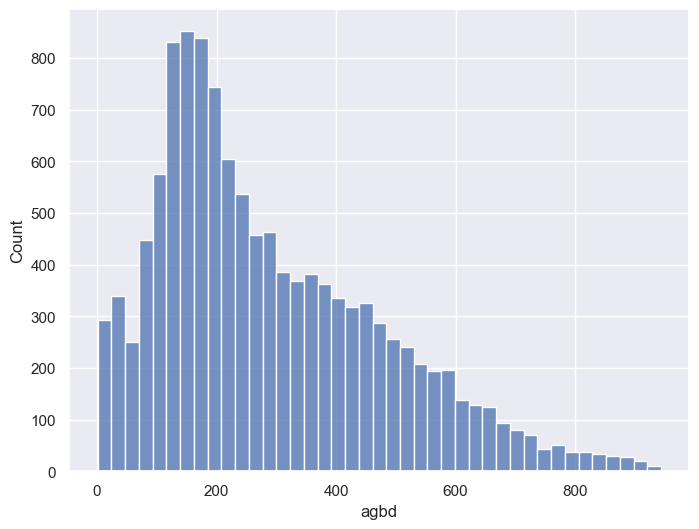

In [9]:
sns.histplot(masterdfprepped['agbd'])

### Drop all ancillary Columns from Data
These are ancillary information and can't be used in model development. This should result in 56 Columns

In [10]:
colDrop = ['clusterLabel','clusterLabelStr','Ownership','gnn','silWidth','lat','lon','uniqid']
masterdfprepped = masterdfprepped.drop(columns = colDrop)
print(len(masterdfprepped.columns))

53


In [11]:
list(masterdfprepped.columns)

['DouglasFir',
 'EVI',
 'FabDEM',
 'HStF',
 'NBR',
 'NDMI',
 'Other_Hardwood',
 'Red_Alder',
 'Red_Cedar',
 'SAVI',
 'agbd',
 'brightness',
 'cosAspect',
 'green',
 'greenness',
 'nir',
 'nonForestType',
 'notHarvestable',
 'red',
 'sinAspect',
 'slope',
 'swir1',
 'swir2',
 'tcAngleBG',
 'tcAngleBW',
 'tcAngleGW',
 'tcDistBG',
 'tcDistBW',
 'tcDistBW_asm',
 'tcDistBW_corr',
 'tcDistBW_idm',
 'tcDistBW_imcorr1',
 'tcDistBW_imcorr2',
 'tcDistBW_savg',
 'tcDistBW_sent',
 'tcDistBW_var',
 'tcDistGW',
 'tpi11',
 'tpi21',
 'tpi41',
 'wetness',
 'EVI_asm',
 'EVI_corr',
 'EVI_idm',
 'EVI_imcorr1',
 'EVI_savg',
 'EVI_sent',
 'EVI_var',
 'HeatLoadIndex',
 'GLI',
 'ExBlue',
 'ExGreen',
 'ExRed']

### Split Data into X And Y datasets


In [14]:
Xdf = masterdfprepped[finalPredList]
ydf = masterdfprepped['agbd']                             

In [15]:
Xdf.columns

Index(['EVI', 'tcDistBW_idm', 'FabDEM', 'tpi41', 'GLI', 'tcDistBW_savg', 'NBR',
       'red', 'tcDistBW', 'tcDistBW_var', 'NDMI', 'EVI_var', 'cosAspect',
       'EVI_idm', 'ExBlue', 'greenness', 'green', 'tcAngleBG', 'SAVI', 'swir2',
       'sinAspect', 'slope', 'ExRed', 'HeatLoadIndex', 'HStF', 'tcAngleBW'],
      dtype='object')

### Keep for DK

In [ ]:

# impFeaturesTrue = [
#     'tcAngleBG',
#     'slope',
#     'tcDistBW_savg',
#     'cosAspect',
#     'FabDEM',
#     'tcDistBW',
#     'tcDistBG',
#     'sinAspect',
#     'greenness',
#     'NDMI',
#     'tpi41',
#     'brightness',
#     'NBR',
#     'GLI',
#     'tcDistBW_var',
#     'HStF',
#     'ExBlue',
#     'DouglasFir',
#     'tcDistBW_idm',
#     'tcDistBW_corr',
#     'tcDistGW',
#     'tpi11',
#     'EVI_savg',
#     'EVI_var',
#     'wetness',
#     'tcDistBW_sent',
#     'tpi21',
#     'tcAngleGW',
#     'EVI_sent',
#     'HeatLoadIndex',
#     'EVI_corr',
# ]


In [16]:
Xdf

,EVI,tcDistBW_idm,FabDEM,tpi41,GLI,tcDistBW_savg,NBR,red,tcDistBW,tcDistBW_var,...,green,tcAngleBG,SAVI,swir2,sinAspect,slope,ExRed,HeatLoadIndex,HStF,tcAngleBW
1,7151,211,679,83,508.779829,27,6782,849,3472,7,...,1054,1259,3789,596,4501,531,410.992366,8828,0,-116
2,1507,1041,941,166,1179.039301,105,2799,894,2474,29,...,1010,-62,777,712,-2607,1794,732.121212,8936,1,-586
4,7014,432,1049,-41,529.709811,42,7007,796,3186,3,...,1028,1220,3560,501,9985,917,270.084401,7598,1,21
5,9958,723,568,-19,-2330.935252,176,7947,477,4173,146,...,857,2030,6285,545,-8974,281,-842.011571,8914,0,-222
6,8674,2261,521,-121,-644.216691,147,8239,437,3226,104,...,727,1969,5329,354,-8982,601,-550.406116,9301,1,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,5720,931,2203,-491,347.284061,97,8034,323,2090,219,...,542,1722,3712,237,-4873,654,-539.339339,9037,0,-46
17246,5537,2086,765,-74,171.325518,99,8019,321,2032,17,...,545,1713,3631,233,-8359,242,-577.992745,8852,0,13
17247,5091,2126,767,-103,213.903743,99,7792,330,1951,17,...,549,1604,3353,243,-558,387,-520.646320,8618,0,-43
17248,5777,1467,850,124,115.555556,113,8141,331,2113,68,...,556,1755,3785,229,1410,262,-550.862582,8526,0,46


In [17]:
len(masterdfprepped)

12012

In [18]:
list(Xdf.columns)

['EVI',
 'tcDistBW_idm',
 'FabDEM',
 'tpi41',
 'GLI',
 'tcDistBW_savg',
 'NBR',
 'red',
 'tcDistBW',
 'tcDistBW_var',
 'NDMI',
 'EVI_var',
 'cosAspect',
 'EVI_idm',
 'ExBlue',
 'greenness',
 'green',
 'tcAngleBG',
 'SAVI',
 'swir2',
 'sinAspect',
 'slope',
 'ExRed',
 'HeatLoadIndex',
 'HStF',
 'tcAngleBW']

### Apply Transformation
Transforming the taget variable can often result in improved model performance. Typical transforms include 'square root', 'log', and 'log10'. We will transform the data using 'log'

count    12012.000000
mean         5.390107
std          0.881996
min          0.000000
25%          4.976734
50%          5.480639
75%          6.016157
max          6.850126
Name: agbd, dtype: float64


<Axes: xlabel='agbd', ylabel='Count'>

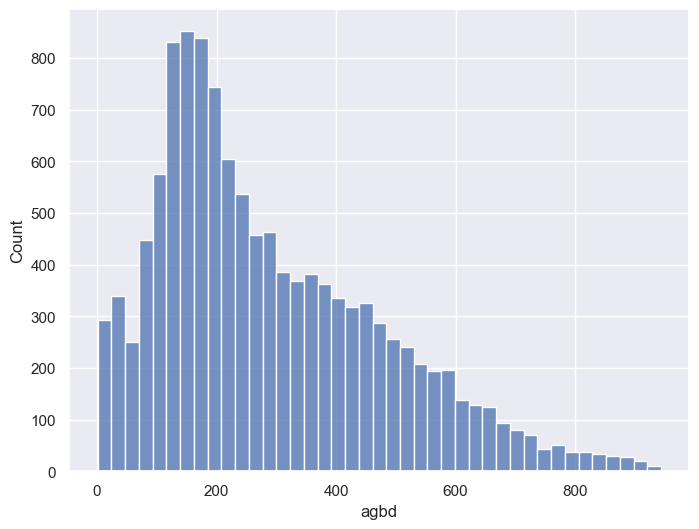

In [19]:
ydf_log = np.log(ydf)
print(ydf_log.describe())

sns.histplot(ydf)

In [20]:
gMean = stats.gmean(ydf)
yMean = ydf.mean()

224.308763663772 * 0.34010048710261087 

76.28751978343328

5.390106850295962


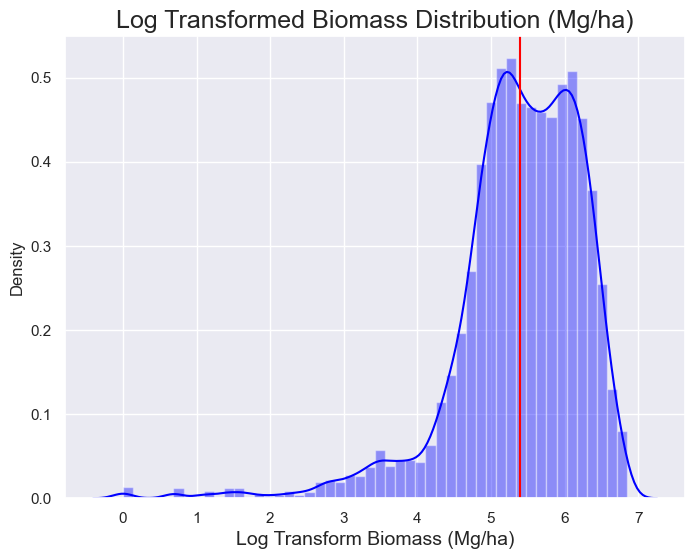

In [21]:
# x = shapefile['agbd_1'].values   # agbd_update is GNN:1 = gdb = Lower, GNN: 2 = Upper, GNN 3: Mean // agbd_1 #shapefile

sns.distplot(ydf_log, color = 'blue');

# Calculating the mean
mean = ydf_log.mean()
print(mean)

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

plt.title("Log Transformed Biomass Distribution (Mg/ha)", fontsize=18)
plt.xlabel("Log Transform Biomass (Mg/ha)", fontsize=14)

plt.show()


0.44804751754148237


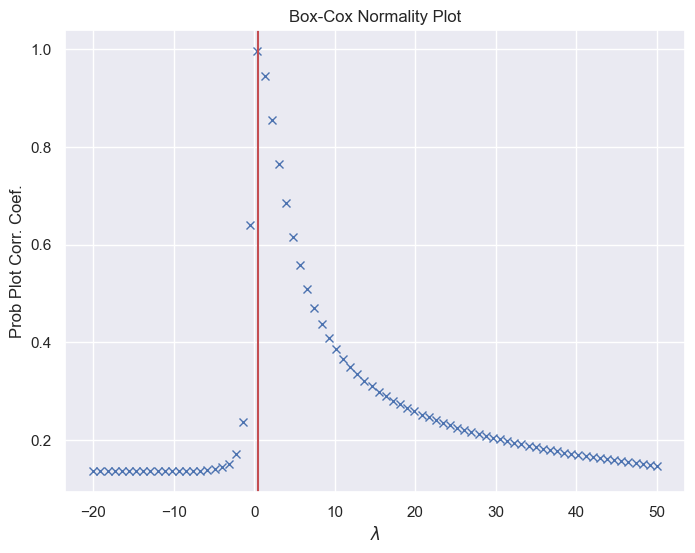

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(ydf,-20,50, plot= ax)

_, maxlog = stats.boxcox(ydf)
ax.axvline(maxlog,color='r')

print(maxlog)

## FIX ME LATER!!!!

In [45]:
len(Xdf.columns)

52

## Example Distribution of Variables

In [155]:
# import statsmodels.api as sm

In [ ]:
# # # identifying all numeric columns
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# n_variables = Xdf.select_dtypes(include=numerics).columns

# # # Increases the size of sns plots
# # sns.set(rc={'figure.figsize':(8,5)})


# # for n in n_variables:
# #     x = Xdf_no_corr[n].values
# # #     sns.distplot(x, color = 'blue');
# #     sns.boxplot(x, color = 'blue');

# # #     sm.qqplot(x, dist = stats.norm, fit=True, line = 'q')

# #     # Calculating the mean
# #     mean = Xdf_no_corr[n].mean()

# # #     #ploting the mean
# # #     plt.axvline(mean, 0,1, color = 'red')
# #     plt.title(n)
# # #     plt.show()

# for c in n_variables:    
#     x = Xdf[c].values
#     ax = sns.boxplot(x, color = '#D1EC46')
#     print('The median is: ', Xdf[c].median())
#     plt.title(c)
#     plt.show()
    

# Modeling

### Spliting the Data
The Conduct the modeling, we need to split the data in a training and test dataset. We will use a 80:20 split while ensuring the statisatical variance is as close to zeero as possible

In [238]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
import statistics

def findRandomState(x_data, y_data, thres):
    randomState = 1
    diff = 10
    yield randomState, diff
    while diff > thres:
        randomState += 1
#         print(randomState)
        print(f'---Random State equals {randomState}')
        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state=randomState) #ydf_log,#248 #218,#18 #28, 68, 128, 428 #Xdf or Xdf_no_corr
        # import a library for spliting data into random train and test subsets
        diff = abs((statistics.variance(y_train))-(statistics.variance(y_test)))
#         diff = diff2
        print(round(diff,4))
#         if diff > 0.002:
#             j+=1
        yield randomState, diff

    
for randomState, thres in findRandomState(Xdf, ydf_log,0.0001):
    print('\n')

# for randomState, thres in findRandomState(Xdf, ydf,5):
#     print('\n')





---Random State equals 2
0.0093


---Random State equals 3
0.051


---Random State equals 4
0.0512


---Random State equals 5
0.034


---Random State equals 6
0.0417


---Random State equals 7
0.0785


---Random State equals 8
0.0229


---Random State equals 9
0.0026


---Random State equals 10
0.0003


---Random State equals 11
0.0932


---Random State equals 12
0.0606


---Random State equals 13
0.0208


---Random State equals 14
0.0138


---Random State equals 15
0.0627


---Random State equals 16
0.0646


---Random State equals 17
0.0237


---Random State equals 18
0.0542


---Random State equals 19
0.0031


---Random State equals 20
0.0286


---Random State equals 21
0.0338


---Random State equals 22
0.0119


---Random State equals 23
0.0861


---Random State equals 24
0.0279


---Random State equals 25
0.1126


---Random State equals 26
0.0341


---Random State equals 27
0.0374


---Random State equals 28
0.0025


---Random State equals 29
0.0358


---Random State equals 30
0.

The smallest variance occurs when random state equals 218.

In [23]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
import statistics
# i.e. 80 % training dataset and 20 % test datasets
X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf_log, test_size = 0.2, random_state=394) #100#rs: 196 #ydf_log,#248 #218,#18 #28, 68, 128, 428 #Xdf or Xdf_no_corr #536
# import a library for spliting data into random train and test subsets

# ---- random state 438 ---#
X_train.shape
X_test.shape
y_train.shape
y_test.shape
print("y Train Var",statistics.variance(y_train))
print("y Test Var",statistics.variance(y_test))
diff = (statistics.variance(y_train))-(statistics.variance(y_test))
#         diff = diff2
print('Variance Difference',round(diff,4))

y Train Var 0.7779732838074063
y Test Var 0.777969538999049
Variance Difference 0.0


In [24]:
X_train

,EVI,tcDistBW_idm,FabDEM,tpi41,GLI,tcDistBW_savg,NBR,red,tcDistBW,tcDistBW_var,...,green,tcAngleBG,SAVI,swir2,sinAspect,slope,ExRed,HeatLoadIndex,HStF,tcAngleBW
3727,5429,1597,1890,-165,268.456376,115,7411,377,2188,33,...,580,1609,3589,325,-4422,1679,-294.582393,9388,0,-154
3842,5423,809,3078,-820,-280.898876,99,8281,310,1988,121,...,549,1746,3633,198,-7194,2037,-711.193568,10623,0,97
13830,5754,1411,2526,-67,97.951915,117,7675,339,2184,67,...,556,1727,3821,299,7882,2468,-484.812388,5450,1,-102
1623,4143,2392,8369,-232,621.572212,91,7648,327,1697,11,...,513,1449,2802,216,-5844,1495,-343.497200,10289,1,5
3686,7959,830,1635,229,204.081633,121,8552,411,2727,109,...,672,1899,4690,238,-9814,2299,-472.602740,10525,0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8864,4487,1179,3631,-729,515.267176,92,8051,307,1735,75,...,497,1594,3063,188,7759,68,-434.951456,8555,0,63
10132,3157,2405,4817,-78,723.488603,69,7471,290,1399,10,...,468,1241,2200,180,-9960,3513,-419.769804,11171,1,-10
14719,8308,1218,2620,-619,-294.573643,132,8240,400,3058,59,...,664,1959,5168,332,9536,2202,-532.241556,6696,1,-70
1008,5559,1852,8720,904,-106.470106,124,7421,408,2326,15,...,617,1626,3741,346,6815,1767,-249.183896,8365,1,-147


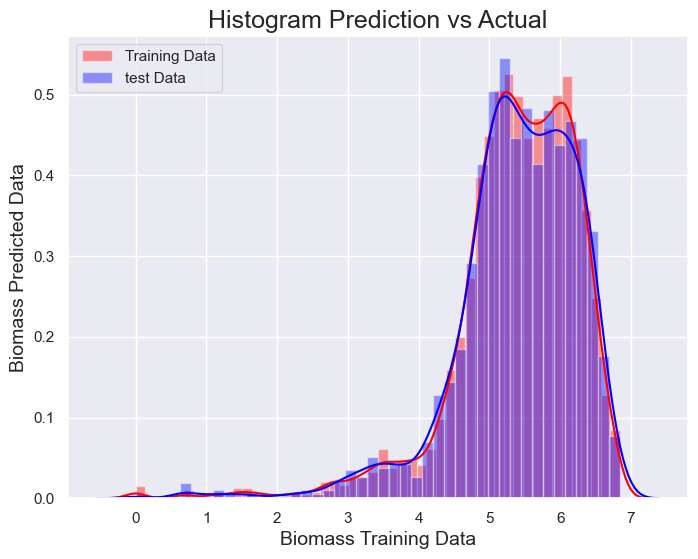

In [25]:
plt.figure() #plt.figure(figsize=(14,8))

sns.distplot(y_train,color='red', label = "Training Data")
sns.distplot(y_test,color='blue', label = "test Data")

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()

In [26]:
from mlxtend.evaluate import bias_variance_decomp

In [27]:
geoMean = stats.gmean(ydf)
geoMean

219.22680875194237

## Test All models at once

Multiple machine learning (ML) algorithms can be used in developing the model. Here, we will test which ML models perform the best 'out of the box' and records the MAE, RMSE, R2, Bias, and run time. Results are based on a 50-fold cross validation. Tested models include

- Lasso Regression
- Support Vector Regression
- Random Forest
- Light GBM

In [28]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgbm
# import xgboost as xg

# import catboost as cb

SVM_Regression = SVR()

np.random.seed(42)


#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    start_time = time.time()
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=RobustScaler()) #transformer=QuantileTransformer(output_distribution='normal')
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_test)
    yhat_train = regr_trans.predict(X_train)
    bias00 = y_test - yhat
    bias01 = np.mean(yhat) - np.mean(y_test) 
#     var = 
    mean = np.mean(ydf)
    geoMean = stats.gmean(ydf)
    print(geoMean,"GeoMean")
    mse, bias, var = bias_variance_decomp(regr_trans, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=42)
    trainScore = regr_trans.score(X_train, y_train)
    algoname= x.__class__.__name__
    return algoname, round(mean,3),round(geoMean,3),round(r2_score(y_test, yhat),3),round(trainScore,3), round(mean_absolute_error(y_test, yhat)*geoMean,3), round((mean_absolute_error(y_test, yhat)*geoMean/geoMean)*100,3),round(np.mean(np.abs(bias))*geoMean,3),round(np.mean(var)*geoMean,3), round(time.time() - start_time, 3) 
# lgbm.LGBMRegressor(boosting='dart')
# lgbm_model
algo=[Lasso(), SVR(), lgbm.LGBMRegressor(), RandomForestRegressor()] ##, cb.CatBoostRegressor(silent=True,loss_function='RMSE')
# algo=[Lasso()] ##, cb.CatBoostRegressor(silent=True,loss_function='RMSE')
score=[]
for a in algo:
    score.append(boost_models(a))

#Collate all scores in a table
pd.DataFrame(score, columns=['Model','Mean','GeoMean' ,'R2 Pred','R2 Train', 'MAE', '%MAE','Bias', 'Variance','Run Time (sec)'])

219.22680875194237 GeoMean
219.22680875194237 GeoMean
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6362
[LightGBM] [Info] Number of data points in the train set: 9609, number of used features: 26
[LightGBM] [Info] Start training from score -0.089017
219.22680875194237 GeoMean
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6360
[LightGBM] [Info] Number of data points in the train set: 9609, number of used features: 26
[LightGBM] [Info] Start training from score -0.090738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

,Model,Mean,GeoMean,R2 Pred,R2 Train,MAE,%MAE,Bias,Variance,Run Time (sec)
0,Lasso,289.356,219.227,0.651,0.665,90.624,41.338,59.503,0.161,8.375
1,SVR,289.356,219.227,0.724,0.729,78.836,35.961,47.053,0.524,362.080
2,LGBMRegressor,289.356,219.227,0.763,0.831,73.045,33.319,39.802,2.450,9.305
3,RandomForestRegressor,289.356,219.227,0.758,0.891,73.763,33.647,41.244,2.222,1045.049


Based on these results, LightGBM and Random Forest preformed very similiarly reaching 74.6% and 73.8% respectively. LightGBM slightly outperforms Random forest and is what we will use moving forward

## Deploy LightGBM Model


In [29]:
# importing Extreme Gradient Boosting from assemble module
import lightgbm as lgbm
# from sklearn.metrics import plot_confusion_matrix

# # creating a RF classifier
lgbm_model = lgbm.LGBMRegressor()



# lgbm_model = lgbm.LGBMRegressor( boosting='dart ', #dart, #gbdt
#                                 n_estimators = 200,
#                                 skip_drop=.7, 
#                                 objective = "regression",#"rmse",#"rmse",
#                                 metric = "rmse",#"auto", #rmse
# #                                 use_missing = False,
# # #                                  bagging_freq=2,
# #                                  learning_rate=0.0969578156634451,
# #                                  num_leaves=50,
# #                                  max_depth =9,
# #                                  subsample =0.36757723146090926,
# #                                  colsample_bytree = 0.8510828195820848
#                                ) #boosting='gbdt'#objective='mse', seed=8798, num_threads=1

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_model.predict(X_test)

y_pred_train_lgbm = lgbm_model.predict(X_train)

# y_pred_full_lgbm = lgbm_model.predict(Xdf_no_corr)


# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("\nTraining Accuracy is: ", lgbm_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", lgbm_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with LightGBM Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with LightGBM Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with LightGBM Regression is:', mae_xgb)

print('Mean agbd Value:',np.mean(ydf_log))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6362
[LightGBM] [Info] Number of data points in the train set: 9609, number of used features: 26
[LightGBM] [Info] Start training from score 5.388548

Training Accuracy is:  0.8590512902333975
Testing Accuracy is:  0.7632812151944215
R-Square Error associated with LightGBM Regression is: 0.7632812151944215
RMSE associated with LightGBM Regression is: 0.42904937518842795
MAE associated with LightGBM Regression is: 0.33319323411338303
Mean agbd Value: 5.390106850295962


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

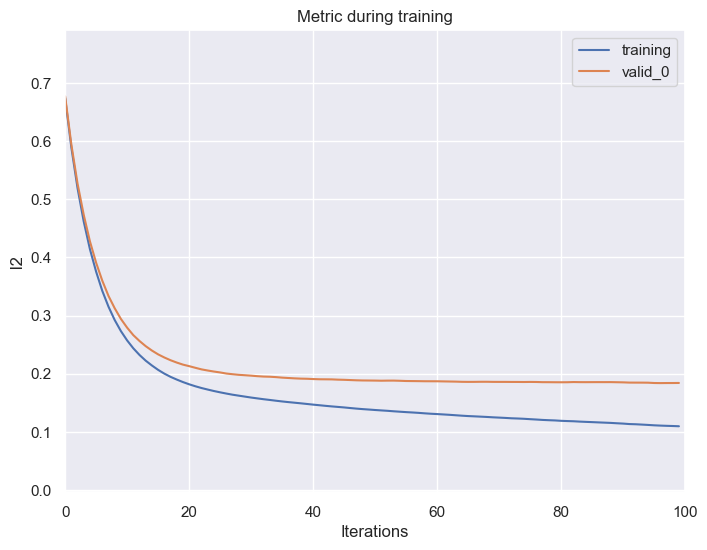

In [30]:
lgbm.plot_metric(lgbm_model)

### Model Tuning with Optuna
Model performance can often be improved when modifying the default parameters. We will use the Optuna package to tune the parameter in our currently LightGBM Model

Furthermore, we will incorperate DART boosting to minimize the influence of overfitting in the dataset

Note: This is an iterative process and may not result in improved model performance

https://medium.com/@sarahzouinina/a-deep-dive-into-lightgbm-how-to-choose-and-tune-parameters-7c584945842e



In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
# from optuna.samplers import TPESampler
import optuna
from optuna.samplers import TPESampler

# 1 tune min_data_in_leaf


def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": 'dart', #gbdt #dart
        "skip_drop": trial.suggest_float("skip_drop", 0.60, 0.80,step=0.01), #.95
        "n_estimators": trial.suggest_int("n_estimators",50,500,step=10),
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.8, log=True), ### YES
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10), ### YES
        "max_depth": trial.suggest_int("max_depth", 1, 12), ### YES
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),  ### YES
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
# #         "early_stopping_rounds":10,
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),

        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),

    }
    
    #'learning_rate': 0.09730213213959626

    model = lgbm.LGBMRegressor(**params)
#     model.fit(X_train, y_train, verbose=False)
#     predictions = model.predict(X_test)
#     r2 = metrics.r2_score(y_test,predictions)
#     score = mean_squared_error(y_test, predictions, squared=False)

    score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5))
    # score = np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='r2', cv =5))
    return score

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='minimize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest RMSE
# study = optuna.create_study(direction='maximize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest RMSE
study.optimize(objective, n_trials=100)

[I 2025-03-28 12:54:48,074] A new study created in memory with name: no-name-070ed16d-97e0-4206-a16a-6ac1cd4604d2


[I 2025-03-28 12:54:49,841] Trial 0 finished with value: 2.8108162041878457 and parameters: {'skip_drop': 0.74, 'n_estimators': 180, 'learning_rate': 0.004555858043396975, 'num_leaves': 565, 'max_depth': 9, 'subsample': 0.45195113711823787, 'lambda_l1': 6.712399331356397, 'lambda_l2': 0.014570271595538578, 'colsample_bytree': 0.5068853064101428, 'min_data_in_leaf': 90, 'bagging_fraction': 0.6059068096905217, 'bagging_freq': 6, 'feature_fraction': 0.6631433468077746}. Best is trial 0 with value: 2.8108162041878457.
[I 2025-03-28 12:54:51,188] Trial 1 finished with value: 0.46832142535555316 and parameters: {'skip_drop': 0.61, 'n_estimators': 230, 'learning_rate': 0.13882480522779336, 'num_leaves': 188, 'max_depth': 3, 'subsample': 0.5549738051497465, 'lambda_l1': 0.0006115729720282377, 'lambda_l2': 0.005123994170264194, 'colsample_bytree': 0.8569602043739001, 'min_data_in_leaf': 151, 'bagging_fraction': 0.7666141064065497, 'bagging_freq': 6, 'feature_fraction': 0.5937753483119069}. Best

##### Simple Tuning

In [457]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import cross_val_score
# from lightgbm import early_stopping
# # from optuna.samplers import TPESampler
# import optuna
# from optuna.samplers import TPESampler

# # 1 tune min_data_in_leaf


# def objective(trial):
#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "boosting_type": 'dart', #gbdt #dart
#         "skip_drop": trial.suggest_float("skip_drop", 0.60, 0.95,step=0.01),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 50),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),

#     }
    
#     #'learning_rate': 0.09730213213959626

#     model = lgbm.LGBMRegressor(**params)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(stopping_rounds=100)])
#     preds = model.predict(X_test)
#     score = root_mean_squared_error(y_test, preds)
#     return score

#     # score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5))
#     # # score = np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='r2', cv =5))
#     # return score

# sampler = TPESampler(seed=123)
# study = optuna.create_study(direction='minimize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest RMSE
# # study = optuna.create_study(direction='maximize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest RMSE
# study.optimize(objective, n_trials=100)

[I 2025-03-28 10:14:57,082] A new study created in memory with name: no-name-c4838f11-ca6d-4c97-a3f8-4145fe3f98b3
[I 2025-03-28 10:14:58,135] Trial 0 finished with value: 1.5863071840137424 and parameters: {'skip_drop': 0.85, 'n_estimators': 214, 'learning_rate': 0.002842515929299161, 'num_leaves': 37, 'max_depth': 8, 'min_data_in_leaf': 27, 'feature_fraction': 0.9942292595153847}. Best is trial 0 with value: 1.5863071840137424.
[I 2025-03-28 10:14:59,072] Trial 1 finished with value: 0.6959441756199385 and parameters: {'skip_drop': 0.84, 'n_estimators': 292, 'learning_rate': 0.006084642077147054, 'num_leaves': 30, 'max_depth': 8, 'min_data_in_leaf': 27, 'feature_fraction': 0.7179033689828704}. Best is trial 1 with value: 0.6959441756199385.
[I 2025-03-28 10:15:00,644] Trial 2 finished with value: 2.6282586446434353 and parameters: {'skip_drop': 0.74, 'n_estimators': 395, 'learning_rate': 0.002317306399075523, 'num_leaves': 25, 'max_depth': 7, 'min_data_in_leaf': 31, 'feature_fraction'

In [ ]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.show()

In [40]:
print('Best hyperparameters:', study.best_params)
print('Best Score:', study.best_value)

Best hyperparameters: {'skip_drop': 0.74, 'n_estimators': 430, 'learning_rate': 0.0769911122841696, 'num_leaves': 842, 'max_depth': 12, 'subsample': 0.6572447386837766, 'lambda_l1': 0.00021035468371501475, 'lambda_l2': 1.7730417457318156e-07, 'colsample_bytree': 0.4308873788725401, 'min_data_in_leaf': 100, 'bagging_fraction': 0.9229539669792365, 'bagging_freq': 5, 'feature_fraction': 0.5564150777078827}
Best Score: 0.42755527847141084


In [41]:


bestParamDict08 = study.best_params
bestParamDict08

{'skip_drop': 0.74,
 'n_estimators': 430,
 'learning_rate': 0.0769911122841696,
 'num_leaves': 842,
 'max_depth': 12,
 'subsample': 0.6572447386837766,
 'lambda_l1': 0.00021035468371501475,
 'lambda_l2': 1.7730417457318156e-07,
 'colsample_bytree': 0.4308873788725401,
 'min_data_in_leaf': 100,
 'bagging_fraction': 0.9229539669792365,
 'bagging_freq': 5,
 'feature_fraction': 0.5564150777078827}

In [34]:
standardParams = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'dart'
}

In [42]:
bestParamDict08.update(standardParams)
bestParamDict08

{'skip_drop': 0.74,
 'n_estimators': 430,
 'learning_rate': 0.0769911122841696,
 'num_leaves': 842,
 'max_depth': 12,
 'subsample': 0.6572447386837766,
 'lambda_l1': 0.00021035468371501475,
 'lambda_l2': 1.7730417457318156e-07,
 'colsample_bytree': 0.4308873788725401,
 'min_data_in_leaf': 100,
 'bagging_fraction': 0.9229539669792365,
 'bagging_freq': 5,
 'feature_fraction': 0.5564150777078827,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'dart'}

### Update LightGBM Model with new Parameters


In [43]:
lgbm_final_model = lgbm.LGBMRegressor(**bestParamDict08)
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_final_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_final_model.predict(X_test)

y_pred_train_lgbm = lgbm_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with LightGBM Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with LightGBM Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with LightGBM Regression is:', mae_xgb)

print(np.mean(ydf_log))

Training Accuracy is:  0.8993743007844078
Testing Accuracy is:  0.7671220705456095
R-Square Error associated with LightGBM Regression is: 0.7671220705456095
RMSE associated with LightGBM Regression is: 0.4255543929474113
MAE associated with LightGBM Regression is: 0.3342156524991509
5.390106850295962


In [77]:
from sklearn.model_selection import KFold
# Cross Validation
# Training data
score = np.mean(cross_val_score(estimator = lgbm_final_model, X=X_train,y=y_train,scoring='r2', cv =KFold(n_splits=10, shuffle=True)))
# Testing Data
score2 = np.mean(cross_val_score(estimator = lgbm_final_model, X=X_test,y=y_test,scoring='r2', cv=KFold(n_splits=10, shuffle=True)))

# Accuracy on Test
print("Training Accuracy is: ", score)
# Accuracy on Train
print("Testing Accuracy is: ", score2)

Training Accuracy is:  0.7635117363387767
Testing Accuracy is:  0.7220479687837188


Using a 10-fold cross validation, we found that the model achieves and Training R2 of 76.84 and Testing R2 of 73.45. The minimal differences in these results suggest the model performs well and does not overfit. 

The Final Parameters used are:
- 'skip_drop': 0.74,
- 'n_estimators': 430,
- 'learning_rate': 0.0769911122841696,
- 'num_leaves': 842,
- 'max_depth': 12,
- 'subsample': 0.6572447386837766,
- 'lambda_l1': 0.00021035468371501475,
- 'lambda_l2': 1.7730417457318156e-07,
- 'colsample_bytree': 0.4308873788725401,
- 'min_data_in_leaf': 100,
- 'bagging_fraction': 0.9229539669792365,
- 'bagging_freq': 5,
- 'feature_fraction': 0.5564150777078827,
- 'objective': 'regression',
- 'metric': 'rmse',
- 'boosting_type': 'dart'

Note: The parameters highlighted above are specifically tailored to the input training set and may not be optimal for other datasets

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

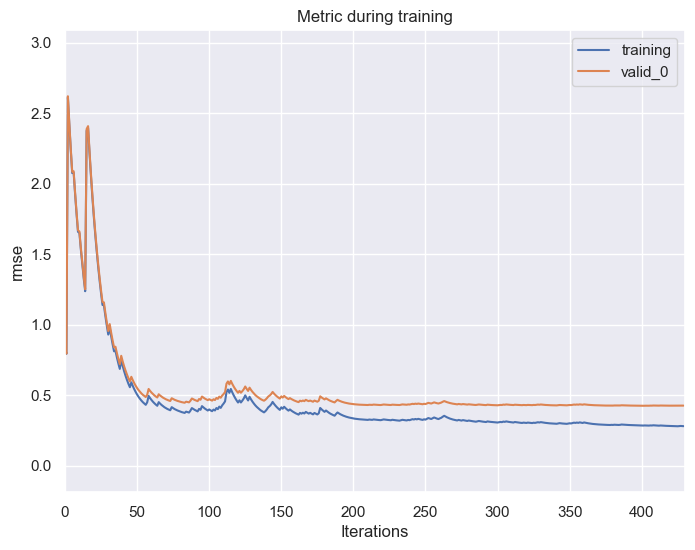

In [76]:
lgbm.plot_metric(lgbm_final_model)

In [82]:
#Visualize parameter importances.
optuna.visualization.plot_optimization_history(study)

In [85]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [86]:
#Visualize parameter importances.
optuna.visualization.plot_parallel_coordinate(study)

### SHAP Feature Importance
Next, let's see which feature contribute the most to model performance. We will use Shap for this

In [47]:
import shap
# Fits the explainer
explainer = shap.Explainer(lgbm_final_model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 2404it [21:10,  1.89it/s]                          


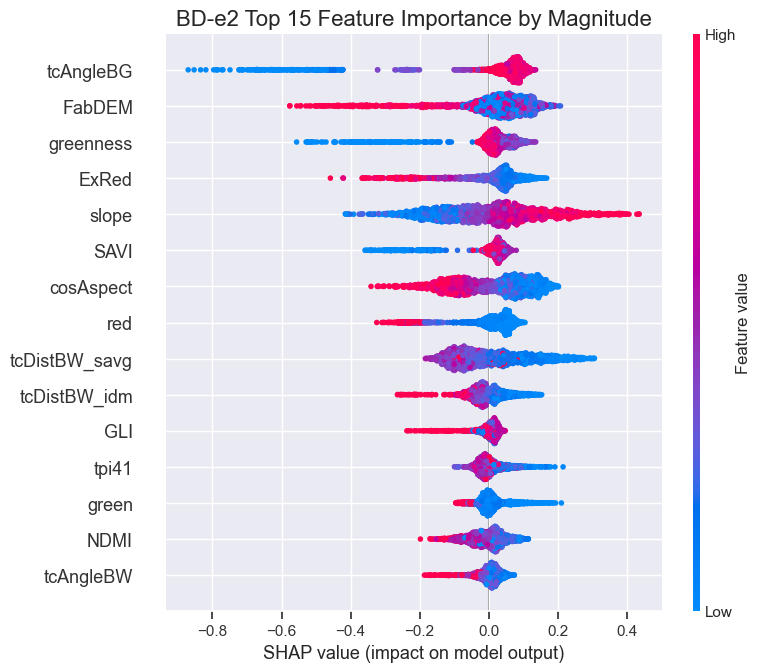

In [81]:
plt.title("BD-e2 Top 15 Feature Importance by Magnitude", fontsize=16)
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display = 15,group_remaining_features=False)

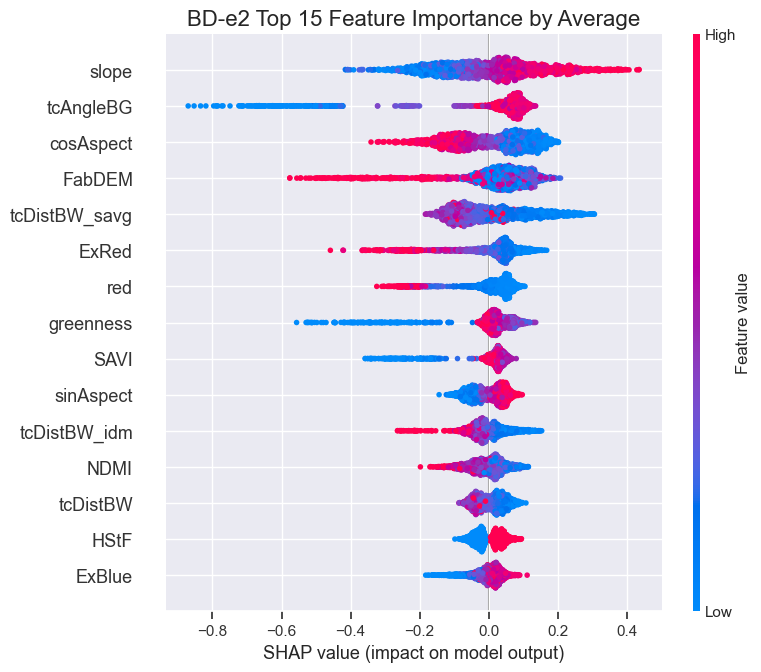

In [74]:
plt.title("BD-e2 Top 15 Feature Importance by Average", fontsize=16)
shap.plots.beeswarm(shap_values,max_display = 15,group_remaining_features=False)

In [50]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df

,EVI,tcDistBW_idm,FabDEM,tpi41,GLI,tcDistBW_savg,NBR,red,tcDistBW,tcDistBW_var,...,green,tcAngleBG,SAVI,swir2,sinAspect,slope,ExRed,HeatLoadIndex,HStF,tcAngleBW
0,0.020570,-0.003577,0.122355,-0.012786,0.006077,-0.038996,-0.073323,-0.177214,-0.026838,0.004338,...,-0.051015,-0.040345,0.012818,-0.034530,-0.074234,0.114709,-0.153146,-0.000407,0.043903,0.008985
1,-0.027769,-0.053193,0.014475,-0.019697,-0.031718,-0.074275,-0.004894,-0.029034,-0.050082,-0.077307,...,-0.003145,0.072540,0.001161,-0.002193,0.041073,0.019832,0.012172,-0.016245,-0.050017,0.009995
2,0.018286,0.010536,0.060824,-0.020774,-0.005199,0.120996,-0.035102,0.064969,0.017253,0.004312,...,0.056283,0.053880,0.030351,-0.029087,-0.057334,-0.009185,0.066794,-0.008947,-0.085490,-0.021935
3,0.017639,-0.026921,-0.398211,-0.000456,0.017712,0.016831,-0.032291,0.006977,0.049178,0.014229,...,0.013173,0.054912,0.045788,-0.023026,-0.015450,0.043060,-0.126191,0.004826,0.024531,0.006730
4,0.043403,0.026212,0.065983,0.035878,-0.006086,0.147085,-0.028864,0.086171,0.019817,0.024151,...,0.035689,0.109775,0.039639,0.005219,-0.042396,-0.060772,0.060902,-0.016089,-0.048074,0.022210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,-0.028586,0.057756,0.079958,-0.009239,0.015736,0.040368,0.000141,0.045105,-0.036818,0.025196,...,-0.003796,0.076284,0.022302,0.015798,-0.116533,0.165344,0.032129,0.011859,-0.043061,-0.001591
2399,-0.031872,-0.007421,-0.002817,-0.021075,0.020271,-0.043052,-0.041257,0.028636,0.018874,-0.021360,...,-0.015487,0.044046,0.020855,-0.004439,-0.083242,0.040260,0.096045,-0.003720,0.025843,-0.033260
2400,0.051777,-0.002024,0.126544,0.061896,0.005821,0.101500,0.011113,0.053083,0.054205,0.023514,...,0.011753,0.090638,0.047572,0.011723,0.048878,0.054981,0.005219,0.014234,0.029762,0.013820
2401,-0.010587,-0.032238,0.022505,-0.017556,-0.002519,-0.105297,0.001037,0.049922,-0.017491,-0.023672,...,-0.000728,0.023377,0.007990,0.008921,-0.077147,-0.131296,0.091448,-0.006989,0.022850,-0.014149


In [51]:
temp00 = pd.DataFrame(shap_df.mean(0),columns=['shapMean']).reset_index(names='preds')
temp01 = pd.DataFrame(shap_df.max(0),columns=['shapMax']).reset_index(names='preds')
temp02 = pd.DataFrame(shap_df.min(0),columns=['shapMin']).reset_index(names='preds')

temp03 = pd.DataFrame(shap_df.abs().mean(0),columns=['absMean']).reset_index(names='preds') #importance by average
temp04 = pd.DataFrame(shap_df.abs().max(0),columns=['absMax']).reset_index(names='preds') # Importance by magnitude

shapSummarydf = pd.merge(temp00,temp01,on='preds')
shapSummarydf = pd.merge(shapSummarydf,temp02,on='preds')
shapSummarydf = pd.merge(shapSummarydf,temp03,on='preds')
shapSummarydf = pd.merge(shapSummarydf,temp04,on='preds')
shapSummarydf.sort_values(by='absMean', ascending = False)

,preds,shapMean,shapMax,shapMin,absMean,absMax
21,slope,0.003202,0.435858,-0.415247,0.116252,0.435858
17,tcAngleBG,0.017044,0.136222,-0.870399,0.106923,0.870399
12,cosAspect,0.006226,0.202207,-0.340707,0.095607,0.340707
2,FabDEM,0.015625,0.208346,-0.576240,0.086705,0.576240
5,tcDistBW_savg,0.004295,0.306517,-0.183359,0.086331,0.306517
22,ExRed,0.007663,0.168283,-0.458492,0.070036,0.458492
7,red,0.010439,0.105368,-0.324193,0.052975,0.324193
15,greenness,0.009006,0.136472,-0.556359,0.050779,0.556359
18,SAVI,0.007005,0.079936,-0.358050,0.042158,0.358050
20,sinAspect,-0.002039,0.097491,-0.143525,0.040629,0.143525


In [52]:
plusSHAP =shapSummarydf[(shapSummarydf["shapMax"]>0)]
plusSHAP = plusSHAP.sort_values(by="shapMax",ascending=False)

negSHAP =shapSummarydf[(shapSummarydf["shapMin"]<0)]
negSHAP['shapMinAbs'] = negSHAP['shapMin'].abs()
negSHAP.sort_values(by="shapMin",ascending=True)


,preds,shapMean,shapMax,shapMin,absMean,absMax,shapMinAbs
17,tcAngleBG,0.017044,0.136222,-0.870399,0.106923,0.870399,0.870399
2,FabDEM,0.015625,0.208346,-0.576240,0.086705,0.576240,0.576240
15,greenness,0.009006,0.136472,-0.556359,0.050779,0.556359,0.556359
22,ExRed,0.007663,0.168283,-0.458492,0.070036,0.458492,0.458492
21,slope,0.003202,0.435858,-0.415247,0.116252,0.435858,0.415247
18,SAVI,0.007005,0.079936,-0.358050,0.042158,0.358050,0.358050
12,cosAspect,0.006226,0.202207,-0.340707,0.095607,0.340707,0.340707
7,red,0.010439,0.105368,-0.324193,0.052975,0.324193,0.324193
1,tcDistBW_idm,-0.004397,0.153762,-0.264202,0.038025,0.264202,0.264202
4,GLI,0.003237,0.048142,-0.236847,0.018782,0.236847,0.236847


<Axes: xlabel='shapMax', ylabel='preds'>

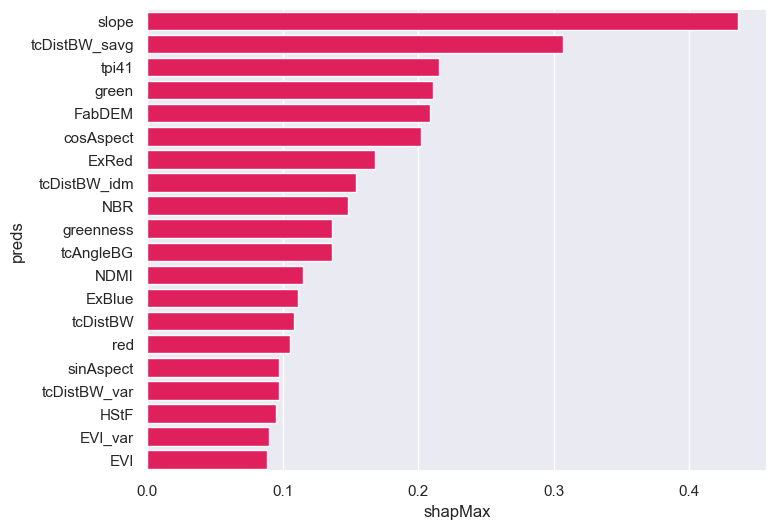

In [53]:
plusSHAP_Top = plusSHAP.nlargest(20, 'shapMax')
sns.barplot(x="shapMax", y="preds", data=plusSHAP_Top, color=shap.plots.colors.red_rgb)

<Axes: xlabel='shapMinAbs', ylabel='preds'>

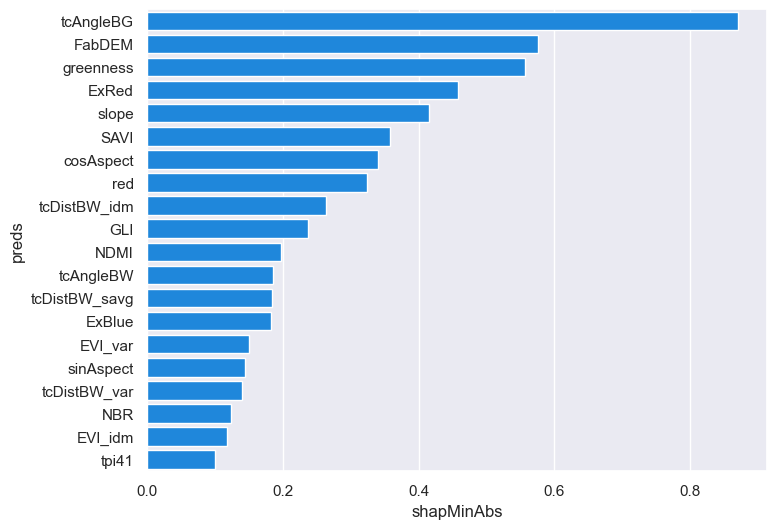

In [54]:
negSHAP_Top = negSHAP.nlargest(20, 'shapMinAbs')
sns.barplot(x="shapMinAbs", y="preds", data=negSHAP_Top, color=shap.plots.colors.blue_rgb)

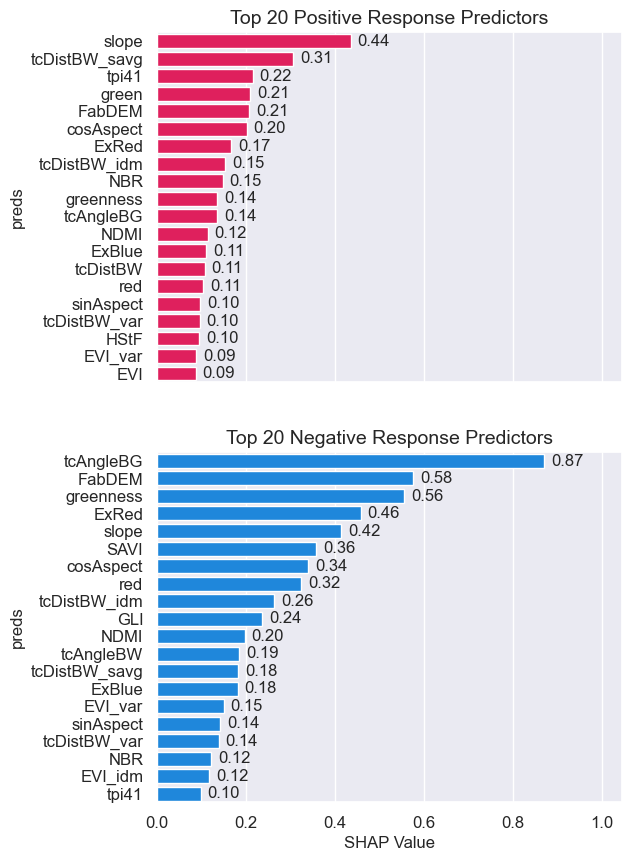

In [55]:
plusSHAP_Top = plusSHAP.nlargest(20, 'shapMax')
negSHAP_Top = negSHAP.nlargest(20, 'shapMinAbs')

fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(6, 10), sharex=True)
sns.barplot(x="shapMax", y="preds", data=plusSHAP_Top, color=shap.plots.colors.red_rgb, ax=ax)
ax.bar_label(ax.containers[0], label_type='edge', fmt = '%.2f', padding = 5, size=12)
ax.margins(x=.2)

ax.set_title(f"Top 20 Positive Response Predictors", fontsize=14)
# ax.set_xlabel(f'Max SHAP Value', fontsize = 14)
# ax.set_ylabel(f'Feature', fontsize = 14)
ax.tick_params(labelsize = 12)
# ax.set_xticklabels(fontsize = 14)
# ax.set_yticklabels(fontsize = 14)
# plt.show()

# fig, ax = plt.subplots(figsize=(6, 4))


sns.barplot(x="shapMinAbs", y="preds", data=negSHAP_Top, color=shap.plots.colors.blue_rgb, ax=ax2)
ax2.bar_label(ax2.containers[0], label_type='edge', fmt = '%.2f', padding = 5, size=12)
ax2.margins(x=.2)
ax2.tick_params(labelsize = 12)

plt.title(f"Top 20 Negative Response Predictors", fontsize=14)
plt.xlabel(f'SHAP Value', fontsize = 12)
# # plt.ylabel(f'Feature', fontsize = 14)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
plt.show()

#### Individual Shap Scatter Plots

In [ ]:
import statsmodels as sm
from scipy.interpolate import interp1d
# import statsmodels.nonparametric.smoothers_lowess.lowess

SHAP Inflection Point occurs at: 1964.838008555515
SHAP Values Range Between: -0.4152468185077329 0.4358579123169219


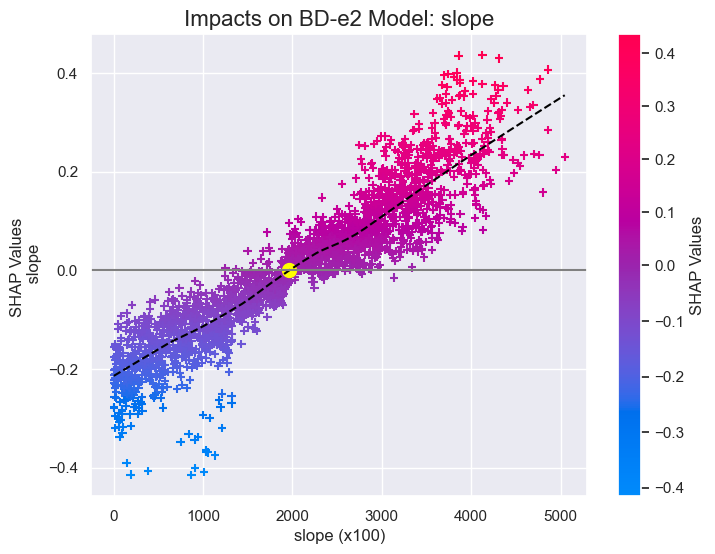

In [ ]:
var_one = 'slope'
print(var_one)

tempdf_reset = X_test.copy().reset_index()
shap_df_reset = shap_df.copy()
tempdf_SHAP = pd.merge(tempdf_reset,shap_df,left_index=True, right_index=True)
# tempdf_SHAP = pd.merge(tempdf_reset,shap_df_reset,on='index', how='left')
# print(tempdf_SHAP)

# df2 = X_test[[var_one]].join(shap_df[var_one])
# print(df2)


# lowess
idx = np.where(X_test.columns==var_one)[0][0]
# print(idx,"idx")
x = X_test.iloc[:,idx]
# print(x,'x')
y_sv = shap_values[:,idx].values
# print(y_sv,'y_sv')
lowess = sm.nonparametric.smoothers_lowess.lowess(y_sv, x, frac=.3)

eval_x = np.linspace(0,4*np.pi,31)

f_linear = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='linear', fill_value = 'extrapolate')
f_nearest = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='nearest', fill_value = 'extrapolate')

xnew = 0

ynew_lnr = f_linear(xnew)
ynew_near = f_nearest(xnew)

print("SHAP Inflection Point occurs at:",ynew_lnr)
# print("SHAP Inflection Point occurs at:",ynew_near)

vcenter = 0
vmin, vmax = shap_values[:,var_one].values.min(), shap_values[:,var_one].values.max()
print("SHAP Values Range Between:",vmin, vmax)
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
# colormap = plt.get_cmap('RdBu')
colormap = shap.plots.colors.red_blue


plt.scatter(X_test[var_one], shap_df[var_one], norm = normalize, c=shap_df[var_one], cmap = colormap, marker = '+')
cbar = plt.colorbar()
cbar.set_label('SHAP Values')
plt.plot(*list(zip(*lowess)), color="black",linestyle="dashed")
plt.axhline(y=0, color='gray')
plt.scatter(ynew_lnr,0,marker='o',s=100, color='yellow')
plt.title(f"Impacts on BD-e2 Model: {var_one}", fontsize=16)
plt.xlabel(f'{var_one} (x100)')
plt.ylabel(f'SHAP Values \n {var_one}')
plt.show()

SHAP Inflection Point occurs at: 10596.163093730604
SHAP Values Range Between: -0.576239731884604 0.20834574630498842


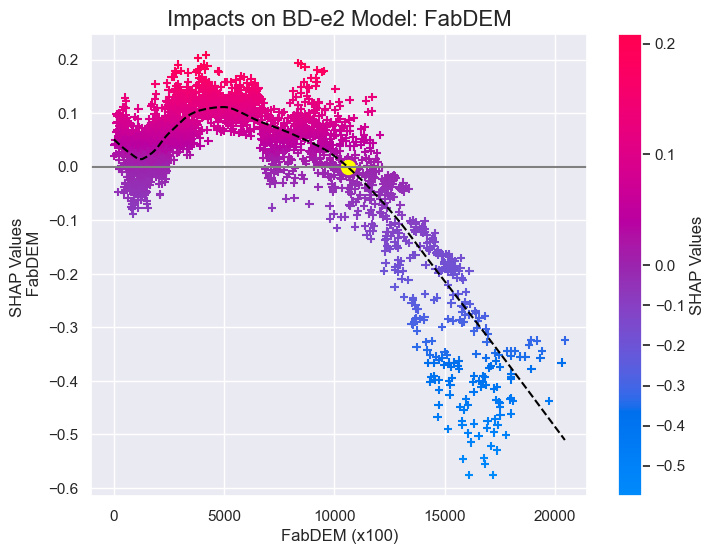

In [ ]:
var_one = 'FabDEM'
print(var_one)

tempdf_reset = X_test.copy().reset_index()
shap_df_reset = shap_df.copy()
tempdf_SHAP = pd.merge(tempdf_reset,shap_df,left_index=True, right_index=True)
# tempdf_SHAP = pd.merge(tempdf_reset,shap_df_reset,on='index', how='left')
# print(tempdf_SHAP)

# df2 = X_test[[var_one]].join(shap_df[var_one])
# print(df2)


# lowess
idx = np.where(X_test.columns==var_one)[0][0]
# print(idx,"idx")
x = X_test.iloc[:,idx]
# print(x,'x')
y_sv = shap_values[:,idx].values
# print(y_sv,'y_sv')
lowess = sm.nonparametric.smoothers_lowess.lowess(y_sv, x, frac=.3)

eval_x = np.linspace(0,4*np.pi,31)

f_linear = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='linear', fill_value = 'extrapolate')
f_nearest = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='nearest', fill_value = 'extrapolate')

xnew = 0

ynew_lnr = f_linear(xnew)
ynew_near = f_nearest(xnew)

print("SHAP Inflection Point occurs at:",ynew_lnr)
# print("SHAP Inflection Point occurs at:",ynew_near)

vcenter = 0
vmin, vmax = shap_values[:,var_one].values.min(), shap_values[:,var_one].values.max()
print("SHAP Values Range Between:",vmin, vmax)
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
# colormap = plt.get_cmap('RdBu')
colormap = shap.plots.colors.red_blue


plt.scatter(X_test[var_one], shap_df[var_one], norm = normalize, c=shap_df[var_one], cmap = colormap, marker = '+')
cbar = plt.colorbar()
cbar.set_label('SHAP Values')
plt.plot(*list(zip(*lowess)), color="black",linestyle="dashed")
plt.axhline(y=0, color='gray')
plt.scatter(ynew_lnr,0,marker='o',s=100, color='yellow')
plt.title(f"Impacts on BD-e2 Model: {var_one}", fontsize=16)
plt.xlabel(f'{var_one} (x100)')
plt.ylabel(f'SHAP Values \n {var_one}')
plt.show()

tcAngleBG
SHAP Inflection Point occurs at: 2153.5825171202573
SHAP Values Range Between: -0.8703994761776946 0.13622221763930675


Text(0, 0.5, 'SHAP Values \n tcAngleBG')

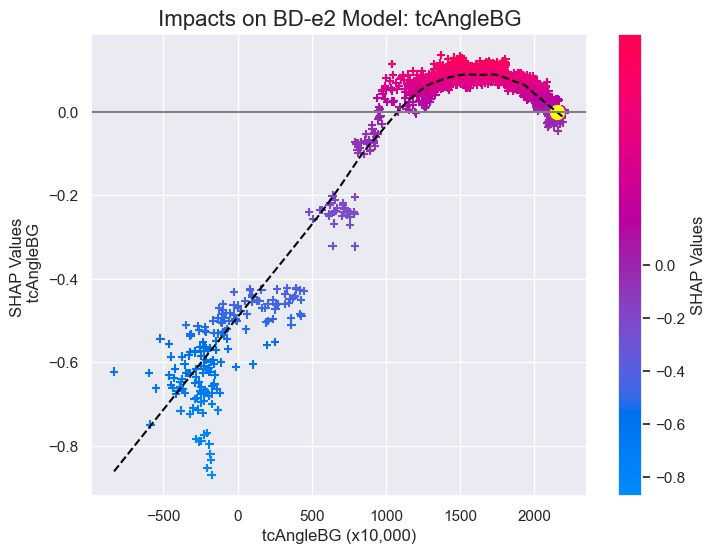

In [99]:
var_one = 'tcAngleBG'
print(var_one)

tempdf_reset = X_test.copy().reset_index()
shap_df_reset = shap_df.copy()
tempdf_SHAP = pd.merge(tempdf_reset,shap_df,left_index=True, right_index=True)
# tempdf_SHAP = pd.merge(tempdf_reset,shap_df_reset,on='index', how='left')
# print(tempdf_SHAP)

# df2 = X_test[[var_one]].join(shap_df[var_one])
# print(df2)


# lowess
idx = np.where(X_test.columns==var_one)[0][0]
# print(idx,"idx")
x = X_test.iloc[:,idx]
# print(x,'x')
y_sv = shap_values[:,idx].values
# print(y_sv,'y_sv')
lowess = sm.nonparametric.smoothers_lowess.lowess(y_sv, x, frac=.3)

eval_x = np.linspace(0,4*np.pi,31)

f_linear = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='linear', fill_value = 'extrapolate')
f_nearest = interp1d(lowess[:,1],y=lowess[:,0], bounds_error = False, kind='nearest', fill_value = 'extrapolate')

xnew = 0

ynew_lnr = f_linear(xnew)
ynew_near = f_nearest(xnew)

print("SHAP Inflection Point occurs at:",ynew_lnr)
# print("SHAP Inflection Point occurs at:",ynew_near)

vcenter = 0
vmin, vmax = shap_values[:,var_one].values.min(), shap_values[:,var_one].values.max()
print("SHAP Values Range Between:",vmin, vmax)
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
# colormap = plt.get_cmap('RdBu')
colormap = shap.plots.colors.red_blue


plt.scatter(X_test[var_one], shap_df[var_one], norm = normalize, c=shap_df[var_one], cmap = colormap, marker = '+')
cbar = plt.colorbar()
cbar.set_label('SHAP Values')
plt.plot(*list(zip(*lowess)), color="black",linestyle="dashed")
plt.axhline(y=0, color='gray')
plt.scatter(ynew_lnr,0,marker='o',s=100, color='yellow')
plt.title(f"Impacts on BD-e2 Model: {var_one}", fontsize=16)
plt.xlabel(f'{var_one} (x10,000)')
plt.ylabel(f'SHAP Values \n {var_one}')

# Save Data
Preliminary models have been completed. Save the following data:
- Training/Testing Data (for your records)
- ML Model (for your records)
- Final Predictor List (Important!!)


In [109]:
mX = "M0"
transform = "log"
date = '20250329'
algo = 'LightGBM_DART'

outDir = f"D:/TO17/^^ExtraExtra/GEDI/HpmGuideMod/models/final/{algo}"

outArray = os.path.join(outDir, f"{mX}_y_pred_{transform}_{algo}.npy")
outArrayTr = os.path.join(outDir, f"{mX}_y_pred_train_{transform}_{algo}.npy")

np.save(outArray, y_pred_lgbm) # save # save
np.save(outArrayTr, y_pred_train_lgbm) # save # save

# save the model to disk
filename = os.path.join(outDir,f'final{mX}_GEDI_EE_Kenobi_{algo}_{transform}_{date}.sav')
joblib.dump(lgbm_final_model, filename) #xgb_final_model # xgb_model



outCSV_ytrain = os.path.join(outDir, f'{mX}_y_train_{transform}_{algo}.csv')
outCSV_ytest = os.path.join(outDir, f'{mX}_y_test_{transform}_{algo}.csv')
outCSV_Xtrain = os.path.join(outDir, f'{mX}_X_train_{algo}.csv')
outCSV_Xtest = os.path.join(outDir, f'{mX}_X_test_{algo}.csv')

outCSV_Xdf = os.path.join(outDir, f'{mX}_X_df_{algo}.csv')
outCSV_ydf = os.path.join(outDir, f'{mX}_y_df_{algo}.csv')


y_train.to_csv(outCSV_ytrain)
y_test.to_csv(outCSV_ytest)
X_train.to_csv(outCSV_Xtrain)
X_test.to_csv(outCSV_Xtest)

Xdf.to_csv(outCSV_Xdf)
ydf_log.to_csv(outCSV_ydf)




In [ ]:
# with open(f'D:/TO17/^^ExtraExtra/GEDI/HpmGuideMod/models/final/{algo}/lightGBM_diagram.svg', 'w') as f:
#     f.write(lgbm_final_model.booster_())

TypeError: 'Booster' object is not callable

### Part 04 Complete
Move on to Part 05: ML Calibrartion

In [ ]:
mse, bias, var = bias_variance_decomp(lgbm_model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=50, random_seed=42)

In [ ]:
bias*geoMean

In [ ]:
var*geoMean

In [ ]:
mse

In [ ]:
np.sqrt(mse)

In [ ]:
# y_hats_df = pd.DataFrame(data = y_pred_lgbm, columns = ['y_pred_lgbm'], index = X_test.index.copy())
# df_out = pd.merge(y_test, y_hats_df, how = 'left', left_index = True, right_index = True)

In [ ]:
# df_out

In [ ]:
# df_out.to_csv('E:\\GEDI\\EndGame\\Tables\\modelTestErrors_20240127.csv')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

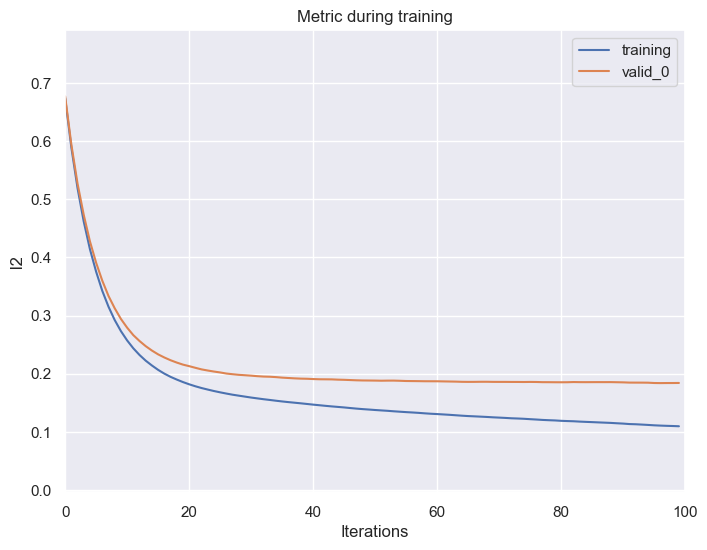

In [73]:
lgbm.plot_metric(lgbm_model)

In [ ]:
y_train

### Calculate Duan Smearing Factor \

In [101]:
residual = y_test - y_pred_lgbm

In [102]:
smearFactor = np.mean(np.exp(residual))
smearFactor

1.1262235803216032

#### Run Boruta to determine to determine most influential predictor

In [103]:
residual = (y_test - y_pred_lgbm)
residual

1048     1.361305
11936    0.490065
6329     0.096123
1695     0.021686
17245   -0.917749
           ...   
4451     0.373688
3178     0.249210
9124    -0.236631
6825    -0.192277
1020     0.444501
Name: agbd, Length: 2403, dtype: float64

<Axes: ylabel='Count'>

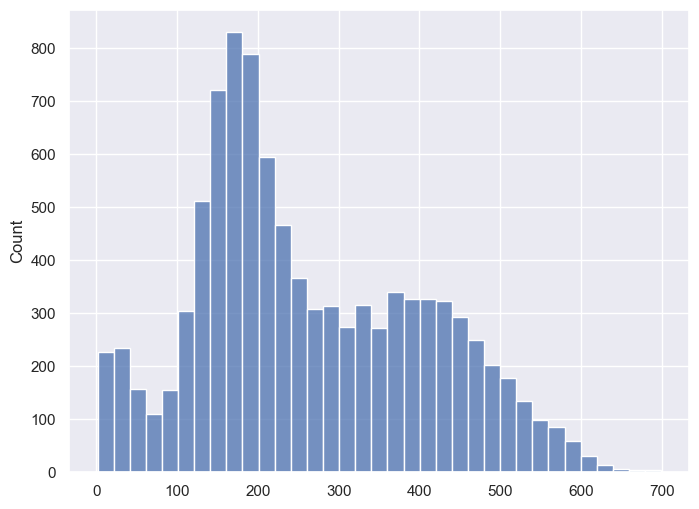

In [104]:
sns.histplot(np.exp(y_pred_train_lgbm))

<Axes: xlabel='agbd', ylabel='Count'>

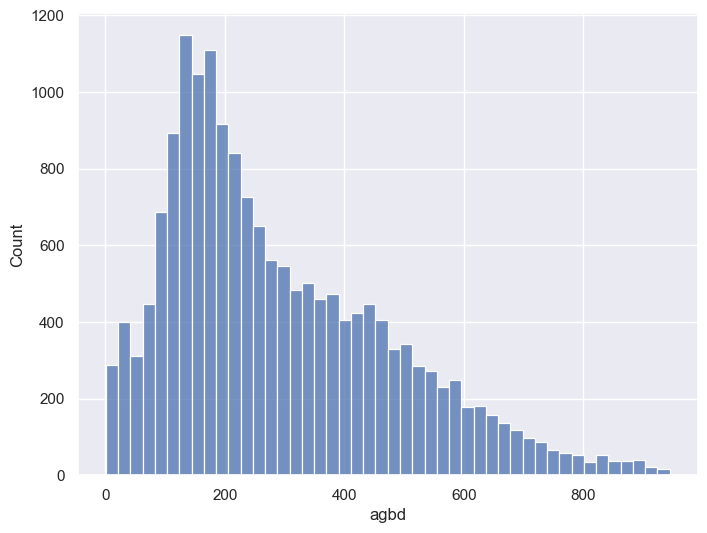

In [105]:
sns.histplot(masterdf['agbd'])

In [ ]:
with open('E:\\GEDI\\EndGame\\lightGBM_diagram.svg', 'w') as f:
    f.write(lgbm_model.booster_())

### Save the Outputs

In [ ]:
mX = "M0"
transform = "log"
date = '20240204'
algo = 'LightGBM_DART'


outDirArray = f"E:\\GEDI\\EndGame\\machineLearningFiles\\{mX}" #### UPdate This!
outArray = os.path.join(outDirArray, f"{mX}_y_pred_{transform}_{algo}.npy")
outArrayTr = os.path.join(outDirArray, f"{mX}_y_pred_train_{transform}_{algo}.npy")
outArrayFull = os.path.join(outDirArray, f"{mX}_y_pred_full_{transform}_{algo}.npy")

np.save(outArray, y_pred_lgbm) # save # save
np.save(outArrayTr, y_pred_train_lgbm) # save # save
np.save(outArrayFull, y_pred_full_lgbm) # save # save

# new_num_arr = np.load('data.npy') # load

In [ ]:
from sklearn import model_selection
import joblib

# save the model to disk
filename = os.path.join(outDirArray,f'{mX}_GEDI_EE_Kenobi_impFeatures_{algo}_{transform}_{date}.sav')
joblib.dump(lgbm_model, filename) #xgb_final_model # xgb_model

In [ ]:
outCSV_ytrain = os.path.join(outDirArray, f'{mX}_y_train_{transform}_{algo}.csv')
outCSV_ytest = os.path.join(outDirArray, f'{mX}_y_test_{transform}_{algo}.csv')
outCSV_Xtrain = os.path.join(outDirArray, f'{mX}_X_train_{algo}.csv')
outCSV_Xtest = os.path.join(outDirArray, f'{mX}_X_test_{algo}.csv')

outCSV_Xdf = os.path.join(outDirArray, f'{mX}_X_df_{algo}.csv')
outCSV_ydf = os.path.join(outDirArray, f'{mX}_y_df_{algo}.csv')


y_train.to_csv(outCSV_ytrain)
y_test.to_csv(outCSV_ytest)
X_train.to_csv(outCSV_Xtrain)
X_test.to_csv(outCSV_Xtest)

Xdf_no_corr.to_csv(outCSV_Xdf)
ydf_log.to_csv(outCSV_ydf)
# y_train
# new_num_arr = np.load('data.npy') # load

In [ ]:
import catboost as cb
from catboost import CatBoostRegressor, Pool

train_pool = cb.Pool(X_train, y_train)
test_pool = cb.Pool(X_test, y_test)

In [ ]:
# importing Extreme Gradient Boosting from assemble module
import catboost as cb
from catboost import CatBoostRegressor, Pool
from catboost.utils import eval_metric

# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
cb_model = cb.CatBoostRegressor(loss_function='RMSE') #,iterations=1000, learning_rate=0.01#objective='mse', seed=8798, num_threads=1

eval_pool = Pool(X_test, y_test)




# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
cb_model.fit(train_pool, eval_set=eval_pool, verbose=10, plot=True) #early_stopping_rounds=500
 
# performing predictions on the test dataset
y_pred_cb = cb_model.predict(X_test)

y_pred_train_cb = cb_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", cb_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", cb_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_cb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb)

rms_xgb_train = metrics.mean_squared_error(y_train, y_pred_train_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_train)
mae_xgb_train = metrics.mean_absolute_error(y_train, y_pred_train_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb_train)

print(np.mean(ydf_log))

### Tuning Histogram XGB Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier = HistGradientBoostingRegressor() #'gpu_hist'
# classifier = lgbm.LGBMRegressor()

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=10
                        ,scoring='neg_root_mean_squared_error'
                        ,cv=10,verbose=3) #'r2'

# fitting it
clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
print(clf.best_params_)
clf.best_estimator_

In [ ]:
# fiting the model with the best parameters
xgb_final_model = clf.best_estimator_


# fitting it
xgb_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_xgb_final = xgb_final_model.predict(X_test) # X_test_filtered # X_test
y_pred_xgb_ROE_Only = xgb_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model.score(X_test, y_test))

r_square_xgb_final = metrics.r2_score(y_test,y_pred_xgb_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, y_pred_xgb_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
history = xgb_final_model.fit(
    X_train, y_train,
#     validation_data=(X_test, y_test),
#     batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

In [ ]:
history_df = pd.DataFrame(xgb_final_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### TEST Tuning with Optuna

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna

def objective(trial):
    params = {
#         "objective": "regression",
#         "metric": "rmse",
        "max_iter": trial.suggest_int("max_iter",100,1000, step=100), #DK
        "max_depth": trial.suggest_int("max_depth",3,15, step=3), #DK
        
#         "verbosity": -1,
#         "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 0.1), #DK
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 0.1), #DK
        
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 2**10),
        
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0, step=0.05),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0, step = 0.5),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4,1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4,1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1,7, step=1),
        
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 100, 1000, step=100), #trial.suggest_int("min_data_in_leaf", 1, 100),
        
#         "l2_regularization": trial.suggest_loguniform("l2_regularization", 1e-8, 0.1),
        
        "random_state":42 #DK
    }

    model = HistGradientBoostingRegressor(**params)
    model.fit(X_train, y_train)#, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize') #minimized is used because we want the smallest R2
study.optimize(objective, n_trials=100)

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    params = {
        "max_iter": trial.suggest_int("max_iter",500,2000),#, step=100), #DK
        "max_depth": trial.suggest_int("max_depth",3,15), #,step=3), #DK
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 2**10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 100, 1000),#, step=100), #trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state":42 #DK
    }


    model = HistGradientBoostingRegressor(**params)
#     model.fit(X_train, y_train, verbose=False)
#     predictions = model.predict(X_test)
#     r2 = metrics.r2_score(y_test,predictions)
#     rmse = mean_squared_error(y_test, predictions, squared=False)
    score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =10))
    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed= 42)) #minimized is used because we want the smallest R2
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
xgbBestParams = study.best_params

In [ ]:
optXGB_final_model = HistGradientBoostingRegressor(**xgbBestParams)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
optXGB_final_model.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred_optXGB = optXGB_final_model.predict(X_test)

y_pred_train_optXGB = optXGB_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", optXGB_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", optXGB_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_optXGB)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_optXGB, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_optXGB)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

### Tuning CatBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier = cb.CatBoostRegressor(loss_function='RMSE') #'gpu_hist'
# classifier = lgbm.LGBMRegressor()

params={ 
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "depth":[3,6,9,12,15],
    "iterations":[100,500,1000],
    "l2_leaf_reg":[0.2, 0.5, 1, 3]
}#,

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20
                        ,scoring='neg_root_mean_squared_error'
                        ,cv=10,verbose=3) #'r2'

# fitting it
clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
print(clf.best_params_)
clf.best_estimator_

In [ ]:
# fiting the model with the best parameters
cb_final_model = clf.best_estimator_


# fitting it
cb_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_cb_final = cb_final_model.predict(X_test) # X_test_filtered # X_test
y_pred_cb_ROE_Only = cb_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", cb_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", cb_final_model.score(X_test, y_test))

r_square_cb_final = metrics.r2_score(y_test,y_pred_cb_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_cb_final)
rms_cb_final = metrics.mean_squared_error(y_test, y_pred_cb_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_cb_final)

#### Tuning CatBoost with Optuna

In [ ]:
# creating a RF classifier
cb_model = cb.CatBoostRegressor(loss_function='RMSE',iterations=1200, learning_rate=0.1) #objective='mse', seed=8798, num_threads=1

eval_pool = Pool(X_test, y_test)




# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
cb_model.fit(X_train, y_train, eval_set=eval_pool, verbose=10, early_stopping_rounds=100)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
eval_pool = Pool(X_test, y_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna
from optuna.samplers import TPESampler

eval_pool = Pool(X_test, y_test)

def objective(trial):
    params = {
        "iterations": 954,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
# #         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
#         "bootstrap_type": "Bayesian",
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10)
        

#         'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
        
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
# #         'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.2, 3.0),
    }
#     if params["bootstrap_type"] == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
#     elif params["bootstrap_type"] == "Bernoulli":
#         params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = cb.CatBoostRegressor(**params, silent=True, loss_function='RMSE')
    model.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=20)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
#     score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5))
    return rmse

sampler = TPESampler(seed=123)
study_cv = optuna.create_study(direction='minimize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest R2
study_cv.optimize(objective, n_trials=30)

In [ ]:
fig = optuna.visualization.plot_param_importances(study_cv)#study
fig.show()

In [ ]:
print('Best hyperparameters:', study_cv.best_params)
print('Best RMSE:', study_cv.best_value)

In [ ]:
bestParams_cv = study_cv.best_params

In [ ]:
bestParams_cv['loss_function']='RMSE'
bestParams_cv['iterations']=954      
bestParams_cv

In [ ]:
bestParams2 = {'learning_rate': 0.05823602020183139,
 'depth': 9,
 'l2_leaf_reg': 7.404310277496203,
 'loss_function': 'RMSE',
 'iterations': 868
              }

In [ ]:
cb_final_model = cb.CatBoostRegressor(**bestParams2, silent=True)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters

eval_pool = Pool(X_test, y_test)

cb_final_model.fit(X_train, y_train,eval_set=eval_pool, verbose=10, early_stopping_rounds=20, plot=True)
 
# performing predictions on the test dataset
y_pred_cb = cb_final_model.predict(X_test)

y_pred_train_cb = cb_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", cb_final_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", cb_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_cb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

#### Save CatBoost Model

In [ ]:
outDirArray = "E:\\GEDI\\EndGame\\machineLearningFiles\\M3" #### UPdate This!
outArray = os.path.join(outDirArray, "M3_y_pred_log_CatBoost.npy")
outArrayTr = os.path.join(outDirArray, "M3_y_pred_train_log_CatBoost.npy")

np.save(outArray, y_pred_cb) # save # save
np.save(outArrayTr, y_pred_train_cb) # save # save

# new_num_arr = np.load('data.npy') # load

from sklearn import model_selection
import joblib

# save the model to disk
filename = os.path.join(outDirArray,'M3_GEDI_EE_Kenobi_impFeatures_CatBoost_log_20240124.sav')
joblib.dump(lgbm_model, filename) #xgb_final_model # xgb_model

outCSV_ytrain = os.path.join(outDirArray, "M3_y_train_log_CatBoost.csv")
outCSV_ytest = os.path.join(outDirArray, "M3_y_test_log_CatBoost.csv")
outCSV_Xtrain = os.path.join(outDirArray, "M3_X_train_CatBoost.csv")
outCSV_Xtest = os.path.join(outDirArray, "M3_X_test_CatBoost.csv")

y_train.to_csv(outCSV_ytrain)
y_test.to_csv(outCSV_ytest)
X_train.to_csv(outCSV_Xtrain)
X_test.to_csv(outCSV_Xtest)
# y_train
# new_num_arr = np.load('data.npy') # load

#### Stratified Cross Fold Validation

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
scoringCV = ['neg_root_mean_squared_error', 'r2']

In [ ]:
#lgbm_final_model
#lgbm_model
scoreCV = cross_validate(estimator = lgbm_model, X=X_train,y=y_train,scoring=scoringCV, cv =100, return_train_score=True)

In [ ]:
scoreCV

In [ ]:
scoreCV_R2 = np.mean(scoreCV["test_r2"])
scoreCV_RMSE = -np.mean(scoreCV["test_neg_root_mean_squared_error"])
scoreCV_R2_train = np.mean(scoreCV["train_r2"])
scoreCV_RMSE_train = -np.mean(scoreCV["train_neg_root_mean_squared_error"])

print("FINAL RMSE Score:", scoreCV_RMSE)
print("FINAL R2 Score:", scoreCV_R2)
print("Train RMSE Score:", scoreCV_RMSE_train)
print("Train R2 Score:", scoreCV_R2_train)

In [ ]:
scoreCV["test_neg_root_mean_squared_error"]

In [ ]:
scoreCV_RMSE = np.mean(scoreCV["test_neg_root_mean_squared_error"])

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

In [ ]:
def catBoost_objective(trial):
    _iterations = 1500
    _loss_function = 'RMSE'
    _learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1),
    _depth = trial.suggest_int('depth', 6, 10),
    _l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10),
    _boosting_type = trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
    _bootstrap_type = "Bayesian",
    _bagging_temperature= trial.suggest_float("bagging_temperature", 0, 10)

    catBoostModel = CatBoostRegressor(
        iterations=_iterations,
        loss_function=_loss_function,
        learning_rate=_learning_rate,
        depth=_depth,
        l2_leaf_reg=_l2_leaf_reg,
        boosting_type=_boosting_type,
        bootstrap_type=_bootstrap_type,
        bagging_temperature=_bagging_temperature,
#         n_jobs=-1,
        random_seed=RANDOM_SEED,
    )

    scores = cross_val_score(
        catBoostModel, X_train, y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

In [ ]:
catBoost_params = tune(catBoost_objective)
# randomforest_params = {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 49}
cbFINAL = CatBoostRegressor(random_seed=RANDOM_SEED, **catBoost_params)

In [ ]:
cv_params = cb_final_model.get_params()
cv_params.update({
    'loss_function': 'RMSE'
})
cv_data = cv(
    Pool(X_train, y_train),
    cv_params,
    plot=True
)

### Tuning LightGBM

#### Conventional Approach

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators",100,1000), #DK
        "max_depth": trial.suggest_int("max_depth",3,9), #DK
        "verbosity": -1,
#         "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 0.1), #DK
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 0.1), #DK
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0, step = 0.5),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4,1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4,1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1,7, step=1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 1000), #trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state":42 #DK
    }

    model = lgbm.LGBMRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    r2 = metrics.r2_score(y_test,predictions)
#     rmse = mean_squared_error(y_test, predictions, squared=False)
#     score = cross_val_score(X_train, y_train, cv=10, score=rmse)
    return r2

study = optuna.create_study(direction='maximize') #minimized is used because we want the smallest R2
study.optimize(objective, n_trials=10)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
ydf_log.describe()

#### Temp

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def custom_metric(y_true, y_hat):  
    higher_is_better = True
    y_hat_label = np.round(y_hat)
    balanced_accuracy = balanced_accuracy_score(y_true, y_hat_label)
    return 'balanced_accuracy', balanced_accuracy, higher_is_better

In [ ]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [999999]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMClassifier(
            metric='custom', #THIS HAS CHANGED (REF QUESTION 2)!
            objective="regression",
            **param_grid,
            n_jobs=-1,
            scale_pos_weight=len(y_train) / y_train.sum()
        )

        model.fit( 
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=[custom_metric], # THIS HAS CHANGED (REF QUESTION 2)!
            callbacks=[
                LightGBMPruningCallback(trial, "balanced_accuracy"),  # THIS HAS CHANGED (REF QUESTION 2)!
                early_stopping(100, verbose=True),
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)#.argmax(axis=1)
        cv_scores[idx] = balanced_accuracy_score(y_test, preds)
    
    score = np.nanmedian(cv_scores)
    return score

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LGBM Regression")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=10)

In [238]:
bestParams = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'verbosity': -1,
    'bagging_freq': 1,
    'learning_rate': 0.02113705944064573,
    'num_leaves': 320,
    'subsample': 0.5440646201189203,
    'colsample_bytree': 0.5693747653761156,
    'min_data_in_leaf': 19,
    "early_stoping_rounds": 10
}

#### GOLD Optuna

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
# from optuna.samplers import TPESampler
import optuna
from optuna.samplers import TPESampler

# 1 tune min_data_in_leaf


def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": 'dart', #gbdt #dart
        "skip_drop": 0.7,
        "n_estimators": trial.suggest_int("n_estimators",50,300),
        "verbosity": -1,
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.8, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
# #         "early_stopping_rounds":10,
        "bagging_fraction":trial.suggest_float("colsample_bytree", 0.05, 0.9)
    }
    
    #'learning_rate': 0.09730213213959626

    model = lgbm.LGBMRegressor(**params)
#     model.fit(X_train, y_train, verbose=False)
#     predictions = model.predict(X_test)
#     r2 = metrics.r2_score(y_test,predictions)
#     score = mean_squared_error(y_test, predictions, squared=False)
    score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5))
    return score

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='minimize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest R2
study.optimize(objective, n_trials=150)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
setValuesDict = {
        "objective": "regression",
        "metric": "rmse",
#         "n_estimators": 200,
        "boosting_type": 'dart',#'dart' #gbdt
        "skip_drop": 0.7, #0.7
        "verbosity": -1,
}

setValuesDict

In [ ]:
bestParamDict = study.best_params
bestParamDict

In [ ]:
bestParamDict['boosting_type'] = 'dart'
bestParamDict

In [ ]:
bestParams = setValuesDict|bestParamDict
bestParams

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# bestParams = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'n_estimators': 256,
#     'verbosity': -1,
#     'bagging_freq': 1,
#     'learning_rate': 0.023159677169820734, #0.02113705944064573
#     'num_leaves': 660,
#     'subsample': 0.6496151679604341, #0.5440646201189203
#     'colsample_bytree': 0.9884560503011913,
#     'min_data_in_leaf': 22,
#     "early_stoping_rounds": 10
# }

In [242]:
#### Curent Best

bestParams = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'verbosity': -1,
    'bagging_freq': 1,
    'learning_rate': 0.004113181398416041,
    'num_leaves': 143,
    'subsample': 0.7393221055467546,
    'colsample_bytree': 0.9038605306884863,
    'min_data_in_leaf': 69,
}

In [243]:
# bestParams = study.best_params
bestParams['boosting_type'] = 'dart'
bestParams

{'objective': 'regression',
 'metric': 'rmse',
 'n_estimators': 1000,
 'verbosity': -1,
 'bagging_freq': 1,
 'learning_rate': 0.004113181398416041,
 'num_leaves': 143,
 'subsample': 0.7393221055467546,
 'colsample_bytree': 0.9038605306884863,
 'min_data_in_leaf': 69,
 'boosting_type': 'dart'}

In [244]:
lgbm_final_model = lgbm.LGBMRegressor(**bestParams)
# lgbm_final_model = lgbm.LGBMRegressor(**study.best_params)

In [245]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_final_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_final_model.predict(X_test)

y_pred_train_lgbm = lgbm_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[10]	training's rmse: 0.816828	valid_0's rmse: 0.815765
[20]	training's rmse: 0.788954	valid_0's rmse: 0.787051
[30]	training's rmse: 0.767518	valid_0's rmse: 0.765177
[40]	training's rmse: 0.752505	valid_0's rmse: 0.749829
[50]	training's rmse: 1.00066	valid_0's rmse: 1.00009
[60]	training's rmse: 1.50533	valid_0's rmse: 1.50581
[70]	training's rmse: 1.98279	valid_0's rmse: 1.98374
[80]	training's rmse: 1.94342	valid_0's rmse: 1.94435
[90]	training's rmse: 1.92887	valid_0's rmse: 1.92981
[100]	training's rmse: 2.34858	valid_0's rmse: 2.3498
[110]	training's rmse: 2.73018	valid_0's rmse: 2.73157
[120]	training's rmse: 2.65918	valid_0's rmse: 2.66052
[130]	training's rmse: 2.61597	valid_0's rmse: 2.61727
[140]	training's rmse: 2.94789	valid_0's rmse: 2.94932
[1

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

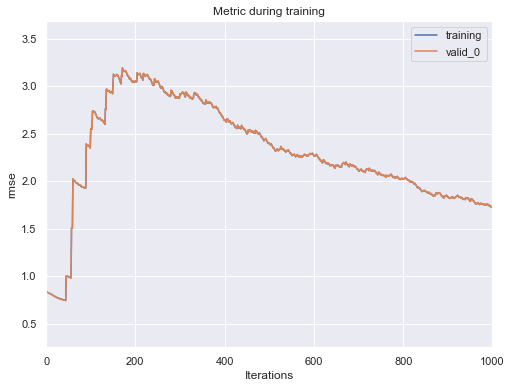

In [246]:
lgbm.plot_metric(lgbm_final_model)

{'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt',
 'verbosity': -1,
 'n_estimators': 289,
 'bagging_freq': 2,
 'learning_rate': 0.026793739782306238,
 'num_leaves': 126,
 'max_depth': 12,
 'subsample': 0.5692108144031295,
 'colsample_bytree': 0.8041267069698235,
 'min_data_in_leaf': 38}

In [ ]:
cross_val_score(estimator = lgbm_final_model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5)

In [ ]:
r_square_xgb = metrics.r2_score(y_train,y_pred_train_lgbm)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_train, y_pred_train_lgbm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_train, y_pred_train_lgbm)
print('MAE associated with XGBoost Regression is:', mae_xgb)


#### Final Tunning Attempt

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xdf_no_corr, ydf_log, test_size = 0.25, random_state=42)

dtrain = lgbm.Dataset(Xdf_no_corr, label=ydf_log)
dvalid = lgbm.Dataset(X_test, label=y_test)


class CustomMetric:
    """Metric that starts getting worse after the 4th iteration"""
    def __init__(self):
        self.scores = [1.0, 0.9, 0.8, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

    def __call__(self, y_true, y_pred):
        is_higher_better = False
        return "decreasing_metric", self.scores.pop(0), is_higher_better

params = {
    "verbosity": 1,
    "max_depth": 3,
    "num_leaves": 7,
    "min_data_in_leaf": 5,
}

# approach 1: use early_stopping() callback
bst_1 = lgbm.train(
    params=params,
    num_boost_round=10,
    train_set=dtrain,
    valid_sets=[dvalid],
    feval=CustomMetric(),
    callbacks=[
        lgbm.early_stopping(stopping_rounds=3),
        lgbm.log_evaluation(1)
    ]
)

# approach 2: pass "early_stopping_round" through paramms
bst_2 = lgbm.train(
    params={**params, "early_stopping_round": 3},
    num_boost_round=10,
    train_set=dtrain,
    valid_sets=[dvalid],
    feval=CustomMetric(),
    callbacks=[
        lgbm.log_evaluation(1)
    ]
)

#### Optuna LGB Tuner

In [236]:
import optuna.integration.lightgbm as lgbX
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold

In [235]:
# train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
dtrain = lgbX.Dataset(X_train, label=y_train)
dval = lgbX.Dataset(X_test, label=y_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "dart",
    "skip_drop": 0.7, #0.7,
    "n_estimators" : 200,
    "learning_rate":0.0969578156634451
}

model = lgbX.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[log_evaluation()],
)

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
accuracy = metrics.mean_squared_error(y_test, prediction, squared=False)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

NameError: name 'lgbX' is not defined

In [ ]:
best_params

In [ ]:
lgbm_final_model = lgbm.LGBMRegressor(**best_params)
# lgbm_final_model = lgbm.LGBMRegressor(**study.best_params)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_final_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_final_model.predict(X_test)

y_pred_train_lgbm = lgbm_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

In [ ]:

#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(Xdf_no_corr, ydf_log, test_size=0.25)
dtrain = lgbX.Dataset(train_x, label=train_y)
dval = lgbX.Dataset(val_x, label=val_y)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt", #gbdt
    "bagging_freq": 1,
#         'learning_rate': 0.004113181398416041,
#         'num_leaves': 143,
#         'subsample': 0.7393221055467546,
#         'colsample_bytree': 0.9038605306884863,
#         'min_data_in_leaf': 69,
}

tuner = lgbX.LightGBMTunerCV(
    params,
    dtrain,
    folds=KFold(n_splits=5),
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

#     model = lgbX.train(
#         params,
#         dtrain,
#         valid_sets=[dtrain, dval],
#         callbacks=[early_stopping(100), log_evaluation(100)],
#     )

#     prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
#     accuracy = metrics.r2_score(val_y, prediction)

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [ ]:
best_params['num_iterations'] = 60
# best_params['boosting_type'] = "dart"
print(best_params)

In [ ]:
lgbm_final_model = lgbm.LGBMRegressor(**best_params)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_final_model.fit(X_train, y_train,eval_metric='rmse',eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_final_model.predict(X_test)

y_pred_train_lgbm = lgbm_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

In [ ]:
lgbm.plot_metric(lgbm_final_model)

### Graph

Let graph the some data to showcase the model performance

In [230]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred_xgb_final,marker="+",truncate=False,line_kws={"color": "blue"})
sns.kdeplot(x=y_test,y=y_pred_xgb_final,fill=True, cmap="viridis") #mako

plt.plot([2, 7], [2, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

NameError: name 'y_pred_xgb_final' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "blue"})
sns.kdeplot(x=y_test,y=y_pred,fill=True, cmap="viridis") #mako

plt.plot([3, 7], [3, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha): Original", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.xlim(3,8)
plt.ylim(3,8)

In [ ]:
plt.figure() #plt.figure(figsize=(14,8))

sns.distplot(y_test,color='red', label = "Training Data")
sns.distplot(y_pred,color='blue', label = "Predicted Data")

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()

## Run BorutaShap

BorutaShap will be used to determine the most important features against the tuned XGBoost Model

In [ ]:
from BorutaShap import BorutaShap, load_data
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler


In [ ]:
# transformer = RobustScaler()#MinMaxScaler()#
# transformer.fit(Xdf_no_corr) #Xdf_no_corr

# X_noCorr_norm = transformer.transform(Xdf_no_corr) #Xdf_no_corr

In [ ]:
Xdf_no_corr

In [ ]:
noCorrColumns = list(Xdf_no_corr.columns) #Xdf_no_corr
noCorrColumns

In [ ]:
# Xdf_norm = pd.DataFrame(X_noCorr_norm, columns =noCorrColumns)
# Xdf_3= Xdf_norm[noCorrColumns]
# Xdf_3.head()

In [ ]:
model_prepepd = lgbm_model#xgb_final_model#cb_final_model#xgb_final_model#lgbm_model#xgb_final_model#HistGradientBoostingRegressor()#lgbm_model3

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_prepepd,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False, #Xdf_no_corr
                     train_or_test='train', normalize=False,
                     verbose=True)


# Feature_Selector.fit(X=Xdf_no_corr, y=ydf_log, n_trials=100, sample=False, #Xdf_no_corr
#                      train_or_test='train', normalize=False,
#                      verbose=True)

#train_or_test = 'test', 


In [ ]:
Feature_Selector.plot(which_features=('accepted'), figsize=(16,8), X_size = 10,y_scale='log')

In [ ]:
# save the results to csv filename is called feature_importance
Feature_Selector.results_to_csv(filename='E:\\GEDI\\EndGame\\Feature_Importance\\FINAL_GEDI_EE_Kenobi_FeatureImportance_LightGBM_DART_20240204')

In [ ]:
Xsubset = Feature_Selector.Subset()
len(Xsubset.columns)

In [ ]:
list(Xsubset.columns)

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf_log, test_size = 0.2, random_state=20) #Xdf or Xdf_no_corr
# import a library for spliting data into random train and test subsets

X_train.shape
X_test.shape
y_train.shape
y_test.shape

In [ ]:
statistics.variance(y_train)

In [ ]:
statistics.variance(y_test)

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
transformer = RobustScaler()#MinMaxScaler()#
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_train

In [ ]:
# importing Extreme Gradient Boosting from assemble module
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
xgb_model_Boruta = HistGradientBoostingRegressor()#HistGradientBoostingRegressor()

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
xgb_model_Boruta.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = xgb_model_Boruta.predict(X_test)

y_pred_train = xgb_model_Boruta.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", xgb_model_Boruta.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", xgb_model_Boruta.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

In [ ]:
# importing Extreme Gradient Boosting from assemble module
import lightgbm as lgbm
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
lgbm_model = lgbm.LGBMRegressor(n_estimators = 200,
                                boosting='dart',
                                skip_drop=.70, 
#                                 learning_rate=0.12,
                                objective = "rmse",
                                use_missing = False,
#                                  bagging_freq=2,
                                 learning_rate=0.0969578156634451,
#                                  num_leaves=500,
                                 max_depth =9,
                                 subsample =0.36757723146090926,
                                 colsample_bytree = 0.8510828195820848
#                                 early_stopping_rounds = 10
                               ) #boosting='gbdt'#objective='mse', seed=8798, num_threads=1

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=10)
 
# performing predictions on the test dataset
y_pred_lgbm = lgbm_model.predict(X_test)

y_pred_train_lgbm = lgbm_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", lgbm_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", lgbm_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_lgbm)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_lgbm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_lgbm)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier = HistGradientBoostingRegressor() #'gpu_hist'
# classifier = lgbm.LGBMRegressor()

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20
                        ,scoring='neg_root_mean_squared_error'
                        ,cv=10,verbose=3) #'r2'

# fitting it
clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
train_pool = cb.Pool(X_train, y_train)
test_pool = cb.Pool(X_test, y_test)

In [ ]:
# importing Extreme Gradient Boosting from assemble module
import catboost as cb
from catboost import CatBoostRegressor, Pool
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
cb_model = cb.CatBoostRegressor(loss_function='RMSE',iterations=5000, learning_rate=0.01) #objective='mse', seed=8798, num_threads=1

eval_pool = Pool(X_test, y_test)




# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
cb_model.fit(train_pool, eval_set=eval_pool, verbose=10, early_stopping_rounds=500)
 
# performing predictions on the test dataset
y_pred_cb = cb_model.predict(X_test)

y_pred_train_cb = cb_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", cb_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", cb_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_cb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb)

print(np.mean(ydf_log))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna

eval_pool = Pool(X_test, y_test)

#         "iterations": 2000,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.01),
#         'depth': trial.suggest_int('depth', 3, 12),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),

def objective(trial):
    params = {
        "iterations": 1500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 6, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.8, 3.0),
    }

    model = cb.CatBoostRegressor(**params, silent=True, loss_function='RMSE')
#     model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=10)
#     predictions = model.predict(X_test)
#     rmse = mean_squared_error(y_test, predictions, squared=False)
    score = -np.mean(cross_val_score(estimator = model, X=X_train,y=y_train,scoring='neg_root_mean_squared_error', cv =5))
    return score

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='minimize', sampler=sampler) #optuna.samplers.RandomSampler(seed= 42) #minimized is used because we want the smallest R2
study.optimize(objective, n_trials=30)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
bestParams = study.best_params

In [ ]:
bestParams['loss_function']='RMSE'
bestParams['iterations']=1375
bestParams

In [ ]:
cb_final_model = cb.CatBoostRegressor(**bestParams)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters

eval_pool = Pool(X_test, y_test)

cb_final_model.fit(train_pool,eval_set=eval_pool, verbose=10, early_stopping_rounds=15, plot=True)
 
# performing predictions on the test dataset
y_pred_cb = cb_final_model.predict(X_test)

y_pred_train_cb = cb_final_model.predict(X_train)

# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", cb_final_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", cb_final_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred_cb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb)

rms_xgb_train = metrics.mean_squared_error(y_train, y_pred_train_cb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_train)
mae_xgb_train = metrics.mean_absolute_error(y_train, y_pred_train_cb)
print('MAE associated with XGBoost Regression is:', mae_xgb_train)

print(np.mean(ydf_log))

# Error Analysis

In [ ]:
err = pd.read_csv("E:\\GEDI\\EndGame\\validation\\LightGBM_modelError_validation_Merged.csv")

In [ ]:
err

In [ ]:
err['elev_bins'] = list(pd.cut(err['FabDEM'], 4, retbins=False, labels=range(4)))

print(err.groupby('elev_bins')['diffABS'].mean().reset_index().to_string())
sns.catplot(data=err, x='elev_bins', y="diffABS", kind="box")
plt.show()

# Loading in Data

## Load in Raster Image

In [ ]:

# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\^Downloads\\20230414\\SR\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_SR.tif','r')





#This is just climate NA data
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_ClimateNA_Composite_2020.tif','r')

#This is just Kenobi SR with Lat/Lon (GOLD Version 70% accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wLatLon_Composite_2020.tif','r')

# # #This is just Kenobi with Lat/Lon & Excess GOLD 20230905
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wLatLon_wExcess_Composite_2020.tif','r')


# # #This is just Kenobi with Lat/Lon & TOA
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_TOA_Mediod_LandTrendr_wLatLon_Composite_2020.tif','r')


#This is just Kenobi with HLS
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\GeospatialData\\GEDI_Kenobi_HLS_v2.tif','r')

##This is just Kenobi SR with ecoRegions & latLon (70% Causes Streaking
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wLatLon_wEcoRegions_Composite_2020.tif','r')

##This is just Kenobi SR with ecoRegions (67% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wEcoRegions_Composite_2020.tif','r')

##This is just Kenobi SR with ecoRegions (67% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wEcoRegions_Composite_2020_v2.tif','r')

##GOLD This is just Kenobi SR with no EcoRegions (70% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\^Downloads\\20231025\\SR\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_SR_v2.tif','r')

##GOLD This is just Kenobi SR with no EcoRegions (70% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\^Downloads\\20231028\\SR\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_SR_v3.tif','r')

##This is just Kenobi TOA with texture (70% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\^Downloads\\20231029\\TOA\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_TOA_wTexture.tif','r')


##This is just Kenobi SR with ecoRegions with updated LatLon
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wEcoRegions_wUpdatedLatLon_Composite_2020.tif','r')

##This is just Kenobi TOA with texture (70% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open('E:\\GEDI\\LandTrendr\\GEDI_Kenobi_TOA_Mediod_LandTrendr_wLatLon_Composite_2020_v2.tif','r')

##This is just Kenobi TOA with tcDistBW texture (70% Accuracy)
# GEDI_EE_Biomass_ds = rasterio.open("E:\\GEDI\\LandTrendr\\_postProcessing\\02_GEE_wForestType\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_TOA_wTexture_wForestType_06_v05.tif",'r')

# # #GEDI_Kenobi_LandTrendr_wEcoRegions_wUpdatedLatLon_Composite_2020.tif
# outDirPath = "E:\\GEDI\\LandTrendr\\_postProcessing\\01_Mosaic" #### UPdate This!
# out_fp = os.path.join(outDirPath, "GEDI_EE_Kenobi_TOA_2020_Medoid_Round11_allBands.tif")

# outDirPath = "E:\\GEDI\\LandTrendr\\_postProcessing\\03_Mosaic_LT\\00_ML_Training" #### UPdate This!
# out_fp = os.path.join(outDirPath, "GEDI_EE_Kenobi_TOA_2020_MultiYear_LT_impFeatures_wLatLon.tif")

#GEDI_EE_Kenobi_BandDictionary_wTexture_wGNN_wLCMS_noElevDifference_wHydro_impFeatures_wLatLon_Test
#GEDI_EE_Kenobi_TOA_2020_Medoid_wTexture_wGNN_wLCMS_noElevDiff_wHydro_impFeatures_ModelPrep
#GEDI_EE_Kenobi_TOA_2020_Medoid_wTexture_wGNN_wLCMS_noElevDiff_wHydro_ModelPrep

test = "E:\\GEDI\\EndGame\\Imagery_Predictors\\test\\01_Mosaic\\GEDI_EE_Kenobi_TOA_Medoid_152_274_2019_2019_LT_featureImportance.tif"

GEDI_EE_Biomass_ds = rasterio.open(test)


# Feature Importance:
# GEDI_EE_Biomass_ds = rasterio.open("E:\\GEDI\\LandTrendr\\^Downloads\\20231106\\TOA\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_TOA_wTexture_wGNN_wLCMS_noElevDiff_impFeatures.tif")



In [ ]:
type(GEDI_EE_Biomass_ds)

In [ ]:
feature_names = list(GEDI_EE_Biomass_ds.descriptions)
feature_names

In [ ]:
GEDI_EE_Biomass_ds.shape

In [ ]:
[bands,rows,cols] = GEDI_EE_Biomass_ds.shape
print('reshaped')
print(bands)
print(rows)
print(cols)

In [ ]:
GEDI_EE_image = reshape_as_image(GEDI_EE_Biomass_ds) # reshape my numpy array
[bands,rows,cols] = GEDI_EE_image.shape
print('reshaped')
print(bands)
print(rows)
print(cols)

In [ ]:
print(GEDI_EE_image)

In [ ]:
array_sum=np.sum(GEDI_EE_image)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

In [ ]:
#shapefile = gpd.read_file('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Validation\\_Original_Samples\\GEDI_EE_Biomass_Samples_buffer_5m.shp')
# shapefile_old = gpd.read_file('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Geospatial_Data\\GEDI_EE_Biomass_Samples.shp')


## Load in Shapefile within Biomass Predictions

In [ ]:
### Below shapefile of 1km GEDI points from center
# shapefile = gpd.read_file('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Validation\\_Original_Samples\\GEDI_EE_Biomass_Samples_buffer_5m.shp')


### Below shapefile used the RAW GEDI Biomass Prediction that are used to generate the 1km GEDI Model
#shapefile = gpd.read_file('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Validation\\_Original_Samples\\UPDATE_GEDI_EE_Biomass_Samples_buffer_5m_20230109.shp')

# shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\GNN\\Feature_1_buffer.shp')
#shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\GNN\\Feature_2_buffer.shp')    ### GNN = 2
#shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\GNN\\Feature_3_buffer.shp')    ### GNN = 3

#shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\GNN\\GEDI_EE_Biomass_Samples_Complete_buffer_20230115.shp')

#shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\UPDATE_GEDI_EE_Biomass_Samples_20230116_Raster2Poly_SpatialJoin_F2P_Buffer.shp')

# shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\UPDATE_GEDI_EE_Biomass_Samples_buffer_5m_20230109_subset_JeffClallam_v4.shp')

# shapefile = gpd.read_file('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Traing_Data\\EE_Refresh\\GEDI_EE_Refresh_TrainingSamples_20230121_imageOnly.shp')

# shapefile = gpd.read_file('E:\\GEDI\\Samples\\05_NDVI_Buffer\\GEDI_EE_2019_Buffer_NDVI_Filter.shp')
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\GEDI_EE_2021_2019_Samples_clipped_proj_buffer_UTM10_Filtered.shp')

# ### Current Gold: ######
# shapefile = gpd.read_file('E:\GEDI\Samples\GEDI_EE_2021_2019_Samples_clipped_proj_buffer_UTM10_Filtered_f2p_refined.shp')


### Testing: #####
# shapefile = gpd.read_file('E:\GEDI\Samples\GEDI_EE_2021_2019_Samples_clipped_proj_buffer_UTM10_Filtered_f2p.shp')

# E:\GEDI\Samples\GEDI_EE_2021_2019_Samples_clipped_proj_buffer_UTM10_Filtered_f2p_refined

# ## Testing: #####
shapefile2 = gpd.read_file('E:\\GEDI\\Samples\\01_Project\\GEDI_EE_2019_2021_Summer_Reprj.shp')
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_PositiveValues.shp')
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_FULL_joinedAttributes_refined_version_03_moranGreaterThanNegOne.shp')
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_FULL_joinedAttributes_refined_version_03_moranPositive.shp')

# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_FULL_joinedAttributes_refined_version_03.shp')


###### BEfore MOrans I
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_FULL_joinedAttributes_refined_OutliersRemoved.shp')



##### GOLD 20231025
# shapefile = gpd.read_file('E:\\GEDI\\Samples\\08_outlierAnalysis\\GEDI_EE_Samples_OutlierAnalysis_FULL_joinedAttributes_refined_OutliersRemoved_OutlierAnalysis_moranPositive.shp')
shapefile = gpd.read_file("E:\\GEDI\\Samples\\GOLD\\GEDI_EE_Kenobi_SummerTime_Master_mlReady_kNeightbor.shp")


In [ ]:
type(shapefile)

In [ ]:
print(shapefile)

In [ ]:
shapefile.describe()

In [ ]:
print(GEDI_EE_Biomass_ds.crs)
print(shapefile.crs)

In [ ]:
len(shapefile)

In [ ]:
x = shapefile['agbd_1'].values   # agbd_update is GNN:1 = gdb = Lower, GNN: 2 = Upper, GNN 3: Mean // agbd_1 #shapefile

sns.histplot(x, color = 'blue');

# Calculating the mean
mean = shapefile['agbd_1'].mean()
print(mean)

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

plt.title("Histogram Outliers Removed: GEDI Biomass Samples (Mg/ha)", fontsize=18)
plt.xlabel("Biomass (Mg/ha)", fontsize=14)

plt.show()


### Use this variable [GEDI_Bioma]

In [ ]:
ax = sns.boxplot(x)

print('The meadian is: ', shapefile['agbd_1'].median())

plt.title("Boxplot: GEDI Biomass Samples (Mg/ha)", fontsize=18)
plt.xlabel("Biomass (Mg/ha)", fontsize=14)

# Notes:
# The line signifies the median
# The box in the middle show the beginning of Q1 (25th percentile) and the end of the Q3 (75th percentile)
# The whiskers (left - right) show the minimum quartile and maximum quartile
# The dots on the right are "outliers"

In [ ]:
x = shapefile['agbd_1'].values   # agbd_update is GNN:1 = gdb = Lower, GNN: 2 = Upper, GNN 3: Mean // agbd_1 #shapefile

sns.histplot(np.log(x), color = 'blue');

# Calculating the mean
mean = np.log(shapefile['agbd_1']).mean()
print(mean)

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

plt.title("Histogram Outliers Removed: GEDI Biomass Samples (Mg/ha)", fontsize=18)
plt.xlabel("Biomass (Mg/ha)", fontsize=14)


In [ ]:
mean = np.sqrt(shapefile['agbd_1']).mean()
mean

print(mean)

sns.histplot(np.sqrt(x), color = 'blue');

In [ ]:
percentile25 = shapefile['agbd_1'].quantile(0.25)
percentile75 = shapefile['agbd_1'].quantile(0.75)

iqr = percentile75-percentile25

In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print(upper_limit)
print(lower_limit)

In [ ]:
# shapefile_cleaned = shapefile[shapefile['MU'] <= 800] #GEDI_Master

In [ ]:
# shapefile_cleaned['MU']=np.sqrt((shapefile_cleaned['MU']))

In [ ]:
### Use MU_Prep_v2 (this has more decimal places)


x = np.log(shapefile['agbd_1']).values

sns.distplot(x, color = 'blue');

# Calculating the mean
mean = np.log(shapefile['agbd_1']).mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')


In [ ]:
ax = sns.boxplot(x)

print('The meadian is: ', shapefile['agbd_sqrt'].median())

# Notes:
# The line signifies the median
# The box in the middle show the beginning of Q1 (25th percentile) and the end of the Q3 (75th percentile)
# The whiskers (left - right) show the minimum quartile and maximum quartile
# The dots on the right are "outliers"

In [ ]:
### Use MU_Prep_v2 (this has more decimal places)


x = shapefile['agbd'].values

sns.distplot(x, color = 'blue');

# Calculating the mean
mean = shapefile['agbd'].mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

In [ ]:
ax = sns.boxplot(x)

print('The meadian is: ', shapefile['agbd_pi_lo'].median())

# Notes:
# The line signifies the median
# The box in the middle show the beginning of Q1 (25th percentile) and the end of the Q3 (75th percentile)
# The whiskers (left - right) show the minimum quartile and maximum quartile
# The dots on the right are "outliers"

For RS FRis Calibration Only

In [ ]:
x = shapefile['agbd_pi_hi'].values

sns.distplot(x, color = 'green');

# Calculating the mean
mean = shapefile['agbd_pi_hi'].mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

In [ ]:
ax = sns.boxplot(x)

print('The meadian is: ', shapefile['rs_fris_bi'].median())

# Notes:
# The line signifies the median
# The box in the middle show the beginning of Q1 (25th percentile) and the end of the Q3 (75th percentile)
# The whiskers (left - right) show the minimum quartile and maximum quartile
# The dots on the right are "outliers"

In [ ]:
x = shapefile['RsFrs_prep'].values

sns.distplot(x, color = 'purple');

# Calculating the mean
mean = shapefile['RsFrs_prep'].mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'red')

In [ ]:
ax = sns.boxplot(x)

print('The meadian is: ', shapefile['RsFrs_prep'].median())

# Notes:
# The line signifies the median
# The box in the middle show the beginning of Q1 (25th percentile) and the end of the Q3 (75th percentile)
# The whiskers (left - right) show the minimum quartile and maximum quartile
# The dots on the right are "outliers"

## Review & Prep Shapefile Data

In [ ]:
type(shapefile)

In [ ]:
shapefile["agbd_1"].describe()

In [ ]:
print(shapefile.columns.tolist())

In [ ]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] # first one
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

In [ ]:
type(feature)

## Extracting Values to SHP and Storing as Array

In [ ]:
# create empty numpy arrays to hold the X and y variables
X = np.array([], dtype=np.float32).reshape(0,65) # pixels for training #32 / 46 #34 Predictors
y = np.array([], dtype=np.float32) # labels for training GEDI Biomass

# extract the raster values within each point for the spring image
with GEDI_EE_Biomass_ds as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature. 
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all 18 bands - AKA not actually part of the shapefile
        #out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with XXX values for all 18 bands
        # this would be done to remove missing data values (if any)
        out_image_trimmed = out_image[:,~np.all(np.isnan(out_image), axis=0)] #out_image_trimmed
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["agbd_1"][index]] * out_image_reshaped.shape[0]) #agbd_1
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))  
        
### Just in Case
## with rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Modeling\\Images\\ModelBuilding\\GEDI_EE_Biomass_Variables_image_20230106.tif') as src:

In [ ]:
X[X==-32768]=np.nan
# X[X==-32768]=float(0)

In [ ]:
len(X[X==-32768])

In [ ]:
# y[y==-32768]=np.nan

In [ ]:
# len(X[np.isnan(y)])

## Save Numpy Arrays

In [ ]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
data1 = X
data2 = y
# save to npy file
save('E:\\GEDI\\Pipeline\\numpyArrays\\Training_X_20231023.npy', data1)
save('E:\\GEDI\\Pipeline\\numpyArrays\\GEDI_Kenobi_AGBD_Update_y_20231023.npy', data2)

In [ ]:
sns.distplot(np.sqrt(y), label = "Sqrt")
sns.distplot(np.log(y), label = "log")
sns.distplot(np.log10(y), label = "log10")

plt.legend()
plt.show()


In [ ]:
sns.distplot((y))

# Model Prep

In [ ]:
# y = np.sqrt(y)
y = np.log(y)



In [ ]:
sns.distplot(y)

In [ ]:
# labels = np.unique(shapefile["agbd_PAD"])
# print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
#                                                                 classes=labels))

# # We will need a "X" matrix containing our features, and a "y" array containing our labels
# print('Our GEDI Biomass X matrix is sized: {sz}'.format(sz=X.shape))
# print('Our GEDI Biomass y array is sized: {sz}'.format(sz=y.shape))

# print(X)
# print(y)


In [ ]:
array_sum=np.sum(X)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)


In [ ]:
X[np.isnan(X)] = float(0)

In [ ]:
array_sum=np.sum(X)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

In [ ]:
array_sum=np.sum(y)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)


In [ ]:
y[np.isnan(y)] = float(0)

In [ ]:
array_sum=np.sum(y)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)


## Split the Data in Training and Testing

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

## Normalize Data

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler

In [ ]:
transformer = RobustScaler()#MinMaxScaler()#
transformer.fit(X_train)

In [ ]:


X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
X_train

In [ ]:
X_test

## Polynormalize Features (Optional aka Test)

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# poly_reg = PolynomialFeatures(degree=3,include_bias=True)

In [ ]:
# X_train = poly_reg.fit_transform(X_train)

In [ ]:
# X_test = poly_reg.fit_transform(X_test)

## RS Fris Calibration (Optional)

In [ ]:
# create empty numpy arrays to hold the X and y variables
X_rs = np.array([], dtype=np.float32).reshape(0,42) # pixels for training
y_rs = np.array([], dtype=np.float32) # labels for training

# extract the raster values within each point for the spring image
with rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Modeling\\Images\\ModelBuilding\\GEDI_EE_Biomass_Variables_image_20220716.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature. 
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all 18 bands - AKA not actually part of the shapefile
        #out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with XXX values for all 18 bands
        # this would be done to remove missing data values (if any)
        out_image_trimmed = out_image[:,~np.all(np.isnan(out_image), axis=0)] #out_image_trimmed
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y_rs = np.append(y_rs,[shapefile["RsFrs_prep"][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X_rs = np.vstack((X_rs,out_image_reshaped))    

In [ ]:
sns.distplot(y_rs)

In [ ]:
labels = np.unique(shapefile["RsFrs_prep"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our GEDI Biomass X matrix is sized: {sz}'.format(sz=X_rs.shape))
print('Our GEDI Biomass y array is sized: {sz}'.format(sz=y_rs.shape))

print(X_rs)
print(y_rs)


In [ ]:
array_sum=np.sum(X_rs)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)


In [ ]:
X_rs[np.isnan(X_rs)] = float(0)

In [ ]:
array_sum=np.sum(X_rs)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

In [ ]:
array_sum=np.sum(y_rs)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)


In [ ]:
y_rs[np.isnan(y_rs)] = float(0)

In [ ]:
array_sum=np.sum(y_rs)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 80 % training dataset and 20 % test datasets
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, test_size = 0.2, random_state=42)

In [ ]:
X_train_rs.shape

In [ ]:
X_test_rs.shape

In [ ]:
y_train_rs.shape

In [ ]:
y_test_rs.shape

# Simplier Way to Assess Models

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgbm
import xgboost as xg

#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_test)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_test, yhat),3), round(mean_absolute_error(y_test, yhat),2), round(np.sqrt(mean_squared_error(y_test, yhat)),2)

algo=[GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor(), RandomForestRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))

#Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 80, 60, 55, 51, 45],  
              'max_depth': [7, 8],
              'reg_lambda' :[0.26, 0.25, 0.2]
             }
                
grid = GridSearchCV(xg.XGBRFRegressor(), param_grid, refit = True, verbose = 3, n_jobs=-1) #
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result=regr_trans.fit(X_train, y_train)
best_params=grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = xg.XGBRFRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], reg_lambda=best_params["reg_lambda"])
regr_trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
yhat = regr_trans.predict(X_test)

#evaluate metrics
r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))


# Light GBM

In [ ]:
# pip install optuna

In [ ]:
# importing all the necessary modules
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import <a href="https://techfor-today.com/gridsearchcv-for-hyperparameter-tuning-in-python/">GridSearchCV</a>
from numpy import arange

In [ ]:
# function for the validation of model
def evaluate_model(model, X_train, y_train):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    r_square = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return r_square

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500, 1000]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = lgbm.LGBMRegressor(n_estimators=i)
    
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = build_models()

# creating list
results, names = list(), list()

# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    R_square = evaluate_model(model, X_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(R_square)
    names.append(name)
    
    
    # printing the accuracy score
    print('Iterations (%s)---R-square( %.5f)' % (name, mean(R_square)))

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    models = dict()
    
    # explore features numbers from 1-5
    for i in range(1,29):
        
#         appending the models
        models[str(i)] = lgbm.LGBMRegressor(max_features=i)
    
#     returining the models
    return models

In [ ]:
# calling the function
models = build_models()

# creating the list
results, names = list(), list()

# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, X_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('---->Features(%s)---R_square( %.5f)' % (name, mean(R_square)))

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = lgbm.LGBMRegressor(subsample=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, X_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Samples(%s)---R_square( %.5f)' % (name, mean(R_square)))

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,12):
        
#         appending the models
        models[str(i)] = lgbm.LGBMRegressor(max_depth=i)
        
#   returining the model
    return models

In [ ]:
# calling the function
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    R_square = evaluate_model(model, X_train, y_train)
    
    # appending the results
    results.append(R_square)
    names.append(name)
    
#     printing the results
    print('Decision tree depth (%s)---R_square( %.5f)' % (name, mean(R_square)))

## Tune LGBM Model

In [ ]:
# defiing the model
model = lgbm.LGBMRegressor()


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]

# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]

# values for teh depth of tree
grid['max_depth'] = [5,6,7,8,9]

In [ ]:
# defining the cv
from sklearn.model_selection import GridSearchCV


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='r2')
# storing the values
lgbm_grid_result = grid_search.fit(X_train, y_train)
# printing the best parameters
print("Accuracy score: %f using %s" % (lgbm_grid_result.best_score_, lgbm_grid_result.best_params_))

## LGBM Accuracy

In [ ]:
# fiting the model with the best parameters

lgbm_final_model = lgbm.LGBMRegressor(learning_rate= 0.01, max_depth= 9, n_estimators= 500, subsample= 0.5)

### OLD

# # fiting the model with the best parameters
# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=0.7371026, colsample_bynode=0.7371026, colsample_bytree=0.7371026,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.0, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.05822502, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=9, max_leaves=1, min_child_weight=39,
#              monotone_constraints='()', n_estimators=500, n_jobs=1,
#              num_parallel_tree=1, predictor='auto', random_state=91,
#              reg_alpha=0, reg_lambda=1)



# fitting it
lgbm_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_lgbm_final = lgbm_final_model.predict(X_test) # X_test_filtered # X_test
#y_pred_lgbm_ROE_Only = lgbm_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# # Accuracy on Test
# print("Training Accuracy is: ", y_pred_lgbm_final.score(X_train, y_train))
# # Accuracy on Train
# print("Testing Accuracy is: ", y_pred_lgbm_final.score(X_test, y_test))

# r_square_lgbm_final = metrics.r2_score(y_test,y_pred_lgbm_final)
# print('R-Square Error associated with XGBoost Regression is:', r_square_lgbm_final)
# rms_lgbm_final = metrics.mean_squared_error(y_test, y_pred_lgbm_final, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_lgbm_final)

In [237]:
# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))

r_square_lgbm_final = metrics.r2_score(y_test,y_pred_lgbm_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_lgbm_final)
rms_lgbm_final = metrics.mean_squared_error(y_test, y_pred_lgbm_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lgbm_final)

Training Accuracy is:  0.9837644452791976
Testing Accuracy is:  0.9893053671142321


NameError: name 'y_pred_lgbm_final' is not defined

## EDCF Calibration

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [ ]:
y_train_EDM = ECDF(y_train)
y_pred_EDM_lgbm = ECDF(y_pred_lgbm_final)

In [ ]:
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
plt.plot(y_pred_EDM_lgbm.x, y_pred_EDM_lgbm.y, 'b')
plt.show()

In [ ]:
slope_changes = sorted(set(y_train))

In [ ]:
sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes, fill_value="extrapolate")

###, fill_value="extrapolate"

In [ ]:
Y_NEW_Pred_EDM_LGBM = inverted_edf(y_pred_EDM_lgbm(y_pred_lgbm_final))

In [ ]:
low_values_flags = Y_NEW_Pred_EDM_LGBM < 0  # Where values are low
Y_NEW_Pred_EDM_LGBM[low_values_flags] = 0  # All low values set to 0

In [ ]:
r_square_lgbm_final_b = metrics.r2_score(y_test,Y_NEW_Pred_EDM_LGBM)
print('R-Square Error associated with XGBoost Regression is:', r_square_lgbm_final_b)
rms_lgbm_final_b = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_LGBM, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lgbm_final_b)

### LGBM Testing

In [ ]:
import lightgbm as lgbm

In [ ]:
from sklearn import metrics 

In [ ]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {}  # to be filled in later
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(objective="regression", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            early_stopping_rounds=100,
        )
        preds = model.predict(X_test)
        cv_scores[idx] = preds

    return np.mean(cv_scores)

In [ ]:
def objective(trial, X, y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }


In [ ]:
from optuna.integration import LightGBMPruningCallback

In [ ]:


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(objective="regression", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "l2")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test)
        cv_scores[idx] = metrics.mean_squared_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regression")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
# fiting the model with the best parameters

lgbm_final_model = lgbm.LGBMRegressor(		n_estimators= 10000,
		learning_rate= 0.20407572010926367,
		num_leaves= 1120,
		max_depth= 12,
		min_data_in_leaf= 400,
		lambda_l1= 0,
		lambda_l2= 70,
		min_gain_to_split= 0.1500238772307263,
		bagging_fraction= 0.9,
		bagging_freq= 1,
		feature_fraction= 0.2)

### OLD

# # fiting the model with the best parameters
# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=0.7371026, colsample_bynode=0.7371026, colsample_bytree=0.7371026,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.0, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.05822502, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=9, max_leaves=1, min_child_weight=39,
#              monotone_constraints='()', n_estimators=500, n_jobs=1,
#              num_parallel_tree=1, predictor='auto', random_state=91,
#              reg_alpha=0, reg_lambda=1)



# fitting it
lgbm_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_lgbm_final = lgbm_final_model.predict(X_test) # X_test_filtered # X_test
#y_pred_lgbm_ROE_Only = lgbm_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy on Test
print("Training Accuracy is: ", lgbm_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", lgbm_final_model.score(X_test, y_test))

r_square_lgbm_final = metrics.r2_score(y_test,y_pred_lgbm_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_lgbm_final)
rms_lgbm_final = metrics.mean_squared_error(y_test, y_pred_lgbm_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lgbm_final)

# Random Forest Regression

In [ ]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
rf_model = RandomForestRegressor() #n_estimators = 50 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf_model.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# performing predictions on the test dataset
y_pred_train_rf = rf_model.predict(X_train)

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# Accuracy on Test
print("Training Accuracy is: ", rf_model.score(X_train, y_train))
# Accuracy on Train
rms_rfTrain = metrics.mean_squared_error(y_train, y_pred_train_rf, squared=False)
print('RMSE associated with Random Forest Regression is:', rms_rfTrain)
mae_rfTrain = metrics.mean_absolute_error(y_train, y_pred_train_rf)
print('MAE associated with Random Forest Regression is:', mae_rfTrain)



print("Testing Accuracy is: ", rf_model.score(X_test, y_test))

# Accuracy on Test vs Predicted
r_square = metrics.r2_score(y_test,y_pred_rf)
print('R-Square Error associated with Random Forest Regression is:', r_square)
rms = metrics.mean_squared_error(y_test, y_pred_rf, squared=False)
print('RMSE associated with Random Forest Regression is:', rms)

## Save RF Model

In [ ]:
outDirArray = "E:\\GEDI\\EndGame\\machineLearningFiles\\M2" #### UPdate This!
outArray = os.path.join(outDirArray, "M2_y_pred_log_RandomForest.npy")
outArrayTr = os.path.join(outDirArray, "M2_y_pred_train_log_RandomForest.npy")

np.save(outArray, y_pred_rf) # save # save
np.save(outArrayTr, y_pred_train_rf) # save # save

# new_num_arr = np.load('data.npy') # load

from sklearn import model_selection
import joblib

# save the model to disk
filename = os.path.join(outDirArray,'M2_GEDI_EE_Kenobi_impFeatures_RandomForest_log_20240124.sav')
joblib.dump(lgbm_model, filename) #xgb_final_model # xgb_model

outCSV_ytrain = os.path.join(outDirArray, "M2_y_train_log_RandomForest.csv")
outCSV_ytest = os.path.join(outDirArray, "M2_y_test_log_RandomForest.csv")
outCSV_Xtrain = os.path.join(outDirArray, "M2_X_train_RandomForest.csv")
outCSV_Xtest = os.path.join(outDirArray, "M2_X_test_RandomForest.csv")

y_train.to_csv(outCSV_ytrain)
y_test.to_csv(outCSV_ytest)
X_train.to_csv(outCSV_Xtrain)
X_test.to_csv(outCSV_Xtest)
# y_train
# new_num_arr = np.load('data.npy') # load

In [ ]:
import shap

In [ ]:
X_importance = X_test

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_importance)

In [ ]:
shap.summary_plot(shap_values, X_importance)

In [ ]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [ ]:
shap.dependence_plot("tcDistBW_savg",shap_values, X_importance)

In [ ]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [ ]:
importance_df.to_csv('E:\\GEDI\\GEDI_EE_Result\\borutaShap\\featureImportance\\feature_importance_FullSpectrum_KitchenSink_RandomForest_20231222.csv')

In [ ]:
X_importance.columns

In [ ]:
# Plot outputs
plt.scatter(y_test, y_pred, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred,fill=True, cmap="viridis") #mako

plt.plot([0, 7], [0, 7], color="orange")
plt.title("Random Forest Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

In [ ]:
plt.figure(figsize=(12,12))

sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "blue"})
plt.plot([5, 35], [5, 35])

## Tunning Random Forest for Potentially Better Results

In [ ]:
# # Tunning Random Forest

# from itertools import product
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
max_features = [1, 'sqrt', 'log2']
max_depth = [None, 2, 3, 4, 5]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [ ]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(param_grid)

In [ ]:
rf_Model = RandomForestRegressor()

In [ ]:

# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# grid_search = GridSearchCV(estimator = rf_Model, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train, y_train)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from optuna.samplers import TPESampler

# rf_Model = RandomForestRegressor()

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }


# clf =RandomizedSearchCV(rf_model,param_distributions=param_grid,n_iter=10
#                         ,scoring='neg_root_mean_squared_error'
#                         ,cv=10,verbose=3) #'r2'

# # fitting it
# clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna
from optuna.samplers import TPESampler

# Define objective function
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Return MAE
    return rmse

In [ ]:
sampler = TPESampler(seed=123)

# Create study object
study = optuna.create_study(direction="minimize", sampler=sampler)

# Run optimization process
study.optimize(objective, n_trials=30, show_progress_bar=True)

In [ ]:
best_params = study.best_params
best_params

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_Grid = RandomizedSearchCV(estimator = rf_Model, param_distributions=params,n_iter=10, cv = 10, verbose=2, n_jobs = 4)

In [ ]:
rf_Grid.fit(X_train, y_train)

In [ ]:
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

## Apply Best Random Forest Parameters to Model

In [ ]:
# creating a RF classifier
rf_final_model = RandomForestRegressor(**best_params)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf_final_model.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred_final = rf_final_model.predict(X_test)

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# Accuracy on Test
print("Training Accuracy is: ", rf_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf_final_model.score(X_test, y_test))

r_square = metrics.r2_score(y_test,y_pred_final)
print('R-Square Error associated with Random Forest Regression is:', r_square)
rms = metrics.mean_squared_error(y_test, y_pred_final, squared=False)
print('RSME associated with Random Forest Regression is:', rms)

In [ ]:
mse, bias, var = bias_variance_decomp(rf_final_model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=1, random_seed=42)

In [ ]:
bias*geoMean

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred_final,fill=True, cmap="viridis") #mako

plt.plot([0, 7], [0, 7], color="orange")
plt.title("Random Forest Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

## EDM Calibration

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [ ]:
y_train_EDM = ECDF(y_train)
y_pred_EDM = ECDF(y_pred_final)

In [ ]:
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
plt.plot(y_pred_EDM.x, y_pred_EDM.y, 'b')
plt.show()

In [ ]:
slope_changes = sorted(set(y_train))

In [ ]:
sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes, fill_value="extrapolate")

###, fill_value="extrapolate"

In [ ]:
Y_NEW_Pred_EDM_RF = inverted_edf(y_pred_EDM(y_pred_final))

In [ ]:
low_values_flags = Y_NEW_Pred_EDM_RF < 0  # Where values are low
Y_NEW_Pred_EDM_RF[low_values_flags] = 0  # All low values set to 0

In [ ]:
r_square_rf_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_RF)
print('R-Square Error associated with XGBoost Regression is:', r_square_rf_final)
rms_rf_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_RF, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_rf_final)

## Apply Best Model to Image to Create 2020 Biomass Map

In [ ]:
with rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\GEDI_Biomass_Image_DataAnalysis_2020_20220606.tif') as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    #img = src.read()[:, 1500:3000, 1500:3000]
    # this is the original data - not clipped
    img = src.read()

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# but first swap the order of dimensions (see above)
img[np.isnan(img)] = float(0)
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
rf_prediction = rf_final_model.predict(reshaped_img.reshape(-1, 53))

# Reshape our classification map back into a 2D matrix so we can visualize it
rf_prediction = rf_prediction.reshape(reshaped_img[:, :, 0].shape)
print(rf_prediction.shape)

In [ ]:
# EE_Boundary = gpd.read_file('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Geospatial_Data\\Emerald_Edge_Boundaries\\EE_extent_WA_and_OR_WGS84.shp')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(rf_prediction,cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
print(np.unique(rf_prediction)) # prints the unique class values
#class_results = rf_prediction.reshape(rows,cols)
print(rf_prediction.dtype)
print(rf_prediction.shape)

## Save the Results onto Local Machine

In [ ]:
# start generating variables used for writing the geotiff image
ds = rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\GEDI_Biomass_Image_DataAnalysis_2020_20220606.tif')
transform = ds.transform # transform parameters read from the original image
crs = ds.crs # CRS parameters read from the original image

# write the file in one go using all options
with rasterio.open(
    'C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\Results\\GEDI_EE_Biomass_2020.tif',
    'w',
    driver='GTiff',
    height=rf_prediction.shape[0],
    width=rf_prediction.shape[1],
    count=1,
    #dtype=rf_prediction.dtype,
    dtype = 'float64',
    crs = crs,
    transform=transform,
) as dst:
    dst.write(rf_prediction, 1)

In [ ]:
# check if the file exists
!gdalinfo GEDI_EE_Biomass_2020.tif

In [ ]:
from rasterio import plot

In [ ]:
GEDI_Biomass_2020 = rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\Results\\GEDI_EE_Biomass_2020.tif')
plt.figure(figsize=(20,20))
plot.show(GEDI_Biomass_2020,cmap=plt.cm.viridis)

# Let's Take the Model and Apply it to a new unseen Dataset

In [ ]:
with rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\GEDI_Biomass_Image_DataAnalysis_2015_20220606.tif') as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    #img = src.read()[:, 1500:3000, 1500:3000]
    # this is the original data - not clipped
    img_2015 = src.read()

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# but first swap the order of dimensions (see above)
img_2015[np.isnan(img_2015)] = float(0)
print(img_2015.shape)
reshaped_img_2015 = reshape_as_image(img_2015)
print(reshaped_img_2015.shape)

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
rf_prediction_2015 = rf_final_model.predict(reshaped_img_2015.reshape(-1, 53))

# Reshape our classification map back into a 2D matrix so we can visualize it
rf_prediction_2015 = rf_prediction_2015.reshape(reshaped_img_2015[:, :, 0].shape)
print(rf_prediction_2015.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(rf_prediction_2015,cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
# start generating variables used for writing the geotiff image
ds = rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\GEDI_Biomass_Image_DataAnalysis_20220603_v3_Refined.tif')
transform = ds.transform # transform parameters read from the original image
crs = ds.crs # CRS parameters read from the original image

# write the file in one go using all options
with rasterio.open(
    'C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Images\\Results\\GEDI_EE_Biomass_2015.tif',
    'w',
    driver='GTiff',
    height=rf_prediction_2015.shape[0],
    width=rf_prediction_2015.shape[1],
    count=1,
    #dtype=rf_prediction.dtype,
    dtype = 'float64',
    crs = crs,
    transform=transform,
) as dst:
    dst.write(rf_prediction_2015, 1)

In [ ]:
# check if the file exists
!gdalinfo GEDI_EE_Biomass_2015.tif
!gdalinfo GEDI_EE_Biomass_2020.tif

# XGBoost Regression

In [ ]:
# importing Extreme Gradient Boosting from assemble module
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
xgb_model = HistGradientBoostingRegressor()

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
xgb_model.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = xgb_model.predict(X_test)

In [ ]:
y_pred_train = xgb_model.predict(X_train)

In [ ]:
# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", xgb_model.score(X_train, y_train))
# rms_xgbTrain = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain)
# mae_xgbTrain = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain)


# Accuracy on Train
print("Testing Accuracy is: ", xgb_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred)
print('MAE associated with XGBoost Regression is:', mae_xgb)

In [ ]:
np.mean(y)

In [ ]:
plt.figure(figsize=(9,9))

p=sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "purple"})
p
plt.plot([0, 35], [0, 35])

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred,fill=True, cmap="viridis") #mako

plt.plot([0, 7], [0, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)


In [ ]:
from seaborn_qqplot import pplot

In [ ]:
ypredDF = pd.DataFrame(y_pred, columns={"agbd_predict"})
ytestDF = pd.DataFrame(y_test, columns={"agbd_test"})

masterDF2 = ytestDF.join(ypredDF,how='left').dropna()
len(masterDF2)
masterDF2.head()

In [ ]:
pplot(data=masterDF2,x='agbd_test',y='agbd_predict', kind="qq", height=8, 
      display_kws={"identity":True,
#                   "fit": True,
                  "reg": True,
                  "ci":3})

In [ ]:
sns.residplot(data=masterDF2,x='agbd_test',y='agbd_predict', lowess=True, line_kws=dict(color="red"))

In [ ]:
from scipy import stats

In [ ]:
s

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred,fill=True, cmap="viridis") #mako

plt.plot([3, 7], [3, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha): Original", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.xlim(3,8)
plt.ylim(3,8)

In [ ]:
xtemp = p.get_lines()[0].get_xdata()
ytemp = p.get_lines()[0].get_ydata()

f = np.polyfit(xtemp,ytemp, deg = 1)
#slope
f[0]

In [ ]:
plt.figure() #plt.figure(figsize=(14,8))

sns.distplot(y_test,color='red', label = "Training Data")
sns.distplot(y_pred,color='blue', label = "Predicted Data")

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()

## Tuning XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

# classifier=xgboost.XGBRegressor(tree_method='gpu_hist', seed = 42) #'gpu_hist'
classifier = HistGradientBoostingRegressor() #'gpu_hist'

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,
    #"min_child_weight":[1,3,5,7,9,11],
    #"gamma":[0.0,0.1,0.2,0.3,0.4],
    #"colsample_bytree":[0.4,0.5,0.6,0.7,0.8, 0.9]}#, #,0.4,0.5
    #"n_estimators": [100,250,500,750]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# clf =GridSearchCV(classifier,param_distributions=params,n_iter=10,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


# fitting it
clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
# fiting the model with the best parameters
xgb_final_model = lgbm.LGBMRegressor(**study.best_params)



# fitting it
xgb_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_xgb_final = xgb_final_model.predict(X_test) # X_test_filtered # X_test
y_pred_xgb_ROE_Only = xgb_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model.score(X_test, y_test))

r_square_xgb_final = metrics.r2_score(y_test,y_pred_xgb_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, y_pred_xgb_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost

# classifier=xgboost.XGBRegressor(tree_method='gpu_hist', seed = 42) #'gpu_hist'

# params={
#     "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
#     "max_depth":[2,3,4,5,6,8,10,12,15,20],
#     "min_child_weight":[1,3,5,7,9,11],
#     "gamma":[0.0,0.1,0.2,0.3,0.4],
#     "colsample_bytree":[0.4,0.5,0.6,0.7,0.8, 0.9], #,0.4,0.5
#     "n_estimators": [100,250,500,750]}

# clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# # source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# ## Hyper Parameter Optimization

# # fitting it
# clf.fit(X_train,y_train) #X_filtered #X_train

In [ ]:
print(clf.best_params_)
clf.best_estimator_

In [ ]:
# fiting the model with the best parameters
xgb_final_model = clf.best_estimator_

# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.2, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
#              monotone_constraints='()', n_estimators=55, n_jobs=0,
#              num_parallel_tree=1, predictor='auto', random_state=42,
#              reg_alpha=0, reg_lambda=1)

### OLD

# # fiting the model with the best parameters
# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=0.7371026, colsample_bynode=0.7371026, colsample_bytree=0.7371026,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.0, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.05822502, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=9, max_leaves=1, min_child_weight=39,
#              monotone_constraints='()', n_estimators=500, n_jobs=1,
#              num_parallel_tree=1, predictor='auto', random_state=91,
#              reg_alpha=0, reg_lambda=1)



# fitting it
xgb_final_model.fit(X_train,y_train) # X_filtered # X_train

y_pred_xgb_final = xgb_final_model.predict(X_test) # X_test_filtered # X_test
y_pred_xgb_ROE_Only = xgb_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# savedModel = 'E:\\GEDI\\savedModels\\GEDI_EE_Kenobi_XGB_tuned_20231106.sav'
# xgb_final_model = joblib.load(savedModel)

# y_pred_xgb_final = xgb_final_model.predict(X_test) # X_test_filtered # X_test
# y_pred_xgb_ROE_Only = xgb_final_model.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model.score(X_test, y_test))

r_square_xgb_final = metrics.r2_score(y_test,y_pred_xgb_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, y_pred_xgb_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
sns.scatterplot(x=y_test,y=y_pred_xgb_final, marker="+") #marker="+"

In [ ]:
plt.figure(figsize=(12,12))

sns.regplot(x=y_test,y=y_pred_xgb_final,marker="+",truncate=False,line_kws={"color": "blue"})
plt.plot([5, 32], [5, 32])

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred_xgb_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred_xgb_final,fill=True, cmap="viridis") #mako

plt.plot([0, 7], [0, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred_xgb_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test,y=y_pred_xgb_final,fill=True, cmap="viridis") #mako

plt.plot([3, 7], [3, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha): Original", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.xlim(3,8)
plt.ylim(3,8)

## BorutaShap

In [ ]:
from BorutaShap import BorutaShap, load_data
import pandas as pd

In [ ]:
transformer = MinMaxScaler()#MinMaxScaler()#
transformer.fit(X)

In [ ]:
X_norm = transformer.transform(X)

In [ ]:
BandDictionary = "E:\\GEDI\\_BandDictionary\\GEDI_EE_Kenobi_BandDictionary_allBands.csv"

In [ ]:
custom_dictionary = pd.read_csv(BandDictionary, delimiter = ",")
BandCount = len(custom_dictionary)
custom_dictionary_list = []

for i in custom_dictionary.values:
    custom_dictionary_list.append(list(i)[0])

custom_dictionary_list
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(custom_dictionary[51:62])

In [ ]:
X_norm

In [ ]:
# feature_names = [str(i) for i in range(0,50)]
# feature_names

# feature_names = ['blue','green','red','nir','swir1','swir2','NDVI','NBR','NDMI','NDSI','EVI','SAVI','NIRv',
#                  'brightness','greenness','wetness','tcAngleBG','tcAngleGW','tcAngleBW','tcDistBG','tcDistGW',
#                  'tcDistBW','tcDistBW_asm','tcDistBW_contrast','tcDistBW_corr','tcDistBW_var','tcDistBW_idm',
#                  'tcDistBW_savg','tcDistBW_svar','tcDistBW_sent','tcDistBW_ent','tcDistBW_dvar','tcDistBW_dent',
#                  'tcDistBW_imcorr1','tcDistBW_imcorr2','tcDistBW_maxcorr','tcDistBW_diss','sinAspect','cosAspect','tpi11',
#                  'tpi21','tpi41','aspect','slope','FabDEM','elevDiff','Hansen_treecover2000',
#                  'Hansen_NotDisturburbedForest','Hansen_DisturburbedForest','Hansen_NonForest','Douglas_Fir','HStF',
#                  'Red_Alder','Other_Hardwood','Red_Cedar','notHarvestable','nonForestType']

# len(feature_names)

feature_names = custom_dictionary_list
len(feature_names)

In [ ]:
Xdf = pd.DataFrame(X_norm, columns =feature_names)
Xdf_2= Xdf[feature_names]
Xdf_2.head()

In [ ]:
# Xdf = pd.DataFrame(X, columns =feature_names)
# Xdf_2= Xdf[feature_names]
# Xdf_2.head()

In [ ]:
y

In [ ]:
ydf = pd.DataFrame(y, columns={"agbd(log)"})
ydf_2=ydf["agbd(log)"]

In [ ]:
ydf2=pd.DataFrame(ydf)

In [ ]:
masterDF = Xdf.join(ydf,how='left').dropna()
len(masterDF)

In [ ]:
masterDF.head()

In [ ]:
import statsmodels.api as sm
# from scipy import shapiro

In [ ]:
# identifying all numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
n_variables = Xdf_2.select_dtypes(include=numerics).columns

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,5)})


for n in n_variables:
    x = Xdf_2[n].values
#     sns.distplot(x, color = 'blue');

    sm.qqplot(x, dist = stats.norm, fit=True, line = 'q')

    # Calculating the mean
    mean = Xdf_2[n].mean()

#     #ploting the mean
#     plt.axvline(mean, 0,1, color = 'red')
    plt.title(n)
#     plt.show()
    
    

    
    

### Testing Spectral Importance

In [ ]:
reflectanceNames = ['blue',	'green',	'red',	'nir',	'swir1',	'swir2',	'NDVI',	'NBR',	'NDMI',	'NDSI',	'EVI',	'SAVI',	'NIRv',	'brightness',	'greenness',	'wetness',	'tcAngleBG',	'tcAngleGW',	'tcAngleBW',	'tcDistBG',	'tcDistGW',	'tcDistBW']

In [ ]:
Xdf_2_reflectance= Xdf[reflectanceNames]
Xdf_2_reflectance.head()


### Looking for MultiCollineararity

In [ ]:
Xdf2 = masterDF[feature_names]
ydf2=masterDF['agbd(log)']

In [ ]:
corr = Xdf2.corr()
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(12,12))

corrPlot = sns.heatmap(corr,
                      cmap = sns.diverging_palette(220,10,as_cmap=True),
                      square=True, ax=ax)
ax.grid()
plt.title("Multicollinearity Amongst Predictors", fontsize=18)

#### Write a Function to Idnetify Features that are highly correlated

In [ ]:
def corr_drop(x,cut = 0.95):
    indNames = x.columns
    corr_matrix = x.corr().abs()
    
    corr_score =[corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score,reverse=True)
    sorted_indNames = [element for _,element in sorted_scores]
    
    x = x[sorted_indNames]
    corr.matrix = x.corr().abs()
    
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print("done")

In [ ]:
gedi_to_drop = corr_drop(masterDF[feature_names],cut = 0.95)
print('Correlated Variables', gedi_to_drop)
print(len(gedi_to_drop))

In [ ]:
gedi_to_drop_2 = ['blue', 'green', 'nir', 'NDVI', 'NBR', 'SAVI', 'NIRv', 'brightness', 
                  'tcDistBG', 'tcDistBW_asm', 'tcDistBW_contrast', 'tcDistBW_var', 
                  'tcDistBW_idm', 'tcDistBW_svar', 'tcDistBW_sent', 'tcDistBW_ent', 'tcDistBW_dent']

In [ ]:
Xdf2_no_corr = Xdf2.drop(columns = gedi_to_drop_2)
Xdf2_no_corr

In [ ]:
corr2 = Xdf2_no_corr.corr()
corr2 = corr2.where(np.tril(np.ones(corr2.shape), k=-1).astype(bool))

sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(12,12))

corrPlot2 = sns.heatmap(corr2,
                      cmap = sns.diverging_palette(220,10,as_cmap=True),
                      square=True, ax=ax)
ax.grid()
plt.title("Multicollinearity Amongst Predictors", fontsize=18)

### Run BorutaShap

In [ ]:
transformer = RobustScaler()#MinMaxScaler()#
transformer.fit(Xdf2_no_corr)

X_norm = transformer.transform(Xdf2_no_corr)

In [ ]:
X_norm

In [ ]:
noCorrColumns = list(Xdf2_no_corr.columns)
noCorrColumns

In [ ]:
Xdf_norm = pd.DataFrame(Xdf2_no_corr, columns =noCorrColumns)
Xdf_3= Xdf_norm[noCorrColumns]
Xdf_3.head()

In [ ]:
masterDF3 = Xdf_3.join(ydf,how='left').dropna()
len(masterDF3)
masterDF3.head()

### Rerun XGBoost with subset features

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(Xdf_3, ydf2, test_size = 0.3, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier = HistGradientBoostingRegressor() #'gpu_hist'

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20
                        ,scoring='neg_root_mean_squared_error'
                        ,cv=10,verbose=3) #'r2'

# fitting it
clf.fit(X_train_subset,y_train_subset) #X_filtered #X_train

In [ ]:
print(clf.best_params_)
clf.best_estimator_

In [ ]:
# fiting the model with the best parameters
xgb_final_model_subset = clf.best_estimator_

# fitting it
xgb_final_model_subset.fit(X_train_subset,y_train_subset) # X_filtered # X_train

y_pred_xgb_final_subset = xgb_final_model_subset.predict(X_test_subset) # X_test_filtered # X_test
# y_pred_xgb_ROE_Only = xgb_final_model_subset.predict(X_train_subset) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model_subset.score(X_train_subset, y_train_subset))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model_subset.score(X_test_subset, y_test_subset))

r_square_xgb_final = metrics.r2_score(y_test_subset,y_pred_xgb_final_subset)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test_subset, y_pred_xgb_final_subset, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

### Run Boruta Sharp on Tuned XGB Model

In [ ]:
ydf2.head()

In [ ]:
np.all(np.isnan(Xdf_3))

In [ ]:
model = xgb_final_model_subset#HistGradientBoostingRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

In [ ]:
Feature_Selector.fit(X=Xdf_3, y=ydf2, n_trials=100, sample=False,
                     train_or_test = 'train', normalize=False,
                     verbose=True)

In [ ]:
# plt.rcParams["figure.figsize"] = [30,30]

# fig_width, fig_height = plt.gcf().get_size_inches()
# fig = plt.figure(figsize=(fig_width*1.5,fig_height))

# f, ax = plt.subplots(figsize=(15,12))

# Returns Boxplot of features
Feature_Selector.plot(which_features='accepted',figsize=(15,8),X_size=10)


In [ ]:
# save the results to csv filename is called feature_importance
Feature_Selector.results_to_csv(filename='E:\\GEDI\\GEDI_EE_Result\\borutaShap\\featureImportance\\feature_importance_allBand_Final_20231111')

In [ ]:
Xsubset = Feature_Selector.Subset()
Xsubset

In [ ]:
# Xsubset = masterDF[feature_names].drop(columns=['elevDiff'])
# Xsubset

### Run XGBoost on Subset Variables

The first tuned maodel is expecting all features to be present. We need to make a new ML alogorithms for only the selected feaetures as defined by BorutaShap

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(Xdf2_no_corr, ydf2, test_size = 0.3, random_state=42)

In [ ]:
transformer2 = MinMaxScaler()#StandardScaler()#

In [ ]:
transformer2.fit(X_train_new)

X_train_new = transformer2.transform(X_train_new)
X_test_new = transformer2.transform(X_test_new)

In [ ]:
# importing Extreme Gradient Boosting from assemble module
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
xgb_model_2 = HistGradientBoostingRegressor()

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
xgb_model_2.fit(X_train_new, y_train_new)
 
# performing predictions on the test dataset
y_pred_new_2 = xgb_model_2.predict(X_test_new)

In [ ]:
y_pred_train_new = xgb_model_2.predict(X_train_new)

In [ ]:
# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# # Accuracy on Test
# print("Training Accuracy is: ", xgb_model.score(X_train_new, y_train_new))
# rms_xgbTrain_new = metrics.mean_squared_error(y_train_new, y_pred_train_new, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain_new)
# mae_xgbTrain_new = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain_new)


# Accuracy on Train
print("Testing Accuracy is: ", xgb_model_2.score(X_train_new, y_train_new))


r_square_xgb_new = metrics.r2_score(y_test_new,y_pred_new_2)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_new)
rms_xgb_new = metrics.mean_squared_error(y_test_new, y_pred_new_2, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_new)
mae_xgb_new = metrics.mean_absolute_error(y_test_new, y_pred_new_2)
print('MAE associated with XGBoost Regression is:', mae_xgb_new)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

# classifier=xgboost.XGBRegressor(tree_method='gpu_hist', seed = 42) #'gpu_hist'
classifier = HistGradientBoostingRegressor() #'gpu_hist'

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,
    #"min_child_weight":[1,3,5,7,9,11],
    #"gamma":[0.0,0.1,0.2,0.3,0.4],
    #"colsample_bytree":[0.4,0.5,0.6,0.7,0.8, 0.9]}#, #,0.4,0.5
    #"n_estimators": [100,250,500,750]}

clf_2 =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# clf =GridSearchCV(classifier,param_distributions=params,n_iter=10,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


# fitting it
clf_2.fit(X_train_new,y_train_new) #X_filtered #X_train

In [ ]:
# fiting the model with the best parameters
xgb_final_model_subset = clf_2.best_estimator_

# fitting it
xgb_final_model_subset.fit(X_train_new,y_train_new) # X_filtered # X_train

y_pred_xgb_final_subset = xgb_final_model_subset.predict(X_test_new) # X_test_filtered # X_test
y_pred_xgb_ROE_Only_subset = xgb_final_model_subset.predict(X_train_new) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model_subset.score(X_train_new, y_train_new))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model_subset.score(X_test_new, y_test_new))

r_square_xgb_final_2 = metrics.r2_score(y_test_new,y_pred_xgb_final_subset)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final_2)
rms_xgb_final_2 = metrics.mean_squared_error(y_test_new, y_pred_xgb_final_subset, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final_2)

### Boruta Shap Feature Importance

In [ ]:
model_prepepd = xgb_final_model_subset#HistGradientBoostingRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_prepepd,
                              importance_measure='shap',
                              classification=False)

In [ ]:
Feature_Selector.fit(X=Xdf2_no_corr, y=ydf2, n_trials=100, sample=True,
                     train_or_test='train', normalize=False,
                     verbose=True)

#train_or_test = 'test', 

In [ ]:
Feature_Selector.plot(which_features='all', figsize=(16,8), X_size = 12)

In [ ]:
# save the results to csv filename is called feature_importance
Feature_Selector.results_to_csv(filename='E:\\GEDI\\GEDI_EE_Result\\borutaShap\\featureImportance\\feature_importance_wUpdatedTExture_wGNN_wLCMS_wHydro_notNormalized')

### Rerun Model using Subset of most important Features

In [ ]:
Xsubset = Feature_Selector.Subset()
len(Xsubset.columns)

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(Xsubset, ydf2, test_size = 0.3, random_state=42)

In [ ]:
transformer2 = MinMaxScaler()#StandardScaler()#

transformer2.fit(X_train_new)

X_train_new = transformer2.transform(X_train_new)
X_test_new = transformer2.transform(X_test_new)


In [ ]:
# importing Extreme Gradient Boosting from assemble module
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
xgb_model_2 = HistGradientBoostingRegressor()

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
xgb_model_2.fit(X_train_new, y_train_new)
 
# performing predictions on the test dataset
y_pred_new_2 = xgb_model_2.predict(X_test_new)

In [ ]:
# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# # Accuracy on Test
# print("Training Accuracy is: ", xgb_model.score(X_train_new, y_train_new))
# rms_xgbTrain_new = metrics.mean_squared_error(y_train_new, y_pred_train_new, squared=False)
# print('RMSE associated with XGBoost Regression is:', rms_xgbTrain_new)
# mae_xgbTrain_new = metrics.mean_absolute_error(y_train, y_pred_train)
# print('MAE associated with XGBoost Regression is:', mae_xgbTrain_new)


# Accuracy on Train
print("Testing Accuracy is: ", xgb_model_2.score(X_test_new, y_test_new))


r_square_xgb_new = metrics.r2_score(y_test_new,y_pred_new_2)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_new)
rms_xgb_new = metrics.mean_squared_error(y_test_new, y_pred_new_2, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_new)
mae_xgb_new = metrics.mean_absolute_error(y_test_new, y_pred_new_2)
print('MAE associated with XGBoost Regression is:', mae_xgb_new)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

# classifier=xgboost.XGBRegressor(tree_method='gpu_hist', seed = 42) #'gpu_hist'
classifier = HistGradientBoostingRegressor() #'gpu_hist'

params={
    "learning_rate":[0.01,0.05,0.10],#0.15,0.20,0.25,0.30
    "max_depth":[3,6,9,12,15],
    "max_iter":[100,500,1000],
    "min_samples_leaf":[20,35,50,65]
}#,
    #"min_child_weight":[1,3,5,7,9,11],
    #"gamma":[0.0,0.1,0.2,0.3,0.4],
    #"colsample_bytree":[0.4,0.5,0.6,0.7,0.8, 0.9]}#, #,0.4,0.5
    #"n_estimators": [100,250,500,750]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=20,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# clf =GridSearchCV(classifier,param_distributions=params,n_iter=10,scoring='neg_root_mean_squared_error',cv=10,verbose=3) #'r2'
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


# fitting it
clf.fit(X_train_new,y_train_new) #X_filtered #X_train

In [ ]:
print(clf.best_params_)
clf.best_estimator_

In [ ]:
# fiting the model with the best parameters
xgb_final_model = clf.best_estimator_

# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.2, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
#              monotone_constraints='()', n_estimators=55, n_jobs=0,
#              num_parallel_tree=1, predictor='auto', random_state=42,
#              reg_alpha=0, reg_lambda=1)

### OLD

# # fiting the model with the best parameters
# import xgboost
# xgb_final_model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
#              colsample_bylevel=0.7371026, colsample_bynode=0.7371026, colsample_bytree=0.7371026,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, gamma=0.0, gpu_id=0, grow_policy='depthwise',
#              importance_type=None, interaction_constraints='',
#              learning_rate=0.05822502, max_bin=256, max_cat_to_onehot=4,
#              max_delta_step=0, max_depth=9, max_leaves=1, min_child_weight=39,
#              monotone_constraints='()', n_estimators=500, n_jobs=1,
#              num_parallel_tree=1, predictor='auto', random_state=91,
#              reg_alpha=0, reg_lambda=1)



# fitting it
xgb_final_model.fit(X_train_new,y_train_new) # X_filtered # X_train

y_pred_xgb_final = xgb_final_model.predict(X_test_new) # X_test_filtered # X_test
y_pred_xgb_ROE_Only = xgb_final_model.predict(X_train_new) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model.score(X_train_new, y_train_new))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model.score(X_test_new, y_test_new))

r_square_xgb_final = metrics.r2_score(y_test_new,y_pred_xgb_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test_new, y_pred_xgb_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test_new,y=y_pred_xgb_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.kdeplot(x=y_test_new,y=y_pred_xgb_final,fill=True, cmap="viridis") #mako

plt.plot([0, 7], [0, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha)", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

## Boruta Feature Importance

In [ ]:
from boruta import BorutaPy

In [ ]:
# importing random forest classifier from assemble module
import xgboost as xgb

# creating a RF classifier
model = xgb.XGBRegressor()

In [ ]:
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

In [ ]:
feat_selector.fit(X, y)

In [ ]:
# check selected features
print(feat_selector.support_)  #Should we accept the feature

# check ranking of features
print(feat_selector.ranking_) #Rank 1 is the best


In [ ]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)  #Apply feature selection and return transformed data

In [ ]:
# zip feature names, ranks, and decisions 
feature_ranks = list(zip(feature_names,
                         feat_selector.ranking_, 
                         feat_selector.support_))

In [ ]:
for feat in feature_ranks:
    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

In [ ]:
X_filtered.shape

In [ ]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size = 0.3, random_state=42)


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

transformer = StandardScaler()#MinMaxScaler()

transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train

X_test

In [ ]:
# importing Extreme Gradient Boosting from assemble module
from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.metrics import plot_confusion_matrix

# creating a RF classifier
xgb_model = HistGradientBoostingRegressor()

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
xgb_model.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = xgb_model.predict(X_test)

In [ ]:
# Accuracy
from sklearn import metrics 
# from sklearn.linear_model import LinearRegression


# Accuracy on Test
print("Training Accuracy is: ", xgb_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_model.score(X_test, y_test))


r_square_xgb = metrics.r2_score(y_test,y_pred)
print('R-Square Error associated with Random Forest Regression is:', r_square_xgb)
rms_xgb = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('RMSE associated with Random Forest Regression is:', rms_xgb)
mse_xgb = metrics.mean_squared_error(y_test, y_pred, squared=True)
print('MSE associated with Random Forest Regression is:', mse_xgb)

## One other Tunning Method

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)

# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', reg.score(X_test, y_test) )
print('The RMSE  on the testing dataset is: ',metrics.mean_squared_error(y_test, reg.predict(X_test), squared=False))


In [ ]:
# optimizing XGBoost Regressor

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

params = { 'max_depth': [3,6,9,12],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

In [ ]:
xgbr = xgb.XGBRegressor(seed = 20, colsample_bytree = 0.7, learning_rate= 0.01, max_depth=6, n_estimators=1000)
xgbr.fit(X_train, y_train)
xgbr

In [ ]:
y_pred = xgbr.predict(X_train)

In [ ]:
# Model Accuracy on testing dataset
print('The Accuracy  on the testing dataset is: ', xgbr.score(X_test, y_test) )
print('The RMSE  on the testing dataset is: ',metrics.mean_squared_error(y_test, xgbr.predict(X_test), squared=False))

## Try SCIKIT Learn Optimize

In [ ]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', xgboost.XGBRegressor(tree_method='gpu_hist', seed = 42)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='r2', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

In [ ]:
opt.fit(X_train,y_train)

In [ ]:
opt.best_estimator_

In [ ]:
xgb_final_model2 = opt.best_estimator_

In [ ]:
# fitting it
xgb_final_model2.fit(X_train,y_train) # X_filtered # X_train

y_pred_xgb_final2 = xgb_final_model2.predict(X_test) # X_test_filtered # X_test
y_pred_xgb_ROE_Only2 = xgb_final_model2.predict(X_train) # X_test_filtered # X_test

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", xgb_final_model2.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", xgb_final_model2.score(X_test, y_test))

r_square_xgb_final = metrics.r2_score(y_test,y_pred_xgb_final2)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, y_pred_xgb_final2, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
plt.figure(figsize=(12,12))

sns.regplot(x=y_test,y=y_pred_xgb_final2,marker="+",truncate=False,line_kws={"color": "blue"})
plt.plot([5, 35], [5, 35])

In [ ]:
opt.best_score_

In [ ]:
opt.score(X_test, y_test)

In [ ]:
opt.predict(X_test)

In [ ]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

## Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

## Save Model

In [ ]:
os.getcwd()

In [ ]:
os.chdir('E:\\GEDI\\EndGame\\mlAlgorithms')

In [ ]:
from sklearn import model_selection
import joblib

In [ ]:
# save the model to disk
filename = 'GEDI_EE_Kenobi_impFeatures_LightGBM_dart_altImpFeatures_v4_20240118.sav'
joblib.dump(lgbm_model, filename) #xgb_final_model # xgb_model

In [ ]:
import os
cwd = os.getcwd()
cwd

## Empirical Distribution Matching (EDM)

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress

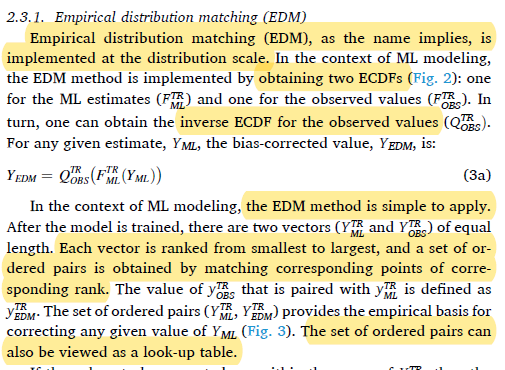

### Using Original GEDI for Calibration

In [ ]:
# y_pred_xgb_final = lgbm_model#y_pred_cb
y_pred = y_pred_lgbm
# # joblib.load(savedModel)

In [ ]:
algo = "E:\\GEDI\\EndGame\\mlAlgorithms\\Master_GEDI_EE_Kenobi_impFeatures_LightGBM_DART_FINAL_v9999_20240118.sav"
y_predArray = "E:\\GEDI\\EndGame\\mlAlgorithms\\arraysEDM\\y_pred_LightGBM_DART_FINAL_v9999.npy"
y_trainCSV = "E:\\GEDI\\EndGame\\mlAlgorithms\\arraysEDM\\y_train_LightGBM_DART_v9999.csv"
y_testCSV = "E:\\GEDI\\EndGame\\mlAlgorithms\\arraysEDM\\y_test_LightGBM_DART_v9999.csv"

y_pred_xgb_final = joblib.load(algo)
y_pred = np.load(y_predArray)
y_train = pd.read_csv(y_trainCSV, index_col=0).squeeze()
y_test = pd.read_csv(y_testCSV, index_col=0).squeeze()


In [ ]:
# y_train= np.exp(y_train)*1.0274525549473057
# y_pred = np.exp(y_pred)*1.0274525549473057
# y_train= np.exp(y_train)*1.0274525549473057
# y_pred = np.exp(y_pred)*1.0274525549473057

In [ ]:
y_train_EDM = ECDF(y_train)
y_pred_EDM_xgb = ECDF(y_pred) #y_pred_xgb_final, y_pred

In [ ]:
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r', label = "EDM of Training Data" )
plt.plot(y_pred_EDM_xgb.x, y_pred_EDM_xgb.y, 'b', label = "EDM of Predicted Data")

plt.title("EDM Graph: Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass", fontsize=14)
plt.ylabel("EDM Percent", fontsize=14)


plt.legend()
plt.show()

In [ ]:
sns.distplot((y_pred))
sns.distplot((y_train))

In [ ]:
yC = y_train_EDM.y[y_train_EDM.y<=y_train_EDM(np.max(y_pred))] #0.9358594258442403
yC = yC[yC>y_train_EDM(np.min(y_pred))] #0.0011569889362932967



yxc = y_train_EDM.x[y_train_EDM.x<=np.max(y_pred)] #6.441746541266725
yxc = yxc[yxc>=np.min(y_pred)]

In [ ]:
plt.plot(yxc, yC, 'r', label = "EDM of Training Data" , linewidth = 3)
plt.plot(y_pred_EDM_xgb.x, y_pred_EDM_xgb.y, 'b', label = "EDM of Predicted Data")
# plt.plot(y_train_EDM2.x, y_train_EDM2.y, 'g', label = "TRain 2" )


plt.title("EDM Graph: Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass", fontsize=14)
plt.ylabel("EDM Percent", fontsize=14)


plt.legend()
plt.show()

In [ ]:
slope_changes = sorted(set(yxc))

sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes,slope_changes, fill_value="extrapolate", kind="linear")#fill_value="extrapolate") #fill_value="extrapolate"

Y_NEW_Pred_EDM_lgbm = inverted_edf(y_pred_EDM_xgb(y_pred)) #y_pred_xgb_final / y_pred

# low_values_flags = Y_NEW_Pred_EDM_lgbm2 < 0  # Where values are low
# Y_NEW_Pred_EDM_lgbm2[low_values_flags] = 0  # All low values set to 0

In [ ]:
y_pred_corrected_lgbm = ECDF(Y_NEW_Pred_EDM_lgbm)

In [ ]:
# plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
plt.plot(y_pred_EDM_xgb.x, y_pred_EDM_xgb.y, 'b')
plt.plot(y_pred_corrected_lgbm.x, y_pred_corrected_lgbm.y, 'purple', linewidth=3)
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')

plt.show()

In [ ]:
sns.distplot(Y_NEW_Pred_EDM_lgbm)

In [ ]:
Y_NEW_Pred_EDM_lgbm

In [ ]:
slope_changes = sorted(set(y_train))

In [ ]:
sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes,fill_value="extrapolate")

###, fill_value="extrapolate"

In [ ]:
inverted_edf

In [ ]:
Y_NEW_Pred_EDM_xgb = inverted_edf(y_pred_EDM_xgb(y_pred)) #y_pred_xgb_final / y_pred
Y_train_EDM_xgb = inverted_edf(y_pred_EDM_xgb(y_train)) #y_pred_xgb_final / y_pred

In [ ]:
low_values_flags = Y_NEW_Pred_EDM_xgb < 0  # Where values are low
Y_NEW_Pred_EDM_xgb[low_values_flags] = 0  # All low values set to 0

In [ ]:
sns.histplot(y_test, color = 'red');

In [ ]:
sns.histplot(y_pred, color = 'green');

In [ ]:
sns.histplot(y_pred_corrected_lgbm, color = 'blue');

In [ ]:
y_pred_corrected_xgb = ECDF(Y_NEW_Pred_EDM_xgb)

In [ ]:
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
plt.plot(y_pred_EDM_xgb.x, y_pred_EDM_xgb.y, 'b')
plt.plot(y_pred_corrected_xgb.x, y_pred_corrected_xgb.y, 'purple')

plt.show()

In [ ]:
sns.histplot(y_test, color = 'red');

In [ ]:
sns.scatterplot(x=y_test, y = Y_NEW_Pred_EDM)

In [ ]:
sns.scatterplot(x=y_test, y = y_pred)

In [ ]:
min(Y_NEW_Pred_EDM)

In [ ]:


r_square_xgb_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_xgb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_xgb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_xgb, squared=True)
print('MSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
fig, axs = plt.subplots()
sns.distplot(masterdf['agbd'], ax=axs, color = 'r')
sns.distplot(np.exp(Y_NEW_Pred_EDM_xgb))



In [ ]:
sns.scatterplot(x=masterdf['agbd'], y = np.exp(Y_NEW_Pred_EDM_xgb))

In [ ]:
plt.figure() #plt.figure(figsize=(14,8))

sns.distplot(Y_NEW_Pred_EDM_xgb,color='red', label = "Training Data")
sns.distplot(np.exp(Y_NEW_Pred_EDM_xgb),color='blue', label = "test Data")

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()

In [ ]:
# sns.histplot(np.exp(Y_NEW_Pred_EDM_xgb))

In [ ]:
plt.figure(figsize=(9,9))

q=sns.regplot(y_test,Y_NEW_Pred_EDM_xgb,marker="+",truncate=False,line_kws={"color": "purple"})
q
plt.plot([0, 7], [0, 7])

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,marker="+",truncate=False,line_kws={"color": "blue"})
sns.kdeplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,fill=True, cmap="viridis") #mako

plt.plot([2, 7], [2, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha): EDM Calibration", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)


In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,marker="+",truncate=False,line_kws={"color": "blue"})
sns.kdeplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,fill=True, cmap="viridis") #mako

plt.plot([3, 7], [3, 7], color="orange")
plt.title("XGBoost Biomass Predictions log(Mg/ha): EDM Calibration", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.xlim(2,8)
plt.ylim(2,8)

In [ ]:
ypredEDM_DF = pd.DataFrame(Y_NEW_Pred_EDM_xgb, columns={"agbd_predict_EDM"})
ytestDF = pd.DataFrame(y_test, columns={"agbd_test"})

masterDF3 = ytestDF.join(ypredEDM_DF,how='left').dropna()
len(masterDF3)
masterDF3.head()

In [ ]:
pplot(data=masterDF3,x='agbd_test',y='agbd_predict_EDM', kind="qq", height=8, 
      display_kws={"identity":True,
#                   "fit": True,
                  "reg": True,
                  "ci":3})

In [ ]:
sns.residplot(data=masterDF3,x='agbd_test',y='agbd_predict_EDM', lowess=True, line_kws=dict(color="red"))
plt.xlim(0,7)
plt.ylim(-2.5,2.5)

In [ ]:
xtempEDM = q.get_lines()[0].get_xdata()
ytempEDN = q.get_lines()[0].get_ydata()

f = np.polyfit(xtempEDM,ytempEDN, deg = 1)
#slope
f[0]

In [ ]:
plt.figure(figsize=(14,8))

sns.distplot(y_test,color='red', label = "Distribution of Training Data")
# sns.distplot(y_pred,color='blue')
sns.distplot(Y_NEW_Pred_EDM_xgb,color="blue",label = 'Distribution of EDM Predicted Data')

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()


In [ ]:
# save the model to disk
filename = 'GEDI_Kenobi_XGB_finalized_calibratedEDM_20231023.sav'
joblib.dump(xgb_final_model_calibrated, filename)

### Using RS Fris for Calibration

In [ ]:
y_train_EDM = ECDF(y_train)
y_pred_EDM_xgb = ECDF(y_pred_xgb_final)
y_train_EDM_rs = ECDF(y_train_rs)


In [ ]:
plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
plt.plot(y_pred_EDM_xgb.x, y_pred_EDM_xgb.y, 'b')
plt.plot(y_train_EDM_rs.x, y_train_EDM_rs.y, 'g')

plt.show()

In [ ]:
slope_changes_rs = sorted(set(y_train_rs))

In [ ]:
sample_edf_values_at_slope_changes_rs = [ y_train_EDM_rs(item) for item in slope_changes_rs]
inverted_edf_rs = interp1d(sample_edf_values_at_slope_changes_rs, slope_changes_rs, fill_value="extrapolate")

###, fill_value="extrapolate"

In [ ]:
Y_NEW_Pred_EDM_xgb_RS = inverted_edf_rs(y_pred_EDM_xgb(y_pred_xgb_final))

In [ ]:
low_values_flags = Y_NEW_Pred_EDM_xgb_RS < 0  # Where values are low
Y_NEW_Pred_EDM_xgb_RS[low_values_flags] = 0  # All low values set to 0

In [ ]:
sns.histplot(y_test, color = 'red');

In [ ]:
sns.histplot(y_pred_xgb_final, color = 'green');

In [ ]:
sns.histplot(Y_NEW_Pred_EDM_xgb_RS, color = 'blue');

In [ ]:
r_square_xgb_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_xgb_RS)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_xgb_RS, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)

## Regression of Observed on Estimated Values (ROE)

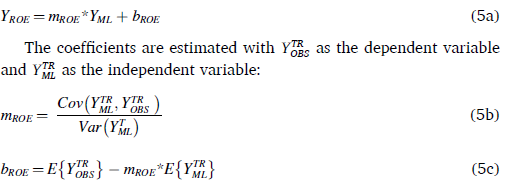

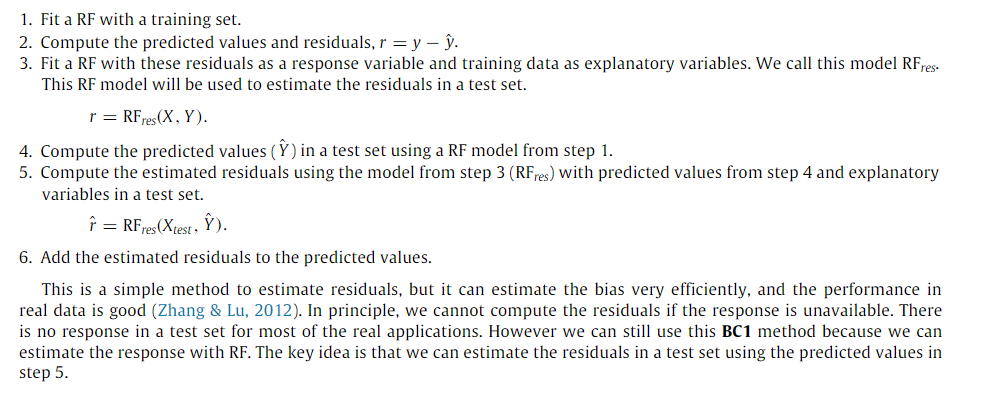

In [ ]:
#Part 01 & 02
model = rf_model #lgbm_model #cb_final_model #rf_model


Y_tr_ML = model.predict(X_train)
Y_tr_ML = np.float32(Y_tr_ML)
Y_tr_ML.shape

In [ ]:
Y_tr_ML

In [ ]:
y_train

In [ ]:
# Part 06 Simple Linear Regression
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(Y_tr_ML.reshape(-1, 1),y_train)
reg
# sns.regplot(x=y_pred_lgbm_res.reshape(-1, 1), y=resid2.reshape(-1, 1));
# sns.regplot(x=resid2.reshape(-1, 1), y=y_pred_lgbm_res.reshape(-1, 1));

In [ ]:
#Part 04
Y_T_ML = model.predict(X_test) #Predicting AGBD with Test Data
Y_T_ML = np.float32(Y_T_ML)
Y_T_ML.shape

In [ ]:
y_final = reg.predict(Y_T_ML.reshape(-1, 1))

In [ ]:
sns.distplot(np.exp(y_test)*1.0274525549473057)
# sns.distplot(np.exp(y_pred)*1.0274525549473057)
sns.distplot(np.exp(y_final)*1.0257832084050662)
# sns.distplot(np.exp(Y_NEW_Pred_EDM_xgb)*1.022683900141831)


In [ ]:
y_finalTrain = reg.predict(Y_tr_ML.reshape(-1, 1))

In [ ]:
r_square_ROE = metrics.r2_score(y_test,y_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_ROE)
rms_xgb_ROE = metrics.mean_squared_error(y_test, y_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_ROE)

In [ ]:
outDirArray = "E:\\GEDI\\EndGame\\machineLearningFiles\\M2" #### UPdate This!
# outArray = os.path.join(outDirArray, "M1c_y_pred_log_LightGBM_DART.npy")

# np.save(outArray, y_pred_rf) # save # save

# # new_num_arr = np.load('data.npy') # load

from sklearn import model_selection
import joblib

# save the model to disk
filename = os.path.join(outDirArray,'M2_residualSLR_GEDI_EE_Kenobi_impFeatures_RandomForest_log_20240124.sav')
joblib.dump(reg, filename) #xgb_final_model # xgb_model

# outCSV_ytrain = os.path.join(outDirArray, "M2_y_train_log_RandomForest.csv")
# outCSV_ytest = os.path.join(outDirArray, "M2_y_test_log_RandomForest.csv")
# outCSV_Xtrain = os.path.join(outDirArray, "M2_X_train_RandomForest.csv")
# outCSV_Xtest = os.path.join(outDirArray, "M2_X_test_RandomForest.csv")

# y_train.to_csv(outCSV_ytrain)
# y_test.to_csv(outCSV_ytest)
# X_train.to_csv(outCSV_Xtrain)
# X_test.to_csv(outCSV_Xtest)
# # y_train
# # new_num_arr = np.load('data.npy') # load

In [ ]:
Y_tr_OBS = y_train
Y_tr_OBS = np.float32(Y_tr_OBS)
Y_tr_OBS.shape

In [ ]:
#Part 03: Compute Residuals
residual = (y_train - Y_tr_ML)

# creating a RF classifier
lgbm_model_res = lgbm.LGBMRegressor(n_estimators = 200,
                                boosting='dart ', #dart, #gbdt 
                                skip_drop=.7, 
                                objective = "rmse",
                                use_missing = False,
#                                  bagging_freq=2,
                                 learning_rate=0.0969578156634451,
                                 num_leaves=500,
                                 max_depth =9,
                                 subsample =0.36757723146090926,
                                 colsample_bytree = 0.8510828195820848
                               ) #boosting='gbdt'#objective='mse', seed=8798, num_threads=1


# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lgbm_model_res.fit(X_train, residual, verbose=10)
 
# performing predictions on the test dataset
y_pred_lgbm_res = lgbm_model_res.predict(X_test) #Predicting AGBD RESIDUALS with Test Data

# y_pred_train_lgbm = lgbm_model_res.predict(X_train)

In [ ]:
residual = (y_train - y_finalTrain)

print(np.var(residual))

In [ ]:
smear = np.exp(0.5*np.var(residual))
smear

In [ ]:
M2 = lgbm_model_res.predict(X_test)

In [ ]:
#Part 05
resid2 = (M2-Y_T_ML)
resid2

In [ ]:
resid2

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
sns.regplot(x=y_test,y=y_pred_lgbm,marker="+",truncate=False,line_kws={"color": "blue"})
sns.regplot(x=y_test,y=y_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,marker="+",truncate=False,line_kws={"color": "red"})

#Y_NEW_Pred_EDM_xgb

In [ ]:
from statistics import covariance, variance

In [ ]:
covTest = covariance(Y_tr_ML, Y_tr_OBS)
covTest

In [ ]:
covVariance = variance(Y_T_ML)
covVariance

In [ ]:
mRoe = covTest/covVariance
mRoe

In [ ]:
cov_mat = np.float32(np.cov((Y_tr_ML, Y_tr_OBS,bias==True)[0][1]))

In [ ]:
cov_mat

In [ ]:
cov_mat = np.float32(np.cov(np.stack((Y_tr_ML, Y_tr_OBS), axis = 1)))
# np.stack((Y_tr_ML, Y_tr_OBS), axis = 1)

In [ ]:
# mROE = cov_mat/np.var(Y_T_ML)

In [ ]:
# mROE

In [ ]:
# print(np.var(Y_T_ML))

In [ ]:
# print(mROE)

In [ ]:
bROE = y_train - (mRoe*Y_tr_ML)
bROE

In [ ]:
len(bROE)

In [ ]:
yRoe = (mRoe*y_pred_train_lgbm)+bROE
yRoe

In [ ]:
reg2 = LinearRegression().fit(y_pred_train_lgbm.reshape(-1, 1),yRoe)
reg2

In [ ]:
outDirArray = "E:\\GEDI\\EndGame\\machineLearningFiles\\M1b" #### UPdate This!
# outArray = os.path.join(outDirArray, "M1c_y_pred_log_LightGBM_DART.npy")

# np.save(outArray, y_pred_rf) # save # save

# # new_num_arr = np.load('data.npy') # load

from sklearn import model_selection
import joblib

# save the model to disk
filename = os.path.join(outDirArray,'M1b_residualSLR_GEDI_EE_Kenobi_impFeatures_LightGBM_DART_log_20240122_v2.sav')
joblib.dump(reg, filename) #xgb_final_model # xgb_model

# outCSV_ytrain = os.path.join(outDirArray, "M2_y_train_log_RandomForest.csv")
# outCSV_ytest = os.path.join(outDirArray, "M2_y_test_log_RandomForest.csv")
# outCSV_Xtrain = os.path.join(outDirArray, "M2_X_train_RandomForest.csv")
# outCSV_Xtest = os.path.join(outDirArray, "M2_X_test_RandomForest.csv")

# y_train.to_csv(outCSV_ytrain)
# y_test.to_csv(outCSV_ytest)
# X_train.to_csv(outCSV_Xtrain)
# X_test.to_csv(outCSV_Xtest)
# # y_train
# # new_num_arr = np.load('data.npy') # load

In [ ]:
sns.histplot(yRoe, color = 'r')
sns.histplot(y_pred_train_lgbm)
sns.histplot(y_train, color = 'g')

## ROE DUAN Smearing

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

In [ ]:
import statsmodels.api as sm

In [ ]:
y_pred_rshp = y_pred_xgb_ROE_Only.reshape(-1,1)
y_train_rshp = y_train.reshape(-1,1)
y_pred_xgb_final_rshp = y_pred_xgb_final.reshape(-1,1)

In [ ]:
OLS_model_roe = sm.OLS(y_train_rshp,y_pred_rshp).fit()  # training the model
y_roe = OLS_model_roe.predict(y_pred_xgb_final_rshp)  # predicted values
residual_values = OLS_model.resid # residual values

In [ ]:
print('Mean of residual errors='+str(OLS_model.resid.mean()))
print('Variance of residual errors='+str(OLS_model.resid.var()))

In [ ]:
DuanSmearing = np.exp(0.5*(OLS_model.resid.var()))
DuanSmearing

### EDM Duan

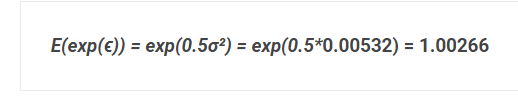

In [ ]:
residual = (y_train - y_finalTrain)

# residualsEDM = y_train - yRoe  #Y_train_EDM_xgb #y_finalTrain
# residualsEDM

residualEDM_mean = residual.mean()
residualEDM_var = residual.var()

plt.hist(residualsEDM, bins=50)
plt.show()

print(residualEDM_mean,"Residual Mean")
print(residualEDM_var,"Residual Variance")



In [ ]:
from scipy import stats

In [ ]:
duanFactor = np.exp(0.5*residualEDM_var)
duanFactor

In [ ]:
yfinalDS = y_final*duanFactor
# Y_NEW_Pred_EDM_xgbDS = Y_NEW_Pred_EDM_xgb*duanFactor

In [ ]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
# sns.regplot(x=y_test,y=y_pred_lgbm,marker="+",truncate=False,line_kws={"color": "blue"})
sns.regplot(x=y_test,y=y_final,marker="+",truncate=False,line_kws={"color": "purple"})
sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_xgb,marker="+",truncate=False,line_kws={"color": "red"})
sns.regplot(x=y_test,y=yfinalDS,marker="+",truncate=False,line_kws={"color": "green"})
# sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_xgbDS,marker="+",truncate=False,line_kws={"color": "yellow"})

In [ ]:
r_square_xgb_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_xgb)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_xgb, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_xgb, squared=True)
print('MSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
r_square_xgb_final = metrics.r2_score(y_test,yfinalDS)
print('R-Square Error associated with XGBoost Regression is:', r_square_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, yfinalDS, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_xgb_final)
rms_xgb_final = metrics.mean_squared_error(y_test, yfinalDS, squared=True)
print('MSE associated with XGBoost Regression is:', rms_xgb_final)

In [ ]:
test = stats.normaltest(residualsEDM)
test

In [ ]:
stats.probplot(residualsEDM, dist='norm', plot= plt)

In [ ]:
from scipy.stats import shapiro

In [ ]:
stats,p = shapiro(residualsEDM)
print(p)



In [ ]:
stats.moment(residualsEDM, moment = 1)

In [ ]:
type(residualsEDM)

# Guassian Progress Regressor

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [ ]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [ ]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [ ]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

In [ ]:
y_train_mean = y_train.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_train_mean)

# Linear Regression

In [ ]:
from sklearn import linear_model

In [ ]:
lm_model = linear_model.LinearRegression()

In [ ]:
lm_model.fit(X_train, y_train)

In [ ]:
y_train.shape

In [ ]:
pred_lm_model = lm_model.predict(X_train)

In [ ]:
# Accuracy

# Accuracy on Test
print("Training Accuracy is: ", lm_model.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", lm_model.score(X_test, y_test))

r_square_lm = metrics.r2_score(y_test,y_pred)
print('R-Square Error associated with XGBoost Regression is:', r_square_lm)
rms_lm = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lm)

## For ROE Calibration Only

In [ ]:
from sklearn import linear_model

In [ ]:
lm_model_ROE = linear_model.LinearRegression()

In [ ]:
y_train_rshp = y_train.reshape(-1, 1)

In [ ]:
y_train_rshp.shape

In [ ]:
Y_tr_ML_rshp = Y_tr_ML.reshape(-1, 1)

In [ ]:
Y_tr_ML_rshp.shape

In [ ]:
lm_ROE_Final = (lm_model_ROE.fit(y_train_rshp, Y_tr_ML_rshp))*   ### Y_tr_ML is the XGBoost Prediction

# Baseline Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error

regression = LinearRegression()
regression.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept = True, n_jobs=1, normalize = False)
first_model = (mean_squared_error(y_true=y_train, y_pred=regression.predict(X_train)))
print(first_model)

# Lasso & Ridge Regression

In [ ]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


In [ ]:
lasso = Lasso(normalize=True)
search=GridSearchCV(estimator=lasso,param_grid={'alpha': np.logspace(-5,2,8)},
                   scoring = 'neg_mean_squared_error', n_jobs=1,refit=True, cv=10)
search.fit(X_train,y_train)

In [ ]:
print(search.best_params_)
print(abs(search.best_score_))

In [ ]:
lasso = Lasso(normalize=True, alpha=1e-05)
lasso.fit(X_train,y_train)
second_model=mean_squared_error(y_true=y_train, y_pred=lasso.predict(X_train))
print(second_model)

In [ ]:
#Model
lr = LinearRegression()

#Fit model
lr.fit(X_train, y_train)

#predict
#prediction = lr.predict(X_test)

#actual
actual = y_test

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))


#Ridge Regression Model
ridgeReg = Ridge(alpha=10)

ridgeReg.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

In [ ]:
#Lasso regression model
print("\nLasso Model............................................\n")
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

In [ ]:
#Using the linear CV model
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv_final_model = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=42)

# fitting it
lasso_cv_final_model.fit(X_train, y_train)

y_pred_lasso_final = lasso_cv_final_model.predict(X_test)

#score
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

In [ ]:
# performing predictions on the test dataset
y_pred_lasso = lasso_cv.predict(X_test)

In [ ]:
from sklearn import metrics 

r_square_lm = metrics.r2_score(y_test,y_pred_lasso)
print('R-Square Error associated with XGBoost Regression is:', r_square_lm)
rms_lm = metrics.mean_squared_error(y_test, y_pred_lasso, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lm)

In [ ]:
#Using the linear CV model
from sklearn.linear_model import RidgeCV

#Lasso Cross validation
ridge_cv = RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(X_train, y_train)

#score
print("The train score for ridge model is {}".format(ridge_cv.score(X_train, y_train)))
print("The train score for ridge model is {}".format(ridge_cv.score(X_test, y_test)))

In [ ]:
# performing predictions on the test dataset
y_pred_ridge= ridge_cv.predict(X_test)

In [ ]:
from sklearn import metrics 

r_square_lm = metrics.r2_score(y_test,y_pred_ridge)
print('R-Square Error associated with XGBoost Regression is:', r_square_lm)
rms_lm = metrics.mean_squared_error(y_test, y_pred_ridge, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_lm)

# SVM Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
SVM_regression = SVR()
SVM_regression.fit(X_train, y_train)

In [ ]:
y_pred_svm = SVM_regression.predict(X_test)

In [ ]:
# Accuracy
from sklearn import metrics 
print()

# Accuracy on Test
print("Training Accuracy is: ", SVM_regression.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", SVM_regression.score(X_test, y_test))

r_square_svm = metrics.r2_score(y_test,y_pred_svm)
print('R-Square Error associated with XGBoost Regression is:', r_square_svm)
rms_svm = metrics.mean_squared_error(y_test, y_pred_svm, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_svm)

In [ ]:
my_param_grid = {'C': [1,5], 'gamma': [1,0.1,0.01], 'kernel': ['rbf']} 

# my_param_grid = {'C': [1,5,10], 'gamma': [1,0.1,0.01], 'kernel': ['rbf']} 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
GridSearchCV(estimator=SVR(),param_grid= my_param_grid, refit = True, verbose=3, cv=5 )

In [ ]:
grid = GridSearchCV(estimator=SVR(),param_grid= my_param_grid, refit = True, verbose=2, cv=5 )
# verbose just means the text output describing the process. (the greater the number the more detail you will get).

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

In [ ]:
my_param_grid = {'C': [5], 'gamma': [1], 'kernel': ['rbf'], 'epsilon' :[0.1, 0.005, 0.001]} 

In [ ]:
pred_svm_model_final = grid.predict(X_test)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 

# Accuracy on Test
print("Training Accuracy is: ", grid.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", grid.score(X_test, y_test))

r_square_svm_final = metrics.r2_score(y_test,pred_svm_model_final)
print('R-Square Error associated with XGBoost Regression is:', r_square_svm_final)
rms_svm_final = metrics.mean_squared_error(y_test, pred_svm_model_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_svm_final)

In [ ]:
rms_svm_final = metrics.mean_squared_error(y_test, pred_svm_model_final, squared=False)
print('RMSE associated with XGBoost Regression is:', rms_svm_final)

# Neural Network Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000).fit(X_train, y_train)

In [ ]:
y_pred_nn=reg.predict(X_test)
print("The Score with ", (r2_score(y_pred_nn, y_test)))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
 
# Make prediction
pred = nn.predict(X_test)
#
# Calculate accuracy and error metrics
#
test_set_rsquared = nn.score(X_test, y_test)
test_set_rmse = np.sqrt(mean_squared_error(y_test, pred))
#
# Print R_squared and RMSE value
#
print('R_squared value: ', test_set_rsquared)
print('RMSE: ', test_set_rmse)

# Convolutional Neural Network (CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

# pip install graphviz
# conda install python-graphviz

# Apply Best Model to Create an Image

## Loop through Folder for Each Image

In [ ]:
import glob

In [ ]:
# File and folder paths
dirpath = "D:\\_TheNatureConservancy\\Biomass\\Modeling\\GEDI_EE_Biomass_Yearly_Observations_Tables_20220716"
out_fp = os.path.join(dirpath, "GEDI_EE_Biomass_Yearly_Observations_2021_Model.tif")

# Make a search criteria to select the DEM files
search_criteria = "*GEDI*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

In [ ]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

In [ ]:
conda install cv2

In [ ]:
import cv2

In [ ]:
GEDI_EE_image = GEDI_EE_Biomass_ds.read()
[bands,rows,cols] = GEDI_EE_image.shape

In [ ]:
# List for the source files
src_files_to_model = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_model.append(src)

src_files_to_model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_model[0], ax=ax1)
show(src_files_to_model[1], ax=ax2)
# show(src_files_to_mosaic[2], ax=ax3)
# show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2]:
    ax.yaxis.set_visible(False)

In [ ]:
GEDI_EE_image = images_list[0] # reshape my numpy array
GEDI_EE_image.shape
# [bands,rows,cols] = GEDI_EE_image.shape
# print('reshaped')
# print(bands)
# print(rows)
# print(cols)

## Apply Best Model

In [ ]:
GEDI_EE_image = reshape_as_image(GEDI_EE_image) # reshape my numpy array
[bands,rows,cols] = GEDI_EE_image.shape
print('reshaped')
print(bands)
print(rows)
print(cols)

In [ ]:
images_list = np.array(src_files_to_model)

In [ ]:
images_list[1]

In [ ]:
images_list.shape[0]

In [ ]:
images_list[1]

In [ ]:
img_number = 2021
for image in range(images_list.shape[0]):
    input_img = images_list[image]  #Grey images. For color add another dim.
    with rasterio.open(input_img) as scr:
        img = src.read()
#     reshaped_img = reshape_as_image(img)
#     reshaped_img_norm = transformer.transform(reshaped_img.reshape(-1, 42))
#     xgb_prediction = xgb_final_model.predict(reshaped_img_norm)
#     xgb_prediction = xgb_prediction.reshape(reshaped_img[:, :, 0].shape)
#     # write the file in one go using all options
#     with rasterio.open('C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Validation\\Results\\GEDI_EE_Biomass_Validation_1km.tif'+str(img_number),
#             'w',
#             driver='GTiff',
#             height=xgb_prediction.shape[0],
#             width=xgb_prediction.shape[1],
#             count=1,
#             #dtype=xgb_prediction.dtype,
#             dtype = 'float32',
#             crs = crs,
#             transform=transform,) as dst:
#         dst.write(xgb_prediction, 1)
#     img_number +=1  

In [ ]:
GEDI_Image = None
src = None

# Start Here 20220714

In [ ]:
# from osgeo import gdal
# from osgeo import osr
# from osgeo import ogr
# import rasterio
# from rasterio.plot import reshape_as_raster, reshape_as_image, show
# from rasterio.mask import mask
# import geopandas as gpd
# # import rasterstats
# import scipy.ndimage
# # import geemap
# from scipy import stats
# import glob

In [ ]:
# # Packages / libraries
# import os #provides functions for interacting with the operating system
# import numpy as np 
# import pandas as pd
# from matplotlib import pyplot as plt
# import seaborn as sns

# %matplotlib inline

# # To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# # To change scientific numbers to float
# np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# # Increases the size of sns plots
# sns.set(rc={'figure.figsize':(8,6)})

# # Datetime lib
# from pandas import to_datetime
# import itertools
# import warnings
# import datetime
# warnings.filterwarnings('ignore')

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

# # pip install graphviz
# # conda install python-graphviz

In [ ]:
# 'D:\\_TheNatureConservancy\\Biomass\\Modeling\\GEDI_EE_Biomass_Yearly_Observations_Tables_20220716\\GEDI_Biomass_Image_Variables_2021-0000000000-0000005120.tif'


# GEDI_Image = 'E:\\GEDI\\LandTrendr\\^Downloads\\20230414\\SR\\GEDI_Kenobi_2000_2000_REFRESH_Summer_LandTrendr_SR.tif'
# GEDI_Image = 'E:\\GEDI\\LandTrendr\\GEDI_Kenobi_SR_GeoMedian_Summer_2021_2019.tif'

###Below is Kenobi SR Medoid
# GEDI_Image = 'E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wLatLon_Composite_2020.tif'
# GEDI_Image = 'E:\\GEDI\\LandTrendr\\GEDI_Kenobi_TOA_Mediod_LandTrendr_wLatLon_Composite_2020.tif'


##This is just Kenobi SR with ecoRegions & Updated latLon
# GEDI_Image = 'E:\\GEDI\\LandTrendr\\^Downloads\\20231028\\SR\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_SR_v3.tif'


# GEDI_Image ='E:\\GEDI\\LandTrendr\\^Downloads\\20231030\\TOA\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_TOA_wTexture_wForestType.tif'

## Belo is current Gold!####
#GEDI_Image ="E:\\GEDI\LandTrendr\\_postProcessing\\01_Mosaic\\GEDI_EE_Kenobi_TOA_2020_Medoid_wTexture_wGNN_wLCMS_noElevDiff_wHydro_impFeatures_ModelPrep.tif"

## Below is LatLon Testing: Looking for Edge Artifacts
# GEDI_Image ="E:\\GEDI\LandTrendr\\_postProcessing\\01_Mosaic\\GEDI_EE_Kenobi_TOA_2020_Medoid_impFeatures.tif"


# GEDI_Image = "E:\\GEDI\\LandTrendr\\^Downloads\\20231106\\TOA\\GEDI_Kenobi_2020_2020_REFRESH_Summer_LandTrendr_TOA_wTexture_wGNN_wLCMS_noElevDiff_impFeatures.tif"


##This is just Kenobi SR with ecoRegions (67% Accuracy)
# GEDI_Image ='E:\\GEDI\\LandTrendr\\GEDI_Kenobi_LandTrendr_wEcoRegions_Composite_2020.tif'

In [ ]:
# "E:\GEDI\EndGame\Imagery_Predictors\test\01_Mosaic\GEDI_EE_Kenobi_TOA_Medoid_152_274_2019_2019_LT_featureImportance.tif"

yr = 2018

outDirPath = "E:\\GEDI\\EndGame\\Imagery_Predictors\\geeDownload\\Medoid_152_274" #### UPdate This!
# out_fp = os.path.join(outDirPath, f"E:\\GEDI\\EndGame\\Imagery_Predictors\\geeDownload\\GEDI_Kenobi_EE_LT_TOA_Summer_Medoid_152_274_{yr}_{yr}_impFeatures_20240115.tif")
out_fp = os.path.join(outDirPath, f"GEDI_EE_Kenobi_imgPredictors_TOA_Medoid_152_274_{yr}_{yr}_GOLD_v2_20230116.tif")
print(out_fp)

In [ ]:
with rasterio.open(out_fp,"r+") as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    #img = src.read()[:, 1500:3000, 1500:3000]
    # this is the original data - not clipped
    src.nodata = -32768 # Change this is going to use Int16()!!!!!!!!!!!!!
    print(src.meta)
    img = src.read(masked=False) ##Important!!!!
    
#     b2 = img[0].astype(np.float)
#     b3 = img[1].astype(np.float)
#     b4 = img[2].astype(np.float)

#     # Create RGB
#     rgb = np.dstack((b4,b3,b2))

#     # Visualize RGB
#     plt.imshow(rgb)
    
print(src.nodatavals)
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# but first swap the order of dimensions (see above)
# img[np.isnan(img)] = float(0)
print(img.shape)

reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

In [ ]:
# reshaped_img

In [ ]:
print(reshaped_img.min())

In [ ]:
# # This is for RF
# # now predict but first reshape the image to that one long array
# xgb_prediction = xgb_final_model.predict(reshaped_img.reshape(-1, 36)) # Hmmmmmmmmmm....... why -1?

# # Reshape our classification map back into a 2D matrix so we can visualize it
# xgb_prediction = xgb_prediction.reshape(reshaped_img[:, :, 0].shape)
# print(xgb_prediction.shape)

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# plt.imshow(xgb_prediction,cmap=plt.cm.viridis)
# plt.colorbar()

In [ ]:
print(reshaped_img.shape)

In [ ]:
reshaped_img2 = reshaped_img.reshape(-1, 26) #32

In [ ]:
reshaped_imgNAN = np.where(reshaped_img2==-32768, np.nan, reshaped_img2)

In [ ]:
reshaped_imgNAN

In [ ]:
# reshaped_img_norm = reshaped_img2

In [ ]:
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [ ]:
# transformer = MinMaxScaler()

In [ ]:
# reshaped_img_norm = transformer.transform(reshaped_img2)

In [ ]:
reshaped_img_norm = reshaped_imgNAN

In [ ]:
print(reshaped_img_norm)

### Test: Loading in Model

In [ ]:
# savedModel = 'E:\\GEDI\\savedModels\\GEDI_Kenobi_XGB_original_20231023.sav'
# XGB_loaded_model = joblib.load(savedModel)

In [ ]:
# # This is for RF
# # now predict but first reshape the image to that one long array
# xgb_prediction = XGB_loaded_model.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1?

# # Reshape our classification map back into a 2D matrix so we can visualize it
# xgb_prediction = xgb_prediction.reshape(reshaped_img[:, :, 0].shape)
# print(xgb_prediction.shape)

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# plt.imshow(xgb_prediction,cmap=plt.cm.viridis)
# plt.colorbar()

### LGBM Model Predictions

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
lgbm_prediction = lgbm_model.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1?

# Reshape our classification map back into a 2D matrix so we can visualize it
lgbm_prediction = lgbm_prediction.reshape(reshaped_img[:, :, 0].shape)
print(lgbm_prediction.shape)

In [ ]:
print(np.unique(lgbm_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(lgbm_prediction.dtype)
print(lgbm_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(lgbm_prediction,cmap=plt.cm.viridis)
plt.colorbar()

print(f"Biomass Prediction NonCalibrated yr{yr}")

#### Calibrated Using ECDF

In [ ]:
lgbm_prediction_calibrated = inverted_edf(y_pred_EDM_xgb(lgbm_prediction))

In [ ]:
low_values_flags = lgbm_prediction_calibrated < 0  # Where values are low
lgbm_prediction_calibrated[low_values_flags] = 0  # All low values set to 0

In [ ]:
print(np.unique(lgbm_prediction_calibrated)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(lgbm_prediction_calibrated.dtype)
print(lgbm_prediction_calibrated.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plt.imshow(lgbm_prediction_calibrated,cmap=plt.cm.viridis)
plt.colorbar()

print(f"Biomass Prediction Calibrated yr{yr}")

### Random Forest Model Predictions

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
rf_prediction = rf_model.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1? rf_final_model

# Reshape our classification map back into a 2D matrix so we can visualize it
rf_prediction = rf_prediction.reshape(reshaped_img[:, :, 0].shape)
print(rf_prediction.shape)

In [ ]:
print(np.unique(rf_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(rf_prediction.dtype)
print(rf_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(rf_prediction,cmap=plt.cm.viridis)
plt.colorbar()

#### Calibration using ECDF

In [ ]:
rf_prediction_calibrated = inverted_edf(y_pred_EDM_xgb(rf_prediction))

In [ ]:
low_values_flags = rf_prediction_calibrated < 0  # Where values are low
rf_prediction_calibrated[low_values_flags] = 0  # All low values set to 0

In [ ]:
print(np.unique(rf_prediction_calibrated)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(rf_prediction_calibrated.dtype)
print(rf_prediction_calibrated.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(rf_prediction_calibrated,cmap=plt.cm.viridis)
plt.colorbar()

### Catboost Regression

In [ ]:
cb_final_model = cb_model

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
cat_prediction = cb_final_model.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1?

# Reshape our classification map back into a 2D matrix so we can visualize it
cat_prediction = cat_prediction.reshape(reshaped_img[:, :, 0].shape)
print(cat_prediction.shape)

In [ ]:
print(np.unique(cat_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(cat_prediction.dtype)
print(cat_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(cat_prediction,cmap=plt.cm.viridis)
plt.colorbar()

#### EDMF Calibration

In [ ]:
cat_prediction_calibrated = inverted_edf(y_pred_EDM_xgb(cat_prediction))

In [ ]:
low_values_flags = cat_prediction_calibrated < 0  # Where values are low
cat_prediction_calibrated[low_values_flags] = 0  # All low values set to 0

In [ ]:
print(np.unique(cat_prediction_calibrated)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(cat_prediction_calibrated.dtype)
print(cat_prediction_calibrated.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(cat_prediction_calibrated,cmap=plt.cm.viridis)
plt.colorbar()

### XGBoost Model Predictions

In [ ]:
xgb_prediction = None
xgb_prediction_calibrated = None

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
xgb_prediction1 = xgb_model.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1? xgb_final_model OR xgb_model

# Reshape our classification map back into a 2D matrix so we can visualize it
xgb_prediction = xgb_prediction1.reshape(reshaped_img[:, :, 0].shape)
print(xgb_prediction.shape)

In [ ]:
print(np.unique(xgb_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(xgb_prediction.dtype)
print(xgb_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xgb_prediction,cmap=plt.cm.viridis)
plt.colorbar()

#### Calibration using Original GEDI

In [ ]:
xgb_prediction_calibrated = inverted_edf(y_pred_EDM_xgb(xgb_prediction))

In [ ]:
low_values_flags = xgb_prediction_calibrated < 0  # Where values are low
xgb_prediction_calibrated[low_values_flags] = 0  # All low values set to 0

In [ ]:
print(np.unique(xgb_prediction_calibrated)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(xgb_prediction_calibrated.dtype)
print(xgb_prediction_calibrated.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xgb_prediction_calibrated,cmap=plt.cm.viridis)
plt.colorbar()

#### Calibration using RS Fris

In [ ]:
xgb_prediction_calibrated_rs = inverted_edf_rs(y_pred_EDM_xgb(xgb_prediction))

### 01: Use the tuned model to make new prediction
### 02: Run through the origal prediction EDM (y_)


In [ ]:
low_values_flags = xgb_prediction_calibrated_rs < 0  # Where values are low
xgb_prediction_calibrated_rs[low_values_flags] = 0  # All low values set to 0

In [ ]:
print(np.unique(xgb_prediction_calibrated_rs)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(xgb_prediction_calibrated_rs.dtype)
print(xgb_prediction_calibrated_rs.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xgb_prediction_calibrated_rs,cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
print(xgb_prediction)

#### Calibration Using ROE DUAN

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
xgb_prediction_for_ROE = OLS_model_roe.predict(xgb_prediction1) # Hmmmmmmmmmm....... why -1?

In [ ]:
xgb_prediction_for_ROE_DUAN = np.exp(xgb_prediction_for_ROE) * DuanSmearing

In [ ]:
xgb_prediction_for_ROE_DUAN = xgb_prediction_for_ROE_DUAN/2.47105

In [ ]:
# Reshape our classification map back into a 2D matrix so we can visualize it
xgb_prediction_calibrated_ROE_Duan = xgb_prediction_for_ROE_DUAN.reshape(reshaped_img[:, :, 0].shape)
print(xgb_prediction_calibrated_ROE_Duan.shape)

In [ ]:
print(np.unique(xgb_prediction_calibrated_ROE_Duan)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(xgb_prediction_calibrated_ROE_Duan.dtype)
print(xgb_prediction_calibrated_ROE_Duan.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xgb_prediction_calibrated_ROE_Duan,cmap=plt.cm.viridis)
plt.colorbar()

#### Simple Log  Back Transform

In [ ]:
GEDI_Prediction_LogBack = ((np.exp(xgb_prediction))*DuanSmearing)/2.47105

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(GEDI_Prediction_LogBack,cmap=plt.cm.viridis)
plt.colorbar()

### Lasso Regression

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
lasso_prediction = lasso.predict(reshaped_img_norm)

# Reshape our classification map back into a 2D matrix so we can visualize it
lasso_prediction = lasso_prediction.reshape(reshaped_img[:, :, 0].shape)
print(lasso_prediction.shape)

In [ ]:
print(np.unique(lasso_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(lasso_prediction.dtype)
print(lasso_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(lasso_prediction,cmap=plt.cm.viridis)
plt.colorbar()

### SVM Model Predictions

In [ ]:
# This is for RF
# now predict but first reshape the image to that one long array
svm_prediction = grid.predict(reshaped_img_norm) # Hmmmmmmmmmm....... why -1?

# Reshape our classification map back into a 2D matrix so we can visualize it
svm_prediction = svm_prediction.reshape(reshaped_img[:, :, 0].shape)
print(svm_prediction.shape)

In [ ]:
print(np.unique(svm_prediction)) # prints the unique class values
#class_results = xgb_prediction.reshape(rows,cols)
print(svm_prediction.dtype)
print(svm_prediction.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(xgb_prediction,cmap=plt.cm.viridis)
plt.colorbar()

## Export Map to Local Drive

In [ ]:
# # xgb2 = xgb_prediction_calibrated/2.47105
# cat_prediction = np.exp(cat_prediction)
# # xgb_prediction_calibrated = np.exp(xgb_prediction_calibrated)

In [ ]:
# cat_prediction_calibrated = np.exp(cat_prediction_calibrated)

In [ ]:
# xgb_prediction = np.exp(rf_prediction)/2.47105
# xgb_prediction_calibrated = np.exp(rf_prediction_calibrated)/2.47105

### Load in Shapefile Mask

In [ ]:
# To mask the data
import fiona
with fiona.open("E:\\GEDI\\EndGame\\Imagery_Predictors\\mask\\GEDI_EE_Kenobi_GNN_maskSHP.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

### Convert AGBD from mT/Hectare to Mg/Acre

In [ ]:
xgb_prediction = np.exp(lgbm_prediction)/2.47105
xgb_prediction_calibrated = np.exp(lgbm_prediction_calibrated)/2.47105


### Light GBM Export

Use one of the following:

XGBoost = xgb_prediction

Random Forest = 

SVM = svm_prediction

In [ ]:
# 'C:\\Users\\Shadw\\Desktop\\EOI\\_NatureConservancy\\Analysis\\Biomass\\Modeling\\Results\\GEDI_Biomass_Image_Variables_2007-0000000000-0000000000-020_Modeled.tif',



# start generating variables used for writing the geotiff image
ds = rasterio.open(out_fp,"r+") # Original Image 30m Year Time frame (e.g. 2021 only)
transform = ds.transform # transform parameters read from the original image
crs = ds.crs # CRS parameters read from the original image

newImage = f'E:\\GEDI\EndGame\\Results\\Medoid_152_274\\nonCalibrated\\noMask_GEDI_EE_Kenobi_AGBD_nonCalibrated_LightGBM_yr{yr}.tif'


# write the file in one go using all options
with rasterio.open(
    newImage,
    'w',
    driver='GTiff',
    height=xgb_prediction.shape[0],
    width=xgb_prediction.shape[1],
    count=1,
    #dtype=xgb_prediction.dtype,
    dtype = 'float32',
    crs = crs,
    transform=transform
#     nodata = -32768
) as dst:
    dst.write(xgb_prediction, 1)
    
###  xgb_prediction_calibrated
### xgb_prediction

In [ ]:
newImage2 = f'E:\\GEDI\EndGame\\Results\\Medoid_152_274\\nonCalibrated\\GEDI_EE_Kenobi_AGBD_nonCalibrated_LightGBM_yr{yr}.tif'

with rasterio.open(newImage) as src:
    out_image, transformed = rasterio.mask.mask(src, shapes, crop=True, filled=True, nodata = -32768)
    out_profile = src.profile.copy()

out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed, 'nodata': -32768})
with rasterio.open(newImage2, 'w', **out_profile) as dst:
    dst.write(out_image)

In [ ]:
# start generating variables used for writing the geotiff image
ds = rasterio.open(out_fp,"r+") # Original Image 30m Year Time frame (e.g. 2021 only)
transform = ds.transform # transform parameters read from the original image
crs = ds.crs # CRS parameters read from the original image

newImage3 = f'E:\\GEDI\EndGame\\Results\\Medoid_152_274\\Calibrated\\noMask_GEDI_EE_Kenobi_AGBD_Calibrated_LightGBM_yr{yr}.tif'

# write the file in one go using all options
with rasterio.open(
    newImage3,
    'w',
    driver='GTiff',
    height=xgb_prediction_calibrated.shape[0],
    width=xgb_prediction_calibrated.shape[1],
    count=1,
    #dtype=xgb_prediction.dtype,
    dtype = 'float32',
    crs = crs,
    transform=transform
#     nodata = -32768
) as dst:
    dst.write(xgb_prediction_calibrated, 1)
    
###  xgb_prediction_calibrated
### xgb_prediction

In [ ]:
newImage4 = f'E:\\GEDI\EndGame\\Results\\Medoid_152_274\\Calibrated\\GEDI_EE_Kenobi_AGBD_Calibrated_LightGBM_yr{yr}.tif'

with rasterio.open(newImage3) as src:
    out_image, transformed = rasterio.mask.mask(src, shapes, crop=True, filled=True, nodata = -32768)
    out_profile = src.profile.copy()

out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed, 'nodata': -32768})
with rasterio.open(newImage4, 'w', **out_profile) as dst:
    dst.write(out_image)

In [ ]:
xgb_prediction_calibrated = None
xgb_prediction = None

lgbm_prediction = None
lgbm_prediction_calibrated = None

newImage = None
newImage2 = None
newImage3 = None
newImage4 = None


out_fp = None
ds= None

reshaped_img = None
reshaped_img2 = None
reshaped_imgNaN = None


reshaped_img_norm = None

low_values_flags = None


In [ ]:
# # check if the file exists
# !gdalinfo GEDI_EE_Biomass_Validation.tif

In [ ]:
from rasterio import plot
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
GEDI_Biomass_2021 = rasterio.open('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Results\\XGBoost\\GEDI_EE_Biomass_Prediction_2021_XGB_Calibrated.tif')
plt.figure(figsize=(20,20))
plot.show(GEDI_Biomass_2021,cmap=plt.cm.viridis)

### Accuracy Assessment

In [ ]:
from rasterio import plot
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
GEDI_Biomass_ds = rasterio.open('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Results\\Emerald_Edge\\XGBoost\\00_Python_Outputs\\GEDI_Refresh\\_PI_Exploration\\TNC_Tool_high\\RasterCalc_Clip.tif')
plt.figure(figsize=(20,20))
plot.show(GEDI_Biomass_ds,cmap=plt.cm.viridis)

In [ ]:
GEDI_Biomass_ds.profile

In [ ]:
GEDI_Biomass = GEDI_Biomass_ds.read([1]).reshape(-1)
print(GEDI_Biomass)

In [ ]:
RS_Fris_ds = rasterio.open('D:\\_TheNatureConservancy\Biomass\\QC\\Prepared_Sources\\RS_Fris\\ArcGIS\\RS_Fris_Reprj_Arc_Clipped_Validation04_Clip.tif')

# with RS_Fris_ds as scr:
#     GEDI_Biomass = scr.read(1, masked=True)

# plt.figure(figsize=(20,20))
# plot.show(RS_Fris_ds,cmap=plt.cm.viridis)

In [ ]:
RS_Fris_ds.profile

In [ ]:
RS_Fris = RS_Fris_ds.read([1]).reshape(-1)
print(RS_Fris)

In [ ]:
# Accuracy
# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# Accuracy on Test vs Predicted
r_square = metrics.r2_score(RS_Fris,GEDI_Biomass)
print('R-Square Error associated with Random Forest Regression is:', r_square)
rms = metrics.mean_squared_error(RS_Fris, GEDI_Biomass, squared=False)
print('RMSE associated with Random Forest Regression is:', rms)

# Mosaic Yearly Predictions Together

## Read in Band Dictionary

In [ ]:
BandDictionary = "E:\\GEDI\\EndGame\\BandDictionary\\01_GEDI_EE_Kenobi_BandDictionary_152_274_LT_impFeatures.csv"

In [ ]:
custom_dictionary = pd.read_csv(BandDictionary, delimiter = ",")
BandCount = len(custom_dictionary)
custom_dictionary_list = []

for i in custom_dictionary.values:
    custom_dictionary_list.append(list(i)[0])

In [ ]:
len(custom_dictionary_list)

## Read in Files to Mosaic

In [ ]:
# File and folder paths

inDirPath = "E:\\GEDI\\EndGame\\Imagery_Predictors\\test\\00_original_date"
outDirPath = "E:\\GEDI\\EndGame\\Imagery_Predictors\\test\\01_Mosaic" #### UPdate This!
out_fp = os.path.join(outDirPath, "GEDI_EE_Kenobi_TOA_Medoid_152_274_2019_2019_LT_featureImportance.tif")

# Make a search criteria to select the DEM files
search_criteria = "*.tif"  ##"*2021*.tif"
q = os.path.join(inDirPath, search_criteria)
print(q)

In [ ]:
# glob function can be used to list files from a directory with specific criteria
raster_list = glob.glob(q)

# Files that were found:
raster_list

In [ ]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for r in raster_list:
    src = rasterio.open(r)
    src_files_to_mosaic.append(r)

src_files_to_mosaic

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Create 4 plots next to each other
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# # Plot first four files
# show(src_files_to_mosaic[0], ax=ax1)
# show(src_files_to_mosaic[1], ax=ax2)
# show(src_files_to_mosaic[2], ax=ax3)
# show(src_files_to_mosaic[3], ax=ax4)

# # Do not show y-ticks values in last three axis
# for ax in [ax2, ax3, ax4]:
#     ax.yaxis.set_visible(False)

In [ ]:
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# # Plot the result
# show(mosaic, cmap='terrain')

In [ ]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "nodata": -2147483648,
#                  "crs": crs,
                 "dtype":"int32"
                 })
                

In [ ]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta, compress='LZW', tiled=True, blockxsize = 128, blockysize=128, BIGTIFF='YES') as dst:
    dst.write(mosaic)
    dst.descriptions = tuple(custom_dictionary_list)
    

In [ ]:
out_fp = "E:\\GEDI\\EndGame\\Imagery_Predictors\\GEDI_Kenobi_EE_LT_TOA_Summer_Medoid_152_274_2019_2019_impFeatures_20240115.tif"


rast = gdal.Open(out_fp,gdal.GA_Update)
for j in range(1, rast.RasterCount+1):
    bName = rast.GetRasterBand(j).GetDescription()
    b = rast.GetRasterBand(j)#.SetNoDataValue(-32768)
    Min, Max, Mean, Std = b.ComputeStatistics(0)
    b.SetStatistics(Min, Max, Mean, Std)
    print('Updating Statistics of Band:',bName)
    print('Min:', Min)
    print('Max:', Max)
    print('Mean:', Mean)
    print('Std:', Std)
    
    b = None
    bName = None
j = None
rast = None

In [ ]:
rast = gdal.Open(out_fp,gdal.GA_Update)

band = rast.GetRasterBand(44)
arr = band.ReadAsArray()

arr[(arr<0)] = 0
band.WriteArray(arr)
band.SetNoDataValue(-32768)

Min, Max, Mean, Std = band.ComputeStatistics(0)
band.SetStatistics(Min, Max, Mean, Std)
print('Min:', Min)
print('Max:', Max)
print('Mean:', Mean)
print('Std:', Std)
band.FlushCache()
    
band = None    
rast = None

In [ ]:
# GEDI_Biomass_2020 = rasterio.open('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Results\\GEDI_EE_Biomass_Predictions_2021_Mosaic.tif')
# plt.figure(figsize=(20,20))
# plot.show(GEDI_Biomass_2020,cmap=plt.cm.viridis)

# Comparing Rasters

In [ ]:
GEDI_Results = rasterio.open('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Results\\Emerald_Edge\\XGBoost\\00_Python_Outputs\\GEDI_Refresh\\_PI_Exploration\\TNC_Tool_high\\RasterCalc_Clip.tif')
RS_Fris = rasterio.open('D:\\_TheNatureConservancy\\Biomass\\Modeling\\Results\\Emerald_Edge\\XGBoost\\00_Python_Outputs\\GEDI_Refresh\\_PI_Exploration\\TNC_Tool_high\\RasterCalc_Clip.tif')